In [10]:
import gym
import numpy as np
import torch
import torchkit.pytorch_utils as ptu
import torchsde
from torch.nn import functional as F
import random as rnd
import copy as cp
# import environments
import envs.pomdp
import pdb
# import recurrent model-free RL (separate architecture)
from policies.models.policy_rnn import ModelFreeOffPolicy_Separate_RNN as Policy_RNN
from policies.models.policy_rnn_shared import ModelFreeOffPolicy_Shared_RNN as Policy_Shared_RNN
from policies.models.policy_mlp import ModelFreeOffPolicy_MLP as Policy_MLP
from tqdm import tqdm
# import the replay buffer
from buffers.seq_replay_buffer_vanilla import SeqReplayBuffer
from buffers.simple_replay_buffer import SimpleReplayBuffer 
from utils import helpers as utl
from typing import Sequence
from read_ini import read_ini

In [34]:
conf =read_ini("C:/Users/alexander.vasilyev/pomdp-baselines-main/configfile.ini")

## Build a POMDP environment: Pendulum-V (only observe the velocity)

In [37]:
cuda_id = 0  # -1 if using cpu
ptu.set_gpu_mode(torch.cuda.is_available() and cuda_id >= 0, cuda_id)

env = gym.make(conf["env_name"])
max_trajectory_len = env._max_episode_steps
act_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]

shared = False
markov = False

if markov:
    agent = Policy_MLP(
        obs_dim=obs_dim,
        action_dim=act_dim,
        algo_name=conf["algo_name"],
        dqn_layers=[128, 128],
        policy_layers=[128, 128],
        lr=3e-4,
        gamma=0.99,
        tau=5e-3,
    ).to(ptu.device)
    encoder="Nan"
else:
    if shared:
        agent = Policy_Shared_RNN(
            obs_dim=obs_dim,
            action_dim=act_dim,
            encoder=conf["encoder"],
            algo_name=conf["algo_name"],
            action_embedding_size=int(conf["action_embedding_size"]),
            observ_embedding_size=int(conf["observ_embedding_size"]),
            reward_embedding_size=int(conf["reward_embedding_size"]),
            rnn_hidden_size=int(conf["hidden_size"]),
            dqn_layers=[128, 128],
            policy_layers=[128, 128],
            lr=float(conf["lr"]),
            gamma=0.9,
            tau=0.005,
            embed=True,
        ).to(ptu.device)
    else: 
        agent = Policy_RNN(
            obs_dim=obs_dim,
            action_dim=act_dim,
            encoder=conf["encoder"],
            algo_name=conf["algo_name"],
            action_embedding_size=int(conf["action_embedding_size"]),
            observ_embedding_size=int(conf["observ_embedding_size"]),
            reward_embedding_size=int(conf["reward_embedding_size"]),
            rnn_hidden_size=int(conf["hidden_size"]),
            dqn_layers=[128, 128],
            policy_layers=[128, 128],
            lr=float(conf["lr"]),
            gamma=0.9,
            tau=0.005,
            radii=60,
            embed=True,
            activation = conf["activation"],
        ).to(ptu.device)
    
print(agent)

num_updates_per_iter = int(conf["num_updates_per_iter"])  # training frequency
sampled_seq_len = int(conf["sampled_seq_len"])  # context length
buffer_size = int(conf["buffer_size"])
batch_size = int(conf["batch_size"])
dropout_rate=float(conf["dropout_rate"])
num_iters = int(conf["num_iters"])
num_init_rollouts_pool = int(conf["num_init_rollouts_pool"])
num_rollouts_per_iter = int(conf["num_rollouts_pool"])
total_rollouts = num_init_rollouts_pool + num_iters * num_rollouts_per_iter
n_env_steps_total = max_trajectory_len * total_rollouts
_n_env_steps_total = 0
print("total env episodes", total_rollouts, "total env steps", n_env_steps_total)

ModelFreeOffPolicy_Separate_RNN(
  (critic): Critic_RNN(
    (observ_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=32, bias=True)
    )
    (action_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=8, bias=True)
    )
    (reward_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=8, bias=True)
    )
    (rnn): NeuralCDE(
      (func): CDEFunc(
        (linear0): Linear(in_features=72, out_features=72, bias=True)
        (linear1): Linear(in_features=72, out_features=72, bias=True)
        (linear2): Linear(in_features=72, out_features=3528, bias=True)
      )
      (initial): Linear(in_features=49, out_features=72, bias=True)
      (readout): Linear(in_features=72, out_features=72, bias=True)
    )
    (current_shortcut_embedder): FeatureExtractor(
      (fc): Linear(in_features=2, out_features=48, bias=True)
    )
    (qf1): FlattenMlp(
      (fc0): Linear(in_features=120, out_features=128, bias=True)
   

ValueError: invalid literal for int() with base 10: '1.0  # training frequency'

## Build a recurent model-free RL agent: separate architecture, `lstm` encoder, `oar` policy input space, `td3` RL algorithm (context length set later)

## Define other training parameters such as context length and training frequency

## Define key functions: collect rollouts and policy update

In [7]:
def create_ncde_row(obs, next_obs, prev_action, action, prev_reward, reward, steps,init):
    
    if init:
        obs_row= obs
        rew_row = prev_reward
        act_row = prev_action
    else:
        obs_row=torch.cat((obs, next_obs),0)
        rew_row=torch.cat((prev_reward, reward),0)
        act_row=torch.cat((prev_action, action),0)
 
    if shared: 
        obs_row=agent.observ_embedder(obs_row)
        rew_row=agent.reward_embedder(rew_row)
        act_row=agent.action_embedder(act_row)
    else: 
        obs_row=agent.actor.observ_embedder(obs_row)
        rew_row=agent.actor.reward_embedder(rew_row)
        act_row=agent.actor.action_embedder(act_row)
    
    if init:
        time_tensor=torch.tensor([[steps]]).to(ptu.device)
    else:
        time_tensor=torch.tensor([[steps],[steps+1]]).to(ptu.device)

    ncde_row=torch.cat((time_tensor,act_row,obs_row,rew_row),1)
    ncde_row=ncde_row[None,:]
    
    return ncde_row



@torch.no_grad()
def collect_rollouts(
    num_rollouts, random_actions=False, deterministic=True, train_mode=True
):
    """collect num_rollouts of trajectories in task and save into policy buffer
    :param
        random_actions: whether to use policy to sample actions, or randomly sample action space
        deterministic: deterministic action selection?
        train_mode: whether to train (stored to buffer) or test
    """
    if not train_mode:
        assert random_actions == False and deterministic == True

    total_steps = 0
    total_rewards = 0.0
    trewards =[]
    for idx in range(num_rollouts):
        steps = 0
        rewards = 0.0
        energy = 0.0
        print(env.reset())
        obs = ptu.from_numpy(env.reset())
        obs = obs.reshape(1, obs.shape[-1])
        done_rollout = False
        init=True
        # get hidden state at timestep=0, None for mlp
        
        if not markov:
            action, reward, internal_state = agent.get_initial_info()

            if encoder == "ncde":
                internal_state= None
                ncde_row= create_ncde_row(obs, obs, action, action, reward, reward, steps,init)
                prev_action= action.clone()
                prev_reward= reward.clone()
                next_obs= obs.clone()
        
        
        if train_mode:
            # temporary storage
            obs_list, act_list, rew_list, next_obs_list, term_list = (
                [],
                [],
                [],
                [],
                [],
            )
                           

        while not done_rollout:
            if markov: 
                action = agent.act(obs=obs, deterministic=deterministic)[0]
            else:
                if encoder == "ncde":
                    (action,_,_,_), internal_state= agent.ncde_act(ncde_row=ncde_row, prev_internal_state=internal_state, obs=obs,  deterministic=deterministic)
                else:
                    (action, _, _, _), internal_state = agent.act(
                        prev_internal_state=internal_state,
                        prev_action=action,
                        reward=reward,
                        obs=obs,
                        deterministic=deterministic,
                    )
            # observe reward and next obs (B=1, dim)
            #pdb.set_trace()
        
            #print(torch.norm(internal_state))
            next_obs, reward, done, info = utl.env_step(env, action.squeeze(dim=0))
            done_rollout = False if ptu.get_numpy(done[0][0]) == 0.0 else True
            init=False
            
            if not markov:
                if encoder == "ncde":
   
                    ncde_row= create_ncde_row(obs, next_obs, prev_action, action, prev_reward, reward, steps,init)
            
            #switch on/off dropouts
            #drop_trigger=rnd.uniform(0,1)
            #if drop_trigger<dropout_rate:
            #    next_obs=cp.deepcopy(obs)
            # update statistics
           
            rewards += reward.item()
            energy += action*action
           
            # early stopping env: such as rmdp, pomdp, generalize tasks. term ignores timeout
            term = (
                False
                if "TimeLimit.truncated" in info or steps >= max_trajectory_len
                else done_rollout
            )

            if train_mode:
                # append tensors to temporary storage
                obs_list.append(obs)  # (1, dim)
                act_list.append(action)  # (1, dim)
                rew_list.append(reward)  # (1, dim)
                term_list.append(term)  # bool
                next_obs_list.append(next_obs)  # (1, dim)
            steps += 1
            # set: obs <- next_obs
            obs = next_obs.clone()
            prev_reward= reward.clone()
            prev_action= action.clone()
        if train_mode:
            # add collected sequence to buffer
            policy_storage.add_episode(
                observations=ptu.get_numpy(torch.cat(obs_list, dim=0)),  # (L, dim)
                actions=ptu.get_numpy(torch.cat(act_list, dim=0)),  # (L, dim)
                rewards=ptu.get_numpy(torch.cat(rew_list, dim=0)),  # (L, dim)
                terminals=np.array(term_list).reshape(-1, 1),  # (L, 1)
                next_observations=ptu.get_numpy(
                    torch.cat(next_obs_list, dim=0)
                ),  # (L, dim)
            )
        print(
            "Mode:",
            "Train" if train_mode else "Test",
            "env_steps",
            steps,
            "total rewards",
            rewards,
            "total energy",
            energy,
        )
        total_steps += steps
        total_rewards += rewards
        trewards.append(rewards)
    if train_mode:
        return total_steps
    else:
        return total_rewards / num_rollouts, np.std(trewards)


def update(num_updates, factor):
    rl_losses_agg = {}
    # print(num_updates)
    for update in tqdm(range(num_updates), leave=True):
        # sample random RL batch: in transitions
        batch = ptu.np_to_pytorch_batch(policy_storage.random_episodes(batch_size))
        # RL update
        
        rl_losses = agent.update(batch, factor)

        for k, v in rl_losses.items():
            if update == 0:  # first iterate - create list
                rl_losses_agg[k] = [v]
            else:  # append values
                rl_losses_agg[k].append(v)
    # statistics
    for k in rl_losses_agg:
        rl_losses_agg[k] = np.mean(rl_losses_agg[k])
    return rl_losses_agg

## Train and Evaluate the agent: only costs < 20 min

In [8]:
policy_storage = SeqReplayBuffer(
    max_replay_buffer_size=int(buffer_size),
    observation_dim=obs_dim,
    action_dim=act_dim,
    sampled_seq_len=sampled_seq_len,
    sample_weight_baseline=0.0,
)

env_steps = collect_rollouts(
    num_rollouts=num_init_rollouts_pool, random_actions=False, train_mode=True
)
_n_env_steps_total += env_steps

# evaluation parameters
last_eval_num_iters = 10
log_interval = 5
eval_num_rollouts = 10
learning_curve = {
    "x": [],
    "y": [],
    "z": [],
}
epoch=0
lambda_pat = 0.65

while _n_env_steps_total < n_env_steps_total:

    env_steps = collect_rollouts(num_rollouts=num_rollouts_per_iter, train_mode=True)
    _n_env_steps_total += env_steps

    #train_stats = update(int(num_updates_per_iter * env_steps))
    factor= lambda_pat **(epoch )
    #train_stats = update(int(num_updates_per_iter * env_steps))
    train_stats = update(25, lr)
    
    epoch += 1
    current_num_iters = _n_env_steps_total // (
        num_rollouts_per_iter * max_trajectory_len
    )
    if (
        current_num_iters != last_eval_num_iters
        and current_num_iters % log_interval == 0
    ):
        last_eval_num_iters = current_num_iters
        average_returns, std_returns = collect_rollouts(
            num_rollouts=eval_num_rollouts,
            train_mode=False,
            random_actions=False,
            deterministic=True,
        )
        learning_curve["x"].append(_n_env_steps_total)
        learning_curve["y"].append(average_returns)
        learning_curve["z"].append(std_returns)
        print(_n_env_steps_total, average_returns)

buffer RAM usage: 0.02 GB
[-0.8886556]


C:\Users\alexander.vasilyev\Anaconda3\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Mode: Train env_steps 200 total rewards -752.1514814943075 total energy tensor([[0.0011]])
[-0.38494992]
Mode: Train env_steps 200 total rewards -966.8167201280594 total energy tensor([[0.0012]])
[-0.28952718]
Mode: Train env_steps 200 total rewards -1733.3318209648132 total energy tensor([[0.0002]])
[-0.27561712]
Mode: Train env_steps 200 total rewards -1808.0275964736938 total energy tensor([[0.0003]])
[0.47383732]
Mode: Train env_steps 200 total rewards -1069.4560034275055 total energy tensor([[0.0006]])
[0.56014025]
Mode: Train env_steps 200 total rewards -1398.5331158638 total energy tensor([[0.0005]])
[0.81298447]
Mode: Train env_steps 200 total rewards -930.098480373621 total energy tensor([[0.0011]])
[-0.64982426]
Mode: Train env_steps 200 total rewards -1519.8661150932312 total energy tensor([[0.0003]])
[0.65959096]
Mode: Train env_steps 200 total rewards -1195.3857116699219 total energy tensor([[0.0008]])
[0.09396754]
Mode: Train env_steps 200 total rewards -767.0736628770828

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\alexander.vasilyev\pomdp-baselines-main\torchkit\pytorch_utils.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if v.dtype == np.bool:
100%|██████████| 25/25 [00:57<00:00,  2.32s/it]


[-0.858687]
Mode: Train env_steps 200 total rewards -1295.2701272964478 total energy tensor([[30.6150]])
[-0.74713135]
Mode: Train env_steps 200 total rewards -1048.4881656412035 total energy tensor([[22.1755]])
[-0.7619818]
Mode: Train env_steps 200 total rewards -1271.372799396515 total energy tensor([[30.5758]])
[-0.36253005]
Mode: Train env_steps 200 total rewards -1276.2459196448326 total energy tensor([[28.2103]])
[-0.05145149]
Mode: Train env_steps 200 total rewards -1314.0028107762337 total energy tensor([[33.6320]])


100%|██████████| 25/25 [01:22<00:00,  3.31s/it]


[-0.14335765]
Mode: Train env_steps 200 total rewards -1120.2623265981674 total energy tensor([[35.5294]])
[0.6701961]
Mode: Train env_steps 200 total rewards -1591.5501455068588 total energy tensor([[158.6436]])
[-0.00273333]
Mode: Train env_steps 200 total rewards -1056.361417926848 total energy tensor([[8.8136]])
[-0.02744618]
Mode: Train env_steps 200 total rewards -1064.608354628086 total energy tensor([[8.8970]])
[-0.85559857]
Mode: Train env_steps 200 total rewards -1512.8443417549133 total energy tensor([[144.8969]])


100%|██████████| 25/25 [01:29<00:00,  3.58s/it]


[0.32944614]
Mode: Train env_steps 200 total rewards -1518.9321229457855 total energy tensor([[180.8153]])
[0.80315]
Mode: Train env_steps 200 total rewards -1599.4976488351822 total energy tensor([[197.0690]])
[-0.01288414]
Mode: Train env_steps 200 total rewards -1585.3629476428032 total energy tensor([[190.9108]])
[0.51239884]
Mode: Train env_steps 200 total rewards -1592.1129640340805 total energy tensor([[195.9822]])
[0.9548604]
Mode: Train env_steps 200 total rewards -1668.9528556466103 total energy tensor([[197.3090]])


100%|██████████| 25/25 [01:23<00:00,  3.35s/it]


[-0.08940437]
Mode: Test env_steps 200 total rewards -1607.857881784439 total energy tensor([[197.8901]])
[0.66710234]
Mode: Test env_steps 200 total rewards -1589.3124179691076 total energy tensor([[162.9896]])
[-0.661121]
Mode: Test env_steps 200 total rewards -1552.285821557045 total energy tensor([[181.3358]])
[0.8457368]
Mode: Test env_steps 200 total rewards -1601.5158936977386 total energy tensor([[162.9564]])
[0.6620378]
Mode: Test env_steps 200 total rewards -1621.9524097442627 total energy tensor([[195.8973]])
[-0.8592356]
Mode: Test env_steps 200 total rewards -1639.1513495445251 total energy tensor([[196.1042]])
[0.61828035]
Mode: Test env_steps 200 total rewards -1598.1391351222992 total energy tensor([[162.4919]])
[-0.3983485]
Mode: Test env_steps 200 total rewards -1539.5067472457886 total energy tensor([[150.5256]])
[0.2871818]
Mode: Test env_steps 200 total rewards -1637.6776406764984 total energy tensor([[196.3320]])
[-0.17173512]
Mode: Test env_steps 200 total reward

100%|██████████| 25/25 [01:21<00:00,  3.28s/it]


[0.28340778]
Mode: Train env_steps 200 total rewards -1654.3732580840588 total energy tensor([[197.5732]])
[0.56440574]
Mode: Train env_steps 200 total rewards -1491.920791298151 total energy tensor([[195.7487]])
[0.37301147]
Mode: Train env_steps 200 total rewards -1450.8777207434177 total energy tensor([[96.0278]])
[0.04825671]
Mode: Train env_steps 200 total rewards -1556.8730249404907 total energy tensor([[167.4206]])
[-0.39566275]
Mode: Train env_steps 200 total rewards -1464.4997664690018 total energy tensor([[96.7820]])


100%|██████████| 25/25 [01:12<00:00,  2.91s/it]


[-0.468584]
Mode: Train env_steps 200 total rewards -1566.1647394895554 total energy tensor([[180.9668]])
[0.6060268]
Mode: Train env_steps 200 total rewards -1576.5005668401718 total energy tensor([[179.4009]])
[-0.27715367]
Mode: Train env_steps 200 total rewards -1567.2340968437493 total energy tensor([[191.5202]])
[0.09094619]
Mode: Train env_steps 200 total rewards -1462.5780569314957 total energy tensor([[156.8570]])
[0.1791181]
Mode: Train env_steps 200 total rewards -1665.4520778656006 total energy tensor([[197.8974]])


100%|██████████| 25/25 [01:08<00:00,  2.75s/it]


[-0.10549574]
Mode: Train env_steps 200 total rewards -1441.8246710300446 total energy tensor([[145.9231]])
[-0.4412097]
Mode: Train env_steps 200 total rewards -1269.498694241047 total energy tensor([[101.3393]])
[0.20150857]
Mode: Train env_steps 200 total rewards -1620.7714780569077 total energy tensor([[197.9225]])
[0.05938006]
Mode: Train env_steps 200 total rewards -1581.7588157653809 total energy tensor([[155.2766]])
[0.9462109]
Mode: Train env_steps 200 total rewards -1553.4361013174057 total energy tensor([[179.7221]])


100%|██████████| 25/25 [01:10<00:00,  2.81s/it]


[0.26702952]
Mode: Train env_steps 200 total rewards -1388.5798643231392 total energy tensor([[107.2132]])
[-0.21855314]
Mode: Train env_steps 200 total rewards -1669.5719021558762 total energy tensor([[198.0732]])
[-0.5116922]
Mode: Train env_steps 200 total rewards -1531.4821821451187 total energy tensor([[177.3932]])
[-0.7697862]
Mode: Train env_steps 200 total rewards -1355.8116801977158 total energy tensor([[136.1817]])
[0.07242046]
Mode: Train env_steps 200 total rewards -1591.2902893349528 total energy tensor([[194.3598]])


100%|██████████| 25/25 [01:06<00:00,  2.65s/it]


[-0.68643975]
Mode: Test env_steps 200 total rewards -1663.1783969402313 total energy tensor([[197.1986]])
[-0.11880929]
Mode: Test env_steps 200 total rewards -1639.7531274855137 total energy tensor([[197.1665]])
[0.21209826]
Mode: Test env_steps 200 total rewards -1620.156452551484 total energy tensor([[197.1371]])
[0.79303765]
Mode: Test env_steps 200 total rewards -1657.708726644516 total energy tensor([[198.5486]])
[-0.80944717]
Mode: Test env_steps 200 total rewards -1523.0374238491058 total energy tensor([[123.6869]])
[0.7429964]
Mode: Test env_steps 200 total rewards -1681.8883618116379 total energy tensor([[198.5155]])
[0.23669176]
Mode: Test env_steps 200 total rewards -1303.9781349897385 total energy tensor([[54.8596]])
[0.45159876]
Mode: Test env_steps 200 total rewards -1683.4652537107468 total energy tensor([[198.7360]])
[-0.45005524]
Mode: Test env_steps 200 total rewards -1212.7184725254774 total energy tensor([[51.4650]])
[-0.9762479]
Mode: Test env_steps 200 total rew

100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


[-0.05514707]
Mode: Train env_steps 200 total rewards -1511.6335730552673 total energy tensor([[133.6277]])
[-0.4249418]
Mode: Train env_steps 200 total rewards -1423.0311388224363 total energy tensor([[154.6380]])
[0.2821492]
Mode: Train env_steps 200 total rewards -1575.4776340723038 total energy tensor([[179.3314]])
[-0.18138371]
Mode: Train env_steps 200 total rewards -1490.9190320074558 total energy tensor([[169.4773]])
[-0.79665977]
Mode: Train env_steps 200 total rewards -1518.236276090145 total energy tensor([[171.5504]])


100%|██████████| 25/25 [01:06<00:00,  2.65s/it]


[-0.12856114]
Mode: Train env_steps 200 total rewards -1594.0777274370193 total energy tensor([[197.0187]])
[-0.61626536]
Mode: Train env_steps 200 total rewards -1580.4536082744598 total energy tensor([[181.9970]])
[-0.4498045]
Mode: Train env_steps 200 total rewards -1461.4335803985596 total energy tensor([[149.0363]])
[-0.41982755]
Mode: Train env_steps 200 total rewards -1582.5638538599014 total energy tensor([[198.2268]])
[0.00596505]
Mode: Train env_steps 200 total rewards -1660.6161291599274 total energy tensor([[197.0781]])


100%|██████████| 25/25 [01:11<00:00,  2.85s/it]


[-0.9916251]
Mode: Train env_steps 200 total rewards -1137.1252669990063 total energy tensor([[144.3685]])
[0.87306577]
Mode: Train env_steps 200 total rewards -1560.7073482871056 total energy tensor([[197.7095]])
[0.2601602]
Mode: Train env_steps 200 total rewards -1658.6483783721924 total energy tensor([[93.8980]])
[-0.25281265]
Mode: Train env_steps 200 total rewards -1598.3188386075199 total energy tensor([[194.8746]])
[0.04381427]
Mode: Train env_steps 200 total rewards -1325.663595288992 total energy tensor([[162.8040]])


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


[-0.61162835]
Mode: Train env_steps 200 total rewards -1064.574658036232 total energy tensor([[162.8461]])
[-0.54648316]
Mode: Train env_steps 200 total rewards -1639.078022480011 total energy tensor([[197.1891]])
[-0.37693858]
Mode: Train env_steps 200 total rewards -1637.974437236786 total energy tensor([[102.8557]])
[0.44704857]
Mode: Train env_steps 200 total rewards -1639.1627192795277 total energy tensor([[196.7615]])
[0.06190012]
Mode: Train env_steps 200 total rewards -1593.4381895018741 total energy tensor([[193.6655]])


100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


[-0.19856276]
Mode: Test env_steps 200 total rewards -1558.7838100790977 total energy tensor([[185.9258]])
[-0.46259004]
Mode: Test env_steps 200 total rewards -1652.8194279670715 total energy tensor([[197.2667]])
[0.51202244]
Mode: Test env_steps 200 total rewards -1646.7389194965363 total energy tensor([[196.8095]])
[-0.99267215]
Mode: Test env_steps 200 total rewards -1623.0284423828125 total energy tensor([[197.5533]])
[-0.9835662]
Mode: Test env_steps 200 total rewards -1160.0269780009985 total energy tensor([[171.2023]])
[0.8761411]
Mode: Test env_steps 200 total rewards -1658.7121770977974 total energy tensor([[197.9822]])
[0.71222323]
Mode: Test env_steps 200 total rewards -1678.8091340065002 total energy tensor([[79.1993]])
[0.28300482]
Mode: Test env_steps 200 total rewards -1595.4567369092256 total energy tensor([[194.2208]])
[0.5738858]
Mode: Test env_steps 200 total rewards -1631.7184518873692 total energy tensor([[196.3295]])
[0.05658745]
Mode: Test env_steps 200 total re

100%|██████████| 25/25 [01:08<00:00,  2.74s/it]


[0.1688311]
Mode: Train env_steps 200 total rewards -1691.1204371452332 total energy tensor([[77.3855]])
[0.20729162]
Mode: Train env_steps 200 total rewards -1674.4110909700394 total energy tensor([[197.4805]])
[-0.7967331]
Mode: Train env_steps 200 total rewards -1589.6518931388855 total energy tensor([[113.2803]])
[0.3281569]
Mode: Train env_steps 200 total rewards -1251.0619357824326 total energy tensor([[160.7177]])
[-0.0875378]
Mode: Train env_steps 200 total rewards -1506.62060213089 total energy tensor([[137.1347]])


100%|██████████| 25/25 [01:09<00:00,  2.78s/it]


[-0.8531968]
Mode: Train env_steps 200 total rewards -940.0575885623693 total energy tensor([[151.2728]])
[0.83862215]
Mode: Train env_steps 200 total rewards -1593.8789845705032 total energy tensor([[197.1957]])
[-0.95827335]
Mode: Train env_steps 200 total rewards -879.2019010353833 total energy tensor([[147.6180]])
[0.17698486]
Mode: Train env_steps 200 total rewards -1667.437343597412 total energy tensor([[68.4814]])
[0.92877173]
Mode: Train env_steps 200 total rewards -1648.3085558116436 total energy tensor([[197.0393]])


100%|██████████| 25/25 [01:15<00:00,  3.01s/it]


[0.29681242]
Mode: Train env_steps 200 total rewards -1320.4375139921904 total energy tensor([[170.9009]])
[0.6437486]
Mode: Train env_steps 200 total rewards -1681.0117646455765 total energy tensor([[198.1692]])
[0.17037009]
Mode: Train env_steps 200 total rewards -1652.0389288067818 total energy tensor([[197.4946]])
[0.10340584]
Mode: Train env_steps 200 total rewards -1426.287214577198 total energy tensor([[177.5428]])
[0.85649604]
Mode: Train env_steps 200 total rewards -1645.9136362075806 total energy tensor([[78.1175]])


100%|██████████| 25/25 [01:14<00:00,  2.98s/it]


[0.5342671]
Mode: Train env_steps 200 total rewards -1528.0001196861267 total energy tensor([[118.9550]])
[-0.27586964]
Mode: Train env_steps 200 total rewards -1649.5544066429138 total energy tensor([[87.9531]])
[0.1567585]
Mode: Train env_steps 200 total rewards -1562.625263273716 total energy tensor([[186.0691]])
[0.45899191]
Mode: Train env_steps 200 total rewards -1601.0387711524963 total energy tensor([[101.4216]])
[0.30301774]
Mode: Train env_steps 200 total rewards -1573.689479646273 total energy tensor([[188.4900]])


100%|██████████| 25/25 [01:12<00:00,  2.89s/it]


[-0.18407904]
Mode: Test env_steps 200 total rewards -1627.1858673095703 total energy tensor([[197.0502]])
[0.04663866]
Mode: Test env_steps 200 total rewards -1634.7392826080322 total energy tensor([[196.8489]])
[0.65552515]
Mode: Test env_steps 200 total rewards -1554.6583242416382 total energy tensor([[113.9051]])
[-0.4413971]
Mode: Test env_steps 200 total rewards -1099.2445214614272 total energy tensor([[165.6458]])
[-0.33236593]
Mode: Test env_steps 200 total rewards -1207.9398112297058 total energy tensor([[149.5655]])
[0.34228906]
Mode: Test env_steps 200 total rewards -1222.316172838211 total energy tensor([[145.4882]])
[-0.48092443]
Mode: Test env_steps 200 total rewards -1522.7037711143494 total energy tensor([[118.2448]])
[-0.15318108]
Mode: Test env_steps 200 total rewards -1186.1281859874725 total energy tensor([[157.9502]])
[0.7864453]
Mode: Test env_steps 200 total rewards -1592.4669737815857 total energy tensor([[105.5289]])
[0.8072383]
Mode: Test env_steps 200 total r

100%|██████████| 25/25 [01:10<00:00,  2.83s/it]


[0.51231605]
Mode: Train env_steps 200 total rewards -1047.362741470337 total energy tensor([[157.4782]])
[-0.3240449]
Mode: Train env_steps 200 total rewards -1498.11381483078 total energy tensor([[136.1948]])
[-0.12689486]
Mode: Train env_steps 200 total rewards -1579.7703351974487 total energy tensor([[116.9624]])
[-0.31849337]
Mode: Train env_steps 200 total rewards -1639.1937858462334 total energy tensor([[196.2933]])
[-0.2732297]
Mode: Train env_steps 200 total rewards -1678.6246256828308 total energy tensor([[85.2952]])


100%|██████████| 25/25 [01:06<00:00,  2.66s/it]


[0.72749263]
Mode: Train env_steps 200 total rewards -1016.6953981518745 total energy tensor([[153.7266]])
[-0.81037456]
Mode: Train env_steps 200 total rewards -1100.7578583955765 total energy tensor([[155.9032]])
[-0.434285]
Mode: Train env_steps 200 total rewards -1657.5319638252258 total energy tensor([[66.7446]])
[0.7600738]
Mode: Train env_steps 200 total rewards -1701.2732605934143 total energy tensor([[52.4605]])
[0.2172821]
Mode: Train env_steps 200 total rewards -1577.7454910874367 total energy tensor([[196.5495]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[-0.9607622]
Mode: Train env_steps 200 total rewards -1256.633870601654 total energy tensor([[147.7773]])
[0.7872059]
Mode: Train env_steps 200 total rewards -1276.0607880353928 total energy tensor([[143.5062]])
[-0.44850275]
Mode: Train env_steps 200 total rewards -1175.945036649704 total energy tensor([[156.3306]])
[0.7174265]
Mode: Train env_steps 200 total rewards -1204.156628370285 total energy tensor([[149.8753]])
[0.07554498]
Mode: Train env_steps 200 total rewards -1583.4576997756958 total energy tensor([[98.2830]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[0.8110845]
Mode: Train env_steps 200 total rewards -1568.3676635026932 total energy tensor([[193.6685]])
[-0.4932092]
Mode: Train env_steps 200 total rewards -1678.4158664345741 total energy tensor([[196.9405]])
[0.85717547]
Mode: Train env_steps 200 total rewards -1660.058364868164 total energy tensor([[196.9716]])
[-0.9801364]
Mode: Train env_steps 200 total rewards -1673.5632773637772 total energy tensor([[196.9634]])
[-0.22562674]
Mode: Train env_steps 200 total rewards -1345.755366563797 total energy tensor([[145.4490]])


100%|██████████| 25/25 [01:05<00:00,  2.61s/it]


[-0.25282055]
Mode: Test env_steps 200 total rewards -1028.5551876276731 total energy tensor([[149.8976]])
[-0.9220733]
Mode: Test env_steps 200 total rewards -1590.876937866211 total energy tensor([[99.2205]])
[-0.44962513]
Mode: Test env_steps 200 total rewards -1658.6396320462227 total energy tensor([[194.6008]])
[-0.10550698]
Mode: Test env_steps 200 total rewards -1406.3578915596008 total energy tensor([[133.9886]])
[-0.8261432]
Mode: Test env_steps 200 total rewards -1191.256664276123 total energy tensor([[152.2628]])
[-0.3519334]
Mode: Test env_steps 200 total rewards -950.4177068202407 total energy tensor([[139.1216]])
[0.5390684]
Mode: Test env_steps 200 total rewards -1476.3787503242493 total energy tensor([[122.2986]])
[0.6038431]
Mode: Test env_steps 200 total rewards -1190.535343170166 total energy tensor([[152.6937]])
[0.16016173]
Mode: Test env_steps 200 total rewards -1609.1035985946655 total energy tensor([[96.0187]])
[0.22480753]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


[-0.5838573]
Mode: Train env_steps 200 total rewards -1664.7786269187927 total energy tensor([[67.2159]])
[-0.14379673]
Mode: Train env_steps 200 total rewards -1060.6336004287004 total energy tensor([[150.5088]])
[0.03651941]
Mode: Train env_steps 200 total rewards -1609.695854485035 total energy tensor([[189.3847]])
[-0.67572904]
Mode: Train env_steps 200 total rewards -1614.2888588905334 total energy tensor([[88.7196]])
[0.7748109]
Mode: Train env_steps 200 total rewards -1649.9591588974 total energy tensor([[68.1378]])


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


[0.0997638]
Mode: Train env_steps 200 total rewards -950.9438453032635 total energy tensor([[143.2769]])
[-0.9702241]
Mode: Train env_steps 200 total rewards -1321.8798687458038 total energy tensor([[147.9050]])
[-0.7099387]
Mode: Train env_steps 200 total rewards -1640.4539954066277 total energy tensor([[194.8592]])
[0.5314935]
Mode: Train env_steps 200 total rewards -1411.5437767505646 total energy tensor([[136.9857]])
[-0.08066726]
Mode: Train env_steps 200 total rewards -1076.0543462634087 total energy tensor([[149.1994]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.4151028]
Mode: Train env_steps 200 total rewards -1640.5483875274658 total energy tensor([[192.3581]])
[0.91212]
Mode: Train env_steps 200 total rewards -1356.907291650772 total energy tensor([[144.7324]])
[0.753751]
Mode: Train env_steps 200 total rewards -1183.6185775995255 total energy tensor([[157.3662]])
[-0.25274345]
Mode: Train env_steps 200 total rewards -1582.7703928947449 total energy tensor([[105.6429]])
[-0.27768677]
Mode: Train env_steps 200 total rewards -1649.1753227114677 total energy tensor([[191.6302]])


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[-0.9612275]
Mode: Train env_steps 200 total rewards -1640.0775653719902 total energy tensor([[190.4737]])
[0.9381484]
Mode: Train env_steps 200 total rewards -1088.0357125401497 total energy tensor([[150.4463]])
[0.12328967]
Mode: Train env_steps 200 total rewards -1594.9684187024832 total energy tensor([[186.0648]])
[-0.39407682]
Mode: Train env_steps 200 total rewards -1621.2571950554848 total energy tensor([[188.7025]])
[0.9437378]
Mode: Train env_steps 200 total rewards -1635.1832567453384 total energy tensor([[191.0791]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.23193654]
Mode: Test env_steps 200 total rewards -1605.4243097305298 total energy tensor([[102.3423]])
[-0.4074571]
Mode: Test env_steps 200 total rewards -1566.8748998641968 total energy tensor([[104.1086]])
[-0.08189262]
Mode: Test env_steps 200 total rewards -1612.512531220913 total energy tensor([[189.4130]])
[-0.60591114]
Mode: Test env_steps 200 total rewards -1552.854054927826 total energy tensor([[105.7522]])
[0.59445274]
Mode: Test env_steps 200 total rewards -1185.5437812805176 total energy tensor([[148.2385]])
[-0.6755462]
Mode: Test env_steps 200 total rewards -1444.7988212108612 total energy tensor([[124.5493]])
[0.14197484]
Mode: Test env_steps 200 total rewards -1423.144459247589 total energy tensor([[126.9862]])
[-0.73295677]
Mode: Test env_steps 200 total rewards -1216.338381767273 total energy tensor([[146.2991]])
[0.3432534]
Mode: Test env_steps 200 total rewards -1169.369375705719 total energy tensor([[148.6403]])
[-0.4984633]
Mode: Test env_steps 200 total rewar

100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.6255919]
Mode: Train env_steps 200 total rewards -1628.2943887710571 total energy tensor([[115.6249]])
[-0.6815311]
Mode: Train env_steps 200 total rewards -1619.8364696502686 total energy tensor([[107.8470]])
[0.7248604]
Mode: Train env_steps 200 total rewards -1229.0219222307205 total energy tensor([[157.1725]])
[0.34617367]
Mode: Train env_steps 200 total rewards -1594.2998132705688 total energy tensor([[112.7871]])
[0.4824609]
Mode: Train env_steps 200 total rewards -1382.7821023464203 total energy tensor([[130.3713]])


100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


[0.8885382]
Mode: Train env_steps 200 total rewards -1340.8930706977844 total energy tensor([[137.6122]])
[0.23946428]
Mode: Train env_steps 200 total rewards -1560.1125192642212 total energy tensor([[117.7870]])
[0.4090564]
Mode: Train env_steps 200 total rewards -1582.809599429369 total energy tensor([[189.2019]])
[0.00529426]
Mode: Train env_steps 200 total rewards -1689.4971270561218 total energy tensor([[73.6756]])
[-0.09986453]
Mode: Train env_steps 200 total rewards -1119.6707942523062 total energy tensor([[153.8560]])


100%|██████████| 25/25 [00:56<00:00,  2.28s/it]


[0.1419636]
Mode: Train env_steps 200 total rewards -1190.8645241260529 total energy tensor([[158.8239]])
[0.8148476]
Mode: Train env_steps 200 total rewards -1582.0319065749645 total energy tensor([[192.2234]])
[0.3938469]
Mode: Train env_steps 200 total rewards -1232.012431025505 total energy tensor([[160.0744]])
[-0.45035934]
Mode: Train env_steps 200 total rewards -974.507330276072 total energy tensor([[145.7191]])
[0.4427659]
Mode: Train env_steps 200 total rewards -1219.1678813695908 total energy tensor([[159.6906]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[0.44044182]
Mode: Train env_steps 200 total rewards -1205.7822383642197 total energy tensor([[151.8714]])
[-0.7990358]
Mode: Train env_steps 200 total rewards -1426.794104628265 total energy tensor([[174.1602]])
[0.47817352]
Mode: Train env_steps 200 total rewards -1282.3267036676407 total energy tensor([[129.6542]])
[-0.5867326]
Mode: Train env_steps 200 total rewards -1621.3162660598755 total energy tensor([[87.5573]])
[0.0778032]
Mode: Train env_steps 200 total rewards -1451.8019680976868 total energy tensor([[112.1479]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.3752008]
Mode: Test env_steps 200 total rewards -1228.5714565627277 total energy tensor([[137.5395]])
[-0.6952367]
Mode: Test env_steps 200 total rewards -1579.7023168206215 total energy tensor([[189.3338]])
[0.10181808]
Mode: Test env_steps 200 total rewards -1355.388479590416 total energy tensor([[137.3795]])
[-0.66498375]
Mode: Test env_steps 200 total rewards -1676.8508248329163 total energy tensor([[83.2647]])
[-0.3562426]
Mode: Test env_steps 200 total rewards -1314.8360689878464 total energy tensor([[143.8326]])
[-0.36620975]
Mode: Test env_steps 200 total rewards -1711.821605682373 total energy tensor([[74.5061]])
[-0.92365557]
Mode: Test env_steps 200 total rewards -1370.7240649461746 total energy tensor([[138.5932]])
[-0.946969]
Mode: Test env_steps 200 total rewards -1239.3339373394847 total energy tensor([[138.5390]])
[0.972485]
Mode: Test env_steps 200 total rewards -1190.563144005835 total energy tensor([[131.4012]])
[0.98609567]
Mode: Test env_steps 200 total rewards 

100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


[-0.64902157]
Mode: Train env_steps 200 total rewards -1349.8233859539032 total energy tensor([[148.9671]])
[-0.08104455]
Mode: Train env_steps 200 total rewards -1292.7043099999428 total energy tensor([[144.4267]])
[0.01012092]
Mode: Train env_steps 200 total rewards -1311.113211363554 total energy tensor([[138.1328]])
[0.00285308]
Mode: Train env_steps 200 total rewards -1303.2299238443375 total energy tensor([[148.1871]])
[0.47602317]
Mode: Train env_steps 200 total rewards -1312.0333922803402 total energy tensor([[139.0013]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[-0.14236727]
Mode: Train env_steps 200 total rewards -1500.3281280994415 total energy tensor([[102.5722]])
[0.35869166]
Mode: Train env_steps 200 total rewards -1628.5156197547913 total energy tensor([[62.2404]])
[0.6147647]
Mode: Train env_steps 200 total rewards -1644.0358986854553 total energy tensor([[77.6909]])
[-0.741834]
Mode: Train env_steps 200 total rewards -1691.0056552886963 total energy tensor([[49.4895]])
[-0.48387256]
Mode: Train env_steps 200 total rewards -1724.635419845581 total energy tensor([[57.3038]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.669544]
Mode: Train env_steps 200 total rewards -1579.7273297309875 total energy tensor([[132.5314]])
[0.96761405]
Mode: Train env_steps 200 total rewards -1545.8024867773056 total energy tensor([[88.3725]])
[-0.35183412]
Mode: Train env_steps 200 total rewards -1566.4303803443909 total energy tensor([[115.6359]])
[-0.3127329]
Mode: Train env_steps 200 total rewards -1401.2589222490788 total energy tensor([[101.4924]])
[0.2696829]
Mode: Train env_steps 200 total rewards -1547.2593159675598 total energy tensor([[114.5455]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[-0.55359447]
Mode: Train env_steps 200 total rewards -1474.464877460152 total energy tensor([[80.8933]])
[-0.53521633]
Mode: Train env_steps 200 total rewards -1497.5985741764307 total energy tensor([[82.3540]])
[-0.93118024]
Mode: Train env_steps 200 total rewards -1555.723449230194 total energy tensor([[107.4378]])
[-0.61792386]
Mode: Train env_steps 200 total rewards -1572.490974187851 total energy tensor([[104.9576]])
[-0.7915279]
Mode: Train env_steps 200 total rewards -1569.4620279073715 total energy tensor([[101.8980]])


100%|██████████| 25/25 [00:58<00:00,  2.32s/it]


[0.932779]
Mode: Test env_steps 200 total rewards -1596.8380074501038 total energy tensor([[91.6733]])
[-0.6953293]
Mode: Test env_steps 200 total rewards -1545.2238683700562 total energy tensor([[91.7337]])
[-0.81117165]
Mode: Test env_steps 200 total rewards -1460.5389788746834 total energy tensor([[81.4401]])
[-0.8291029]
Mode: Test env_steps 200 total rewards -1530.0838755369186 total energy tensor([[80.1223]])
[0.08983357]
Mode: Test env_steps 200 total rewards -1338.736712448299 total energy tensor([[79.1903]])
[0.12074569]
Mode: Test env_steps 200 total rewards -1379.6099487543106 total energy tensor([[87.4164]])
[-0.7066704]
Mode: Test env_steps 200 total rewards -1626.5265126228333 total energy tensor([[112.3302]])
[-0.59197885]
Mode: Test env_steps 200 total rewards -1536.6294979453087 total energy tensor([[83.3545]])
[-0.81437594]
Mode: Test env_steps 200 total rewards -1581.6764345169067 total energy tensor([[86.0727]])
[0.6764365]
Mode: Test env_steps 200 total rewards -15

100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


[0.9598903]
Mode: Train env_steps 200 total rewards -1493.884992968291 total energy tensor([[81.3418]])
[0.3170804]
Mode: Train env_steps 200 total rewards -1494.4223322793841 total energy tensor([[81.5005]])
[-0.66840535]
Mode: Train env_steps 200 total rewards -1558.7083523273468 total energy tensor([[94.9082]])
[-0.15064617]
Mode: Train env_steps 200 total rewards -1505.3087840676308 total energy tensor([[81.2532]])
[-0.33920366]
Mode: Train env_steps 200 total rewards -1651.494472503662 total energy tensor([[102.2508]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.95243675]
Mode: Train env_steps 200 total rewards -1451.9232320617884 total energy tensor([[95.9751]])
[-0.16527942]
Mode: Train env_steps 200 total rewards -1507.5826573371887 total energy tensor([[94.9299]])
[0.7135411]
Mode: Train env_steps 200 total rewards -1569.913666009903 total energy tensor([[106.0101]])
[-0.69839466]
Mode: Train env_steps 200 total rewards -1584.6066627502441 total energy tensor([[96.1457]])
[0.5605612]
Mode: Train env_steps 200 total rewards -1610.6477389335632 total energy tensor([[112.9287]])


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[0.21651368]
Mode: Train env_steps 200 total rewards -1634.6693572998047 total energy tensor([[70.7420]])
[-0.33887833]
Mode: Train env_steps 200 total rewards -1625.0718235969543 total energy tensor([[53.9993]])
[0.27232495]
Mode: Train env_steps 200 total rewards -1644.386480808258 total energy tensor([[121.6481]])
[0.5733048]
Mode: Train env_steps 200 total rewards -1599.1344225406647 total energy tensor([[53.1274]])
[-0.4090872]
Mode: Train env_steps 200 total rewards -1506.7727219779044 total energy tensor([[63.3520]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[-0.59964406]
Mode: Train env_steps 200 total rewards -1524.0454325079918 total energy tensor([[92.3466]])
[-0.2985586]
Mode: Train env_steps 200 total rewards -1568.9849736690521 total energy tensor([[107.0812]])
[-0.9775416]
Mode: Train env_steps 200 total rewards -1572.959600687027 total energy tensor([[97.9583]])
[-0.93534577]
Mode: Train env_steps 200 total rewards -1608.137924671173 total energy tensor([[103.7980]])
[-0.3847276]
Mode: Train env_steps 200 total rewards -1561.5603885650635 total energy tensor([[98.0877]])


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[-0.21071813]
Mode: Test env_steps 200 total rewards -1492.785144224763 total energy tensor([[105.0560]])
[-0.36475748]
Mode: Test env_steps 200 total rewards -1527.8071746826172 total energy tensor([[113.1608]])
[0.2617131]
Mode: Test env_steps 200 total rewards -1562.1057214736938 total energy tensor([[125.1373]])
[-0.6761197]
Mode: Test env_steps 200 total rewards -1592.9711322784424 total energy tensor([[129.1067]])
[0.47123137]
Mode: Test env_steps 200 total rewards -1580.3715176582336 total energy tensor([[146.6259]])
[-0.94215614]
Mode: Test env_steps 200 total rewards -1576.9372606277466 total energy tensor([[148.8133]])
[0.86570495]
Mode: Test env_steps 200 total rewards -1581.068823814392 total energy tensor([[130.6676]])
[0.16230296]
Mode: Test env_steps 200 total rewards -1532.3393737077713 total energy tensor([[109.9848]])
[-0.45695528]
Mode: Test env_steps 200 total rewards -1526.040292263031 total energy tensor([[113.6261]])
[-0.90086013]
Mode: Test env_steps 200 total r

100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


[0.18286867]
Mode: Train env_steps 200 total rewards -1558.9655413031578 total energy tensor([[86.1076]])
[0.6112259]
Mode: Train env_steps 200 total rewards -1566.3543506264687 total energy tensor([[87.7688]])
[0.25386396]
Mode: Train env_steps 200 total rewards -1598.0281326770782 total energy tensor([[105.6560]])
[0.2605028]
Mode: Train env_steps 200 total rewards -1651.527994632721 total energy tensor([[115.6899]])
[0.48745784]
Mode: Train env_steps 200 total rewards -1568.0885659456253 total energy tensor([[93.6512]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[0.61765224]
Mode: Train env_steps 200 total rewards -1585.6487035751343 total energy tensor([[132.4806]])
[-0.5710328]
Mode: Train env_steps 200 total rewards -1457.5565436780453 total energy tensor([[91.1478]])
[0.2766935]
Mode: Train env_steps 200 total rewards -1591.6268863677979 total energy tensor([[117.2186]])
[0.07363406]
Mode: Train env_steps 200 total rewards -1572.1332902908325 total energy tensor([[111.2175]])
[0.09336831]
Mode: Train env_steps 200 total rewards -1468.0289918519557 total energy tensor([[91.4044]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[-0.05628547]
Mode: Train env_steps 200 total rewards -1527.6585158407688 total energy tensor([[81.7875]])
[-0.91462046]
Mode: Train env_steps 200 total rewards -1497.6485370248556 total energy tensor([[82.0594]])
[-0.345767]
Mode: Train env_steps 200 total rewards -1454.7222293317318 total energy tensor([[82.4562]])
[0.16650896]
Mode: Train env_steps 200 total rewards -1626.2812213897705 total energy tensor([[91.4400]])
[0.9184041]
Mode: Train env_steps 200 total rewards -1609.4879717826843 total energy tensor([[74.7793]])


100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


[-0.6601095]
Mode: Train env_steps 200 total rewards -1613.2994074821472 total energy tensor([[122.0180]])
[0.72166526]
Mode: Train env_steps 200 total rewards -1594.7147274017334 total energy tensor([[130.6637]])
[-0.03123991]
Mode: Train env_steps 200 total rewards -1546.1361442804337 total energy tensor([[118.0557]])
[0.7037312]
Mode: Train env_steps 200 total rewards -1569.2788226604462 total energy tensor([[111.8568]])
[0.36121753]
Mode: Train env_steps 200 total rewards -1480.171074345708 total energy tensor([[98.8403]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.19131725]
Mode: Test env_steps 200 total rewards -1593.7543988227844 total energy tensor([[103.7907]])
[-0.87164664]
Mode: Test env_steps 200 total rewards -1612.3434853553772 total energy tensor([[98.9101]])
[0.8850962]
Mode: Test env_steps 200 total rewards -1629.3872199058533 total energy tensor([[100.1024]])
[-0.9256767]
Mode: Test env_steps 200 total rewards -1574.312976181507 total energy tensor([[90.4291]])
[0.14492032]
Mode: Test env_steps 200 total rewards -1554.045947521925 total energy tensor([[83.9032]])
[0.6990464]
Mode: Test env_steps 200 total rewards -1542.8796007037163 total energy tensor([[90.4485]])
[0.6324604]
Mode: Test env_steps 200 total rewards -1652.5311751365662 total energy tensor([[104.2294]])
[0.9237158]
Mode: Test env_steps 200 total rewards -1640.7448830604553 total energy tensor([[117.4051]])
[-0.611309]
Mode: Test env_steps 200 total rewards -1604.8506813049316 total energy tensor([[101.3613]])
[0.6812043]
Mode: Test env_steps 200 total rewards -160

100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


[-0.8300311]
Mode: Train env_steps 200 total rewards -1660.3285126686096 total energy tensor([[90.7259]])
[-0.33649036]
Mode: Train env_steps 200 total rewards -1657.5461535453796 total energy tensor([[75.5367]])
[0.13365997]
Mode: Train env_steps 200 total rewards -1480.5009229928255 total energy tensor([[85.7502]])
[0.7646087]
Mode: Train env_steps 200 total rewards -1650.3062009811401 total energy tensor([[76.0559]])
[-0.03756456]
Mode: Train env_steps 200 total rewards -1643.7952771186829 total energy tensor([[92.4794]])


100%|██████████| 25/25 [00:58<00:00,  2.32s/it]


[0.9771837]
Mode: Train env_steps 200 total rewards -1623.4904705286026 total energy tensor([[79.1862]])
[0.3796727]
Mode: Train env_steps 200 total rewards -1442.025982633233 total energy tensor([[90.3494]])
[-0.638001]
Mode: Train env_steps 200 total rewards -1563.485655874014 total energy tensor([[86.7094]])
[-0.17611237]
Mode: Train env_steps 200 total rewards -1637.0454919338226 total energy tensor([[73.2788]])
[-0.1645342]
Mode: Train env_steps 200 total rewards -1641.1950180530548 total energy tensor([[69.7108]])


100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


[-0.69395244]
Mode: Train env_steps 200 total rewards -1715.7276730537415 total energy tensor([[72.1415]])
[0.8017406]
Mode: Train env_steps 200 total rewards -1528.123187072575 total energy tensor([[74.5757]])
[-0.41445133]
Mode: Train env_steps 200 total rewards -1685.1437611579895 total energy tensor([[73.2317]])
[0.19115084]
Mode: Train env_steps 200 total rewards -1675.765501499176 total energy tensor([[63.5027]])
[-0.46866778]
Mode: Train env_steps 200 total rewards -1516.8106460943818 total energy tensor([[75.4882]])


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[0.81836045]
Mode: Train env_steps 200 total rewards -1604.0558815598488 total energy tensor([[72.5603]])
[-0.2685056]
Mode: Train env_steps 200 total rewards -1637.6577956676483 total energy tensor([[66.6531]])
[0.19657001]
Mode: Train env_steps 200 total rewards -1703.4543690681458 total energy tensor([[62.2004]])
[0.3951282]
Mode: Train env_steps 200 total rewards -1707.4777693748474 total energy tensor([[63.1679]])
[-0.34905583]
Mode: Train env_steps 200 total rewards -1674.0405299663544 total energy tensor([[62.5849]])


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


[0.4175927]
Mode: Test env_steps 200 total rewards -1729.3823409080505 total energy tensor([[54.4253]])
[0.32217547]
Mode: Test env_steps 200 total rewards -1641.1720284223557 total energy tensor([[57.9025]])
[0.79605275]
Mode: Test env_steps 200 total rewards -1741.0160655975342 total energy tensor([[49.7125]])
[0.85740644]
Mode: Test env_steps 200 total rewards -1738.523579120636 total energy tensor([[48.1136]])
[-0.14138535]
Mode: Test env_steps 200 total rewards -1721.1164321899414 total energy tensor([[54.4033]])
[0.27813604]
Mode: Test env_steps 200 total rewards -1658.4393566846848 total energy tensor([[57.1573]])
[-0.7223594]
Mode: Test env_steps 200 total rewards -1704.1482348442078 total energy tensor([[49.5224]])
[0.35764226]
Mode: Test env_steps 200 total rewards -1625.104554951191 total energy tensor([[59.8787]])
[-0.00154584]
Mode: Test env_steps 200 total rewards -1616.8825717270374 total energy tensor([[69.1720]])
[-0.8040026]
Mode: Test env_steps 200 total rewards -166

100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.8844283]
Mode: Train env_steps 200 total rewards -1558.5395624116063 total energy tensor([[84.9182]])
[0.0861307]
Mode: Train env_steps 200 total rewards -1696.5316286087036 total energy tensor([[77.6574]])
[-0.10026399]
Mode: Train env_steps 200 total rewards -1673.572702884674 total energy tensor([[75.4468]])
[0.07109617]
Mode: Train env_steps 200 total rewards -1515.4459129292518 total energy tensor([[88.6576]])
[-0.2235789]
Mode: Train env_steps 200 total rewards -1614.3898675441742 total energy tensor([[79.9018]])


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


[0.5596624]
Mode: Train env_steps 200 total rewards -1446.8696408607066 total energy tensor([[82.3898]])
[-0.8611975]
Mode: Train env_steps 200 total rewards -1502.4039055891335 total energy tensor([[79.8563]])
[0.6304254]
Mode: Train env_steps 200 total rewards -1725.051218509674 total energy tensor([[55.7155]])
[-0.02501112]
Mode: Train env_steps 200 total rewards -1615.8378911018372 total energy tensor([[66.4242]])
[0.20809177]
Mode: Train env_steps 200 total rewards -1633.8969756364822 total energy tensor([[69.7482]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[-0.25879443]
Mode: Train env_steps 200 total rewards -1656.5703642368317 total energy tensor([[71.2263]])
[-0.44802412]
Mode: Train env_steps 200 total rewards -1632.8783711194992 total energy tensor([[73.6663]])
[0.11737511]
Mode: Train env_steps 200 total rewards -1714.8018889427185 total energy tensor([[69.4117]])
[0.08341375]
Mode: Train env_steps 200 total rewards -1540.6373638361692 total energy tensor([[86.2393]])
[0.23555209]
Mode: Train env_steps 200 total rewards -1676.3238492012024 total energy tensor([[84.9625]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[0.45179117]
Mode: Train env_steps 200 total rewards -1718.4351682662964 total energy tensor([[51.6275]])
[0.56846476]
Mode: Train env_steps 200 total rewards -1613.3409497141838 total energy tensor([[54.6197]])
[0.7523711]
Mode: Train env_steps 200 total rewards -1712.4794845581055 total energy tensor([[54.6953]])
[-0.8504243]
Mode: Train env_steps 200 total rewards -1621.3480298519135 total energy tensor([[56.3994]])
[0.7326531]
Mode: Train env_steps 200 total rewards -1545.8431691005826 total energy tensor([[54.3847]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[-0.3913126]
Mode: Test env_steps 200 total rewards -1485.7520279176533 total energy tensor([[74.4942]])
[-0.26774094]
Mode: Test env_steps 200 total rewards -1771.4154868125916 total energy tensor([[41.7535]])
[0.21614225]
Mode: Test env_steps 200 total rewards -1636.2861341834068 total energy tensor([[62.8006]])
[-0.48681298]
Mode: Test env_steps 200 total rewards -1718.0419845581055 total energy tensor([[47.7925]])
[0.37503985]
Mode: Test env_steps 200 total rewards -1745.4997444152832 total energy tensor([[43.5388]])
[-0.39897]
Mode: Test env_steps 200 total rewards -1652.153896510601 total energy tensor([[61.5362]])
[0.09762455]
Mode: Test env_steps 200 total rewards -1563.8490040376782 total energy tensor([[69.5686]])
[-0.33964217]
Mode: Test env_steps 200 total rewards -1630.7484939992428 total energy tensor([[64.0290]])
[0.48450837]
Mode: Test env_steps 200 total rewards -1683.5662956237793 total energy tensor([[55.8603]])
[0.07379565]
Mode: Test env_steps 200 total rewards -15

100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[0.63005936]
Mode: Train env_steps 200 total rewards -1736.0115613937378 total energy tensor([[40.1316]])
[-0.14342766]
Mode: Train env_steps 200 total rewards -1765.0001797676086 total energy tensor([[41.9214]])
[0.16886011]
Mode: Train env_steps 200 total rewards -1708.7469218969345 total energy tensor([[51.1268]])
[0.01877291]
Mode: Train env_steps 200 total rewards -1747.5078873634338 total energy tensor([[40.7926]])
[-0.99765927]
Mode: Train env_steps 200 total rewards -1568.8759548813105 total energy tensor([[65.1193]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[-0.33774492]
Mode: Train env_steps 200 total rewards -1723.2677468061447 total energy tensor([[46.1319]])
[0.7641953]
Mode: Train env_steps 200 total rewards -1813.8888568878174 total energy tensor([[27.3481]])
[-0.49183843]
Mode: Train env_steps 200 total rewards -1800.949360370636 total energy tensor([[26.3681]])
[0.41999307]
Mode: Train env_steps 200 total rewards -1722.731983423233 total energy tensor([[41.5471]])
[-0.558792]
Mode: Train env_steps 200 total rewards -1804.2351412773132 total energy tensor([[30.3218]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.01188261]
Mode: Train env_steps 200 total rewards -1723.8709154129028 total energy tensor([[42.5133]])
[-0.39605752]
Mode: Train env_steps 200 total rewards -1766.4260096549988 total energy tensor([[38.7584]])
[-0.31707886]
Mode: Train env_steps 200 total rewards -1516.0781676070765 total energy tensor([[66.4827]])
[0.28502843]
Mode: Train env_steps 200 total rewards -1725.6644496917725 total energy tensor([[41.5839]])
[-0.57975745]
Mode: Train env_steps 200 total rewards -1800.9641828536987 total energy tensor([[26.0997]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[0.42999977]
Mode: Train env_steps 200 total rewards -1643.8172810077667 total energy tensor([[61.5478]])
[-0.14167885]
Mode: Train env_steps 200 total rewards -1657.5652942061424 total energy tensor([[55.5534]])
[-0.29839215]
Mode: Train env_steps 200 total rewards -1715.7599289417267 total energy tensor([[46.9952]])
[-0.43191716]
Mode: Train env_steps 200 total rewards -1751.749665260315 total energy tensor([[41.0033]])
[-0.17715858]
Mode: Train env_steps 200 total rewards -1687.9843754768372 total energy tensor([[51.4048]])


100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


[-0.12012281]
Mode: Test env_steps 200 total rewards -1655.6283683776855 total energy tensor([[71.0417]])
[-0.04728873]
Mode: Test env_steps 200 total rewards -1693.3631601333618 total energy tensor([[63.6577]])
[0.30583706]
Mode: Test env_steps 200 total rewards -1667.9232318401337 total energy tensor([[71.7760]])
[0.01729341]
Mode: Test env_steps 200 total rewards -1641.6828618049622 total energy tensor([[71.2641]])
[0.20341456]
Mode: Test env_steps 200 total rewards -1546.901073768735 total energy tensor([[84.4957]])
[0.00745316]
Mode: Test env_steps 200 total rewards -1168.9221812784672 total energy tensor([[112.7683]])
[0.40824547]
Mode: Test env_steps 200 total rewards -1665.0245158672333 total energy tensor([[72.9650]])
[-0.19317414]
Mode: Test env_steps 200 total rewards -1620.3429766893387 total energy tensor([[75.8133]])
[0.48838228]
Mode: Test env_steps 200 total rewards -1696.8317947387695 total energy tensor([[62.9765]])
[-0.706045]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.7519004]
Mode: Train env_steps 200 total rewards -1649.062741458416 total energy tensor([[78.0435]])
[-0.04151597]
Mode: Train env_steps 200 total rewards -1679.7571294307709 total energy tensor([[86.2277]])
[0.22316153]
Mode: Train env_steps 200 total rewards -1563.480488628149 total energy tensor([[78.5320]])
[-0.1993961]
Mode: Train env_steps 200 total rewards -1512.7563616596162 total energy tensor([[73.4411]])
[0.35231113]
Mode: Train env_steps 200 total rewards -1665.2569432258606 total energy tensor([[86.4103]])


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[-0.634805]
Mode: Train env_steps 200 total rewards -1717.9692402482033 total energy tensor([[43.0756]])
[-0.13381948]
Mode: Train env_steps 200 total rewards -1627.6562731452286 total energy tensor([[51.8788]])
[-0.04502617]
Mode: Train env_steps 200 total rewards -1849.1773285865784 total energy tensor([[13.0181]])
[-0.69162875]
Mode: Train env_steps 200 total rewards -1751.9110915660858 total energy tensor([[36.6731]])
[0.87996846]
Mode: Train env_steps 200 total rewards -1791.5625672340393 total energy tensor([[24.1556]])


100%|██████████| 25/25 [00:57<00:00,  2.32s/it]


[-0.54973626]
Mode: Train env_steps 200 total rewards -1682.4879750311375 total energy tensor([[52.4882]])
[0.7835409]
Mode: Train env_steps 200 total rewards -1601.5394667834044 total energy tensor([[56.7747]])
[-0.45787275]
Mode: Train env_steps 200 total rewards -1622.4977192431688 total energy tensor([[58.0724]])
[0.23108399]
Mode: Train env_steps 200 total rewards -1734.0211852788925 total energy tensor([[59.9258]])
[-0.4954932]
Mode: Train env_steps 200 total rewards -1758.2904686927795 total energy tensor([[56.1785]])


100%|██████████| 25/25 [01:02<00:00,  2.52s/it]


[-0.8429902]
Mode: Train env_steps 200 total rewards -1762.884102344513 total energy tensor([[59.4290]])
[0.27661633]
Mode: Train env_steps 200 total rewards -1778.047902584076 total energy tensor([[35.0687]])
[-0.5436886]
Mode: Train env_steps 200 total rewards -1757.6898612976074 total energy tensor([[43.4771]])
[-0.8165986]
Mode: Train env_steps 200 total rewards -1688.7158001065254 total energy tensor([[47.2932]])
[-0.5507254]
Mode: Train env_steps 200 total rewards -1587.5551071837544 total energy tensor([[57.5271]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[-0.84584415]
Mode: Test env_steps 200 total rewards -1673.6735748648643 total energy tensor([[47.6386]])
[0.905705]
Mode: Test env_steps 200 total rewards -1784.5289793014526 total energy tensor([[31.9232]])
[-0.30968606]
Mode: Test env_steps 200 total rewards -1740.9558584690094 total energy tensor([[38.8615]])
[0.28788313]
Mode: Test env_steps 200 total rewards -1656.6032802462578 total energy tensor([[49.4723]])
[-0.56717896]
Mode: Test env_steps 200 total rewards -1770.4036302566528 total energy tensor([[30.5101]])
[-0.06147353]
Mode: Test env_steps 200 total rewards -1670.1540220975876 total energy tensor([[47.7730]])
[-0.10345003]
Mode: Test env_steps 200 total rewards -1705.1394842863083 total energy tensor([[42.9456]])
[-0.5686483]
Mode: Test env_steps 200 total rewards -1783.5025000572205 total energy tensor([[31.9387]])
[0.48869947]
Mode: Test env_steps 200 total rewards -1759.661877632141 total energy tensor([[33.3157]])
[0.61274725]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [01:31<00:00,  3.64s/it]


[0.28346917]
Mode: Train env_steps 200 total rewards -1650.4147345423698 total energy tensor([[53.1656]])
[0.5954837]
Mode: Train env_steps 200 total rewards -1757.5387287139893 total energy tensor([[31.8456]])
[0.9616921]
Mode: Train env_steps 200 total rewards -1786.981327533722 total energy tensor([[31.0780]])
[0.02081827]
Mode: Train env_steps 200 total rewards -1752.7505178451538 total energy tensor([[32.9496]])
[0.7996064]
Mode: Train env_steps 200 total rewards -1761.001224040985 total energy tensor([[31.1850]])


100%|██████████| 25/25 [01:47<00:00,  4.31s/it]


[-0.68920296]
Mode: Train env_steps 200 total rewards -1645.7397146821022 total energy tensor([[49.4892]])
[0.31202835]
Mode: Train env_steps 200 total rewards -1758.5002455711365 total energy tensor([[38.3367]])
[-0.5037602]
Mode: Train env_steps 200 total rewards -1622.5375982448459 total energy tensor([[51.7656]])
[-0.60481673]
Mode: Train env_steps 200 total rewards -1433.2164258692355 total energy tensor([[65.7419]])
[-0.1881884]
Mode: Train env_steps 200 total rewards -1660.8421958386898 total energy tensor([[47.6224]])


100%|██████████| 25/25 [01:21<00:00,  3.28s/it]


[-0.46045867]
Mode: Train env_steps 200 total rewards -1760.674421787262 total energy tensor([[33.1887]])
[-0.8240151]
Mode: Train env_steps 200 total rewards -1758.049199104309 total energy tensor([[40.2619]])
[-0.08583247]
Mode: Train env_steps 200 total rewards -1580.2321877032518 total energy tensor([[58.6205]])
[0.17543586]
Mode: Train env_steps 200 total rewards -1766.5998277664185 total energy tensor([[30.8834]])
[0.7121091]
Mode: Train env_steps 200 total rewards -1781.0184888839722 total energy tensor([[30.5681]])


100%|██████████| 25/25 [01:16<00:00,  3.06s/it]


[0.01310052]
Mode: Train env_steps 200 total rewards -1831.2635641098022 total energy tensor([[16.6556]])
[-0.6443148]
Mode: Train env_steps 200 total rewards -1666.618995308876 total energy tensor([[44.8599]])
[0.82734776]
Mode: Train env_steps 200 total rewards -1611.6408206587657 total energy tensor([[49.9649]])
[-0.6069802]
Mode: Train env_steps 200 total rewards -1708.3520175218582 total energy tensor([[37.1565]])
[0.12220237]
Mode: Train env_steps 200 total rewards -1865.715087890625 total energy tensor([[9.9137]])


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


[0.41480392]
Mode: Test env_steps 200 total rewards -1813.2313141822815 total energy tensor([[19.8229]])
[-0.83079726]
Mode: Test env_steps 200 total rewards -1806.7635836601257 total energy tensor([[21.4787]])
[0.42076984]
Mode: Test env_steps 200 total rewards -1830.1153450012207 total energy tensor([[16.4848]])
[0.9192533]
Mode: Test env_steps 200 total rewards -1836.017321586609 total energy tensor([[14.3734]])
[0.32038102]
Mode: Test env_steps 200 total rewards -1857.344081401825 total energy tensor([[11.4948]])
[-0.9981624]
Mode: Test env_steps 200 total rewards -1798.8997526168823 total energy tensor([[24.7776]])
[0.679771]
Mode: Test env_steps 200 total rewards -1793.0490834712982 total energy tensor([[25.5175]])
[-0.47146216]
Mode: Test env_steps 200 total rewards -1825.535509109497 total energy tensor([[17.2479]])
[-0.10355677]
Mode: Test env_steps 200 total rewards -1584.7919726669788 total energy tensor([[48.6211]])
[0.32849193]
Mode: Test env_steps 200 total rewards -1498.

100%|██████████| 25/25 [01:10<00:00,  2.80s/it]


[-0.4100547]
Mode: Train env_steps 200 total rewards -1159.6273914449848 total energy tensor([[78.6634]])
[-0.07763471]
Mode: Train env_steps 200 total rewards -1823.9071180820465 total energy tensor([[26.2383]])
[-0.18978891]
Mode: Train env_steps 200 total rewards -1847.4647603034973 total energy tensor([[14.8343]])
[0.13421158]
Mode: Train env_steps 200 total rewards -1879.4493327140808 total energy tensor([[7.8022]])
[-0.5089984]
Mode: Train env_steps 200 total rewards -1766.3920905590057 total energy tensor([[35.8996]])


100%|██████████| 25/25 [01:10<00:00,  2.82s/it]


[-0.3158832]
Mode: Train env_steps 200 total rewards -1759.2222908139229 total energy tensor([[27.9956]])
[0.31427327]
Mode: Train env_steps 200 total rewards -1903.1241493225098 total energy tensor([[5.1979]])
[0.75453806]
Mode: Train env_steps 200 total rewards -1839.4008536338806 total energy tensor([[15.2991]])
[0.26510322]
Mode: Train env_steps 200 total rewards -1664.6991249360144 total energy tensor([[39.0248]])
[-0.329983]
Mode: Train env_steps 200 total rewards -1884.9600801467896 total energy tensor([[14.0204]])


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


[0.02794242]
Mode: Train env_steps 200 total rewards -1785.5344619750977 total energy tensor([[27.0486]])
[0.51487875]
Mode: Train env_steps 200 total rewards -1165.9797826390713 total energy tensor([[64.5148]])
[0.4331078]
Mode: Train env_steps 200 total rewards -1861.4422726631165 total energy tensor([[11.2470]])
[-0.77521956]
Mode: Train env_steps 200 total rewards -1839.869701385498 total energy tensor([[12.9626]])
[-0.981373]
Mode: Train env_steps 200 total rewards -1858.1068086624146 total energy tensor([[18.5341]])


100%|██████████| 25/25 [01:08<00:00,  2.74s/it]


[-0.3395952]
Mode: Train env_steps 200 total rewards -1792.7593955993652 total energy tensor([[25.7243]])
[-0.6683363]
Mode: Train env_steps 200 total rewards -1654.19669932127 total energy tensor([[43.4179]])
[0.4474801]
Mode: Train env_steps 200 total rewards -1819.242908000946 total energy tensor([[20.2441]])
[-0.40082973]
Mode: Train env_steps 200 total rewards -1736.4969382286072 total energy tensor([[37.2863]])
[-0.35177252]
Mode: Train env_steps 200 total rewards -1649.140524417162 total energy tensor([[46.4076]])


100%|██████████| 25/25 [01:10<00:00,  2.82s/it]


[-0.7483772]
Mode: Test env_steps 200 total rewards -1853.2974681854248 total energy tensor([[17.3037]])
[-0.71055204]
Mode: Test env_steps 200 total rewards -1867.8850920200348 total energy tensor([[20.0363]])
[0.16806959]
Mode: Test env_steps 200 total rewards -1833.1672415733337 total energy tensor([[23.9142]])
[-0.11365513]
Mode: Test env_steps 200 total rewards -1900.0351166725159 total energy tensor([[13.2693]])
[0.41702276]
Mode: Test env_steps 200 total rewards -1753.8359835743904 total energy tensor([[34.0845]])
[-0.9133856]
Mode: Test env_steps 200 total rewards -1795.7229726314545 total energy tensor([[30.8272]])
[-0.52847457]
Mode: Test env_steps 200 total rewards -1733.5338573157787 total energy tensor([[37.3955]])
[-0.67593914]
Mode: Test env_steps 200 total rewards -1774.5504804849625 total energy tensor([[34.3814]])
[-0.9893652]
Mode: Test env_steps 200 total rewards -1868.0570378303528 total energy tensor([[19.7751]])
[0.3486159]
Mode: Test env_steps 200 total rewards 

100%|██████████| 25/25 [01:34<00:00,  3.79s/it]


[0.6980303]
Mode: Train env_steps 200 total rewards -1551.590087890625 total energy tensor([[146.6744]])
[-0.31344593]
Mode: Train env_steps 200 total rewards -1820.0386986732483 total energy tensor([[43.0428]])
[-0.69278115]
Mode: Train env_steps 200 total rewards -1718.6145284175873 total energy tensor([[52.9595]])
[-0.12954861]
Mode: Train env_steps 200 total rewards -1837.9859156608582 total energy tensor([[39.6868]])
[0.6945796]
Mode: Train env_steps 200 total rewards -1361.2291514202952 total energy tensor([[72.7286]])


100%|██████████| 25/25 [01:28<00:00,  3.53s/it]


[0.7657971]
Mode: Train env_steps 200 total rewards -1808.5256298780441 total energy tensor([[25.7640]])
[-0.69709545]
Mode: Train env_steps 200 total rewards -1932.2494659423828 total energy tensor([[2.9677]])
[-0.3148796]
Mode: Train env_steps 200 total rewards -1871.7754573822021 total energy tensor([[12.9492]])
[-0.44520462]
Mode: Train env_steps 200 total rewards -1800.9132733345032 total energy tensor([[30.5242]])
[0.47947046]
Mode: Train env_steps 200 total rewards -1510.198951387778 total energy tensor([[55.4982]])


100%|██████████| 25/25 [01:18<00:00,  3.15s/it]


[-0.46494162]
Mode: Train env_steps 200 total rewards -1769.2854729890823 total energy tensor([[32.1295]])
[0.60151803]
Mode: Train env_steps 200 total rewards -1692.2008800655603 total energy tensor([[41.6297]])
[0.15073533]
Mode: Train env_steps 200 total rewards -1769.1293201446533 total energy tensor([[29.7095]])
[-0.81802905]
Mode: Train env_steps 200 total rewards -1581.9043815806508 total energy tensor([[54.6294]])
[-0.96341586]
Mode: Train env_steps 200 total rewards -1804.9257669448853 total energy tensor([[25.2956]])


100%|██████████| 25/25 [01:19<00:00,  3.18s/it]


[0.7083095]
Mode: Train env_steps 200 total rewards -1631.2574907541275 total energy tensor([[49.2132]])
[-0.8469938]
Mode: Train env_steps 200 total rewards -1872.4221787452698 total energy tensor([[15.4278]])
[0.36332318]
Mode: Train env_steps 200 total rewards -1699.447149604559 total energy tensor([[38.6411]])
[0.2616746]
Mode: Train env_steps 200 total rewards -1867.8306460380554 total energy tensor([[16.5375]])
[-0.6776149]
Mode: Train env_steps 200 total rewards -1764.297303557396 total energy tensor([[30.6509]])


100%|██████████| 25/25 [01:21<00:00,  3.24s/it]


[0.19839875]
Mode: Test env_steps 200 total rewards -1690.7172099351883 total energy tensor([[47.8211]])
[-0.75799304]
Mode: Test env_steps 200 total rewards -1790.0853850841522 total energy tensor([[29.8311]])
[-0.81176335]
Mode: Test env_steps 200 total rewards -1712.8937828540802 total energy tensor([[45.0955]])
[0.6168593]
Mode: Test env_steps 200 total rewards -1795.0682153701782 total energy tensor([[26.1938]])
[0.06759853]
Mode: Test env_steps 200 total rewards -1505.1087377667427 total energy tensor([[64.4091]])
[0.9729774]
Mode: Test env_steps 200 total rewards -1810.4754300117493 total energy tensor([[22.2772]])
[0.9105484]
Mode: Test env_steps 200 total rewards -1826.2336926460266 total energy tensor([[18.2704]])
[-0.14062412]
Mode: Test env_steps 200 total rewards -1691.8469814062119 total energy tensor([[47.6886]])
[-0.8822774]
Mode: Test env_steps 200 total rewards -1837.9129753112793 total energy tensor([[16.0618]])
[-0.19321239]
Mode: Test env_steps 200 total rewards -1

100%|██████████| 25/25 [01:13<00:00,  2.94s/it]


[-0.2540975]
Mode: Train env_steps 200 total rewards -1810.1604752540588 total energy tensor([[22.2070]])
[-0.9825944]
Mode: Train env_steps 200 total rewards -1728.4711116552353 total energy tensor([[37.5771]])
[-0.62012595]
Mode: Train env_steps 200 total rewards -1708.4532759785652 total energy tensor([[43.4270]])
[-0.7655556]
Mode: Train env_steps 200 total rewards -1746.359310388565 total energy tensor([[37.6577]])
[-0.18546931]
Mode: Train env_steps 200 total rewards -1785.630794286728 total energy tensor([[32.8019]])


100%|██████████| 25/25 [01:20<00:00,  3.22s/it]


[-0.24911535]
Mode: Train env_steps 200 total rewards -1714.8095828592777 total energy tensor([[41.0706]])
[0.797738]
Mode: Train env_steps 200 total rewards -1724.2469860315323 total energy tensor([[40.1475]])
[0.57785934]
Mode: Train env_steps 200 total rewards -1759.7433741092682 total energy tensor([[35.4791]])
[-0.8332052]
Mode: Train env_steps 200 total rewards -1844.4675507545471 total energy tensor([[15.2092]])
[-0.16676791]
Mode: Train env_steps 200 total rewards -1811.1717309951782 total energy tensor([[15.9591]])


100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[0.3724618]
Mode: Train env_steps 200 total rewards -1835.186396598816 total energy tensor([[18.2898]])
[-0.2568727]
Mode: Train env_steps 200 total rewards -1804.1433191299438 total energy tensor([[25.8736]])
[0.49395502]
Mode: Train env_steps 200 total rewards -1779.5623381137848 total energy tensor([[32.5770]])
[-0.54221946]
Mode: Train env_steps 200 total rewards -1463.2891600504518 total energy tensor([[67.6294]])
[-0.33794776]
Mode: Train env_steps 200 total rewards -1772.935112953186 total energy tensor([[34.1030]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[0.3625019]
Mode: Train env_steps 200 total rewards -1756.4538795948029 total energy tensor([[30.9909]])
[-0.41328764]
Mode: Train env_steps 200 total rewards -1733.2521172761917 total energy tensor([[42.0806]])
[0.07806952]
Mode: Train env_steps 200 total rewards -1829.150737285614 total energy tensor([[18.9958]])
[0.6312852]
Mode: Train env_steps 200 total rewards -1788.1283440589905 total energy tensor([[29.2582]])
[-0.16485938]
Mode: Train env_steps 200 total rewards -1505.731885438785 total energy tensor([[64.8135]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[-0.65592253]
Mode: Test env_steps 200 total rewards -1827.3924589157104 total energy tensor([[17.7141]])
[0.42324963]
Mode: Test env_steps 200 total rewards -1803.5102462768555 total energy tensor([[28.6026]])
[0.55762386]
Mode: Test env_steps 200 total rewards -1677.8762072771788 total energy tensor([[47.2052]])
[0.991222]
Mode: Test env_steps 200 total rewards -1685.6446435153484 total energy tensor([[46.2281]])
[0.6724055]
Mode: Test env_steps 200 total rewards -1713.905132472515 total energy tensor([[43.4053]])
[0.42699125]
Mode: Test env_steps 200 total rewards -1733.5506366491318 total energy tensor([[40.6996]])
[-0.06298887]
Mode: Test env_steps 200 total rewards -1171.3062611133792 total energy tensor([[84.1305]])
[-0.154724]
Mode: Test env_steps 200 total rewards -1829.53316116333 total energy tensor([[19.4960]])
[0.14859906]
Mode: Test env_steps 200 total rewards -1828.8713512420654 total energy tensor([[18.1881]])
[0.88187563]
Mode: Test env_steps 200 total rewards -1653.83

100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.22853062]
Mode: Train env_steps 200 total rewards -1733.1601066589355 total energy tensor([[46.6438]])
[-0.814427]
Mode: Train env_steps 200 total rewards -1685.50439620018 total energy tensor([[52.5736]])
[-0.7419358]
Mode: Train env_steps 200 total rewards -1757.2941036224365 total energy tensor([[38.5038]])
[0.0844434]
Mode: Train env_steps 200 total rewards -1670.7072085142136 total energy tensor([[56.8643]])
[-0.5072264]
Mode: Train env_steps 200 total rewards -1748.0427618026733 total energy tensor([[41.4052]])


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


[0.33869708]
Mode: Train env_steps 200 total rewards -1646.8181272149086 total energy tensor([[56.0645]])
[0.3351624]
Mode: Train env_steps 200 total rewards -1724.5297718048096 total energy tensor([[44.9002]])
[0.7272615]
Mode: Train env_steps 200 total rewards -1648.8346183300018 total energy tensor([[55.5581]])
[-0.08391078]
Mode: Train env_steps 200 total rewards -1624.131315857172 total energy tensor([[57.6414]])
[-0.76930815]
Mode: Train env_steps 200 total rewards -1715.166806936264 total energy tensor([[47.0083]])


100%|██████████| 25/25 [01:19<00:00,  3.18s/it]


[-0.55478764]
Mode: Train env_steps 200 total rewards -1780.5020716190338 total energy tensor([[30.8358]])
[-0.8522818]
Mode: Train env_steps 200 total rewards -1534.7148980908096 total energy tensor([[60.1852]])
[-0.9422296]
Mode: Train env_steps 200 total rewards -1738.1247562170029 total energy tensor([[38.4962]])
[-0.85186523]
Mode: Train env_steps 200 total rewards -1818.5286784172058 total energy tensor([[21.9203]])
[0.966208]
Mode: Train env_steps 200 total rewards -1688.7103004455566 total energy tensor([[45.0937]])


100%|██████████| 25/25 [01:25<00:00,  3.40s/it]


[-0.10208637]
Mode: Train env_steps 200 total rewards -1748.2832248210907 total energy tensor([[37.7049]])
[0.7843738]
Mode: Train env_steps 200 total rewards -1762.9637837409973 total energy tensor([[34.8134]])
[-0.52504075]
Mode: Train env_steps 200 total rewards -1680.339630305767 total energy tensor([[48.9977]])
[-0.6564112]
Mode: Train env_steps 200 total rewards -1597.1865363270044 total energy tensor([[58.0606]])
[0.49475327]
Mode: Train env_steps 200 total rewards -1754.740569114685 total energy tensor([[37.3611]])


100%|██████████| 25/25 [01:14<00:00,  2.97s/it]


[-0.5967267]
Mode: Test env_steps 200 total rewards -1822.8320751190186 total energy tensor([[20.0507]])
[-0.6613004]
Mode: Test env_steps 200 total rewards -1739.575737953186 total energy tensor([[34.7337]])
[0.47678965]
Mode: Test env_steps 200 total rewards -1723.4320496320724 total energy tensor([[43.8435]])
[-0.82724524]
Mode: Test env_steps 200 total rewards -1715.2128505706787 total energy tensor([[42.2696]])
[0.99359554]
Mode: Test env_steps 200 total rewards -1265.9008924621157 total energy tensor([[75.8516]])
[-0.3269448]
Mode: Test env_steps 200 total rewards -1764.381620645523 total energy tensor([[33.9789]])
[-0.5531381]
Mode: Test env_steps 200 total rewards -1649.0779334306717 total energy tensor([[50.3646]])
[-0.3795253]
Mode: Test env_steps 200 total rewards -1803.4300909042358 total energy tensor([[28.1136]])
[0.47528434]
Mode: Test env_steps 200 total rewards -1646.055931583047 total energy tensor([[52.8307]])
[-0.27023268]
Mode: Test env_steps 200 total rewards -152

100%|██████████| 25/25 [01:13<00:00,  2.92s/it]


[-0.17418839]
Mode: Train env_steps 200 total rewards -1772.5677297115326 total energy tensor([[29.2274]])
[-0.04456655]
Mode: Train env_steps 200 total rewards -1724.5030403137207 total energy tensor([[40.9020]])
[0.11658713]
Mode: Train env_steps 200 total rewards -1800.5041584968567 total energy tensor([[22.1916]])
[0.80069315]
Mode: Train env_steps 200 total rewards -1754.7590464353561 total energy tensor([[36.4794]])
[0.68512475]
Mode: Train env_steps 200 total rewards -1805.995322227478 total energy tensor([[27.4283]])


100%|██████████| 25/25 [01:24<00:00,  3.37s/it]


[0.2512213]
Mode: Train env_steps 200 total rewards -1773.6586439609528 total energy tensor([[29.2844]])
[-0.8147292]
Mode: Train env_steps 200 total rewards -1753.1610553264618 total energy tensor([[32.1979]])
[-0.04193668]
Mode: Train env_steps 200 total rewards -1748.8977526426315 total energy tensor([[34.2480]])
[0.36729035]
Mode: Train env_steps 200 total rewards -1730.236405134201 total energy tensor([[40.1653]])
[-0.816975]
Mode: Train env_steps 200 total rewards -1768.5368359088898 total energy tensor([[30.2763]])


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


[-0.5666312]
Mode: Train env_steps 200 total rewards -1717.6973313093185 total energy tensor([[40.0249]])
[0.55737436]
Mode: Train env_steps 200 total rewards -1623.0068090334535 total energy tensor([[53.4780]])
[0.526092]
Mode: Train env_steps 200 total rewards -1817.0762615203857 total energy tensor([[21.0487]])
[0.72317344]
Mode: Train env_steps 200 total rewards -1665.3251841068268 total energy tensor([[48.7435]])
[-0.44452676]
Mode: Train env_steps 200 total rewards -1576.2461121231318 total energy tensor([[58.2422]])


100%|██████████| 25/25 [01:11<00:00,  2.85s/it]


[-0.8904129]
Mode: Train env_steps 200 total rewards -1639.873489484191 total energy tensor([[51.0070]])
[0.21776973]
Mode: Train env_steps 200 total rewards -1752.748474597931 total energy tensor([[35.4260]])
[-0.5951707]
Mode: Train env_steps 200 total rewards -1578.086653277278 total energy tensor([[57.3794]])
[0.20315586]
Mode: Train env_steps 200 total rewards -1762.7294626235962 total energy tensor([[34.2275]])
[0.8633404]
Mode: Train env_steps 200 total rewards -1702.0108805894852 total energy tensor([[44.5400]])


100%|██████████| 25/25 [01:11<00:00,  2.84s/it]

[-0.8013533]


Mode: Test env_steps 200 total rewards -1639.3457137048244 total energy tensor([[54.7633]])
[-0.7472571]
Mode: Test env_steps 200 total rewards -1754.2215857505798 total energy tensor([[36.8193]])
[0.9345576]
Mode: Test env_steps 200 total rewards -1729.9155983924866 total energy tensor([[43.7324]])
[-0.15045764]
Mode: Test env_steps 200 total rewards -1799.6356706619263 total energy tensor([[25.8931]])
[0.03144328]
Mode: Test env_steps 200 total rewards -1687.5405193567276 total energy tensor([[50.0860]])
[0.6365138]
Mode: Test env_steps 200 total rewards -1386.5323139671236 total energy tensor([[65.5420]])
[-0.37892407]
Mode: Test env_steps 200 total rewards -1545.4960767552257 total energy tensor([[62.1272]])
[0.96879107]
Mode: Test env_steps 200 total rewards -1788.5936040878296 total energy tensor([[26.2162]])
[0.45028478]
Mode: Test env_steps 200 total rewards -1783.3538565635681 total energy tensor([[29.2962]])
[0.3012462]
Mode: Test env_steps 200 total rewards -1779.50268220901

100%|██████████| 25/25 [01:09<00:00,  2.77s/it]


[-0.92970395]
Mode: Train env_steps 200 total rewards -1682.3509868383408 total energy tensor([[50.0959]])
[-0.18914482]
Mode: Train env_steps 200 total rewards -1788.8262491226196 total energy tensor([[28.2307]])
[-0.08771414]
Mode: Train env_steps 200 total rewards -1686.0874945521355 total energy tensor([[51.0755]])
[0.35423812]
Mode: Train env_steps 200 total rewards -1700.318474650383 total energy tensor([[46.1348]])
[-0.07051066]
Mode: Train env_steps 200 total rewards -1588.8438350372016 total energy tensor([[60.6362]])


100%|██████████| 25/25 [01:10<00:00,  2.83s/it]


[-0.95550215]
Mode: Train env_steps 200 total rewards -1790.5416173934937 total energy tensor([[23.3402]])
[-0.69064504]
Mode: Train env_steps 200 total rewards -1709.4460886716843 total energy tensor([[41.8581]])
[-0.7068776]
Mode: Train env_steps 200 total rewards -1838.1335830688477 total energy tensor([[14.4113]])
[-0.88224435]
Mode: Train env_steps 200 total rewards -1456.0608207136393 total energy tensor([[66.9696]])
[-0.69875425]
Mode: Train env_steps 200 total rewards -1789.5285396575928 total energy tensor([[29.3691]])


100%|██████████| 25/25 [01:10<00:00,  2.80s/it]


[0.19590037]
Mode: Train env_steps 200 total rewards -1794.6960434913635 total energy tensor([[26.6438]])
[-0.36526656]
Mode: Train env_steps 200 total rewards -1752.255749464035 total energy tensor([[33.0277]])
[-0.74797267]
Mode: Train env_steps 200 total rewards -1797.6227631568909 total energy tensor([[24.5670]])
[0.18319407]
Mode: Train env_steps 200 total rewards -1608.544158026576 total energy tensor([[52.8891]])
[-0.13320969]
Mode: Train env_steps 200 total rewards -1832.2161169052124 total energy tensor([[17.4105]])


100%|██████████| 25/25 [01:10<00:00,  2.83s/it]


[-0.8826886]
Mode: Train env_steps 200 total rewards -1709.4967836141586 total energy tensor([[42.1476]])
[-0.77292424]
Mode: Train env_steps 200 total rewards -1785.1455578804016 total energy tensor([[26.4735]])
[-0.7895929]
Mode: Train env_steps 200 total rewards -1802.3650369644165 total energy tensor([[23.6936]])
[0.3614384]
Mode: Train env_steps 200 total rewards -1699.1761414408684 total energy tensor([[44.7066]])
[0.08241381]
Mode: Train env_steps 200 total rewards -1747.7444792985916 total energy tensor([[35.4576]])


100%|██████████| 25/25 [01:10<00:00,  2.81s/it]


[-0.96793807]
Mode: Test env_steps 200 total rewards -1817.0635361671448 total energy tensor([[13.8612]])
[-0.8669307]
Mode: Test env_steps 200 total rewards -1848.754032611847 total energy tensor([[13.8616]])
[-0.7414994]
Mode: Test env_steps 200 total rewards -1812.712773323059 total energy tensor([[19.3555]])
[-0.00940485]
Mode: Test env_steps 200 total rewards -1219.0748955165036 total energy tensor([[68.1219]])
[-0.5937409]
Mode: Test env_steps 200 total rewards -1708.328679382801 total energy tensor([[37.5197]])
[0.44189283]
Mode: Test env_steps 200 total rewards -1348.8880107793957 total energy tensor([[64.4219]])
[-0.87503856]
Mode: Test env_steps 200 total rewards -1824.3496265411377 total energy tensor([[15.5673]])
[0.775516]
Mode: Test env_steps 200 total rewards -1858.096604347229 total energy tensor([[11.9703]])
[-0.8976769]
Mode: Test env_steps 200 total rewards -1799.3777327537537 total energy tensor([[18.5185]])
[0.5967054]
Mode: Test env_steps 200 total rewards -1749.1

100%|██████████| 25/25 [01:10<00:00,  2.83s/it]


[0.54634875]
Mode: Train env_steps 200 total rewards -1787.3406465053558 total energy tensor([[25.8547]])
[-0.23203427]
Mode: Train env_steps 200 total rewards -1781.9628641605377 total energy tensor([[29.7191]])
[-0.94983053]
Mode: Train env_steps 200 total rewards -1792.603238582611 total energy tensor([[27.2191]])
[-0.6101728]
Mode: Train env_steps 200 total rewards -1761.2023079395294 total energy tensor([[33.5628]])
[0.29916075]
Mode: Train env_steps 200 total rewards -1781.7621307373047 total energy tensor([[29.7498]])


100%|██████████| 25/25 [01:10<00:00,  2.82s/it]


[-0.40093237]
Mode: Train env_steps 200 total rewards -1848.5109729766846 total energy tensor([[13.8630]])
[0.9548393]
Mode: Train env_steps 200 total rewards -1761.8305106163025 total energy tensor([[29.1351]])
[0.08207173]
Mode: Train env_steps 200 total rewards -1787.633204460144 total energy tensor([[24.5917]])
[0.6196755]
Mode: Train env_steps 200 total rewards -1638.6325135231018 total energy tensor([[45.7523]])
[0.59757316]
Mode: Train env_steps 200 total rewards -1760.780484676361 total energy tensor([[34.2996]])


100%|██████████| 25/25 [01:10<00:00,  2.80s/it]


[0.8891008]
Mode: Train env_steps 200 total rewards -1691.1801826655865 total energy tensor([[45.1932]])
[0.85832024]
Mode: Train env_steps 200 total rewards -1774.873902797699 total energy tensor([[27.0482]])
[0.18072633]
Mode: Train env_steps 200 total rewards -1802.2178673744202 total energy tensor([[21.7032]])
[0.7462045]
Mode: Train env_steps 200 total rewards -1624.7482356727123 total energy tensor([[51.0289]])
[-0.8365541]
Mode: Train env_steps 200 total rewards -1698.0575159788132 total energy tensor([[40.4965]])


100%|██████████| 25/25 [01:16<00:00,  3.05s/it]


[-0.8306896]
Mode: Train env_steps 200 total rewards -1765.2486834526062 total energy tensor([[28.9767]])
[-0.0549842]
Mode: Train env_steps 200 total rewards -1653.309327289462 total energy tensor([[51.8730]])
[-0.6575535]
Mode: Train env_steps 200 total rewards -1736.6800782680511 total energy tensor([[37.3468]])
[0.23811722]
Mode: Train env_steps 200 total rewards -1316.5032744202763 total energy tensor([[62.9194]])
[0.15746018]
Mode: Train env_steps 200 total rewards -1732.138420343399 total energy tensor([[40.7051]])


100%|██████████| 25/25 [01:11<00:00,  2.85s/it]


[0.8506908]
Mode: Test env_steps 200 total rewards -1844.1699867248535 total energy tensor([[12.6726]])
[0.50378996]
Mode: Test env_steps 200 total rewards -1716.2346227765083 total energy tensor([[35.9020]])
[-0.5333714]
Mode: Test env_steps 200 total rewards -1686.0091161429882 total energy tensor([[40.4845]])
[0.65723765]
Mode: Test env_steps 200 total rewards -1806.3757271766663 total energy tensor([[20.4279]])
[0.6340364]
Mode: Test env_steps 200 total rewards -1798.4280092716217 total energy tensor([[25.9715]])
[-0.5096617]
Mode: Test env_steps 200 total rewards -1830.9017009735107 total energy tensor([[15.0905]])
[-0.02467621]
Mode: Test env_steps 200 total rewards -1737.0529745817184 total energy tensor([[32.3490]])
[-0.4347897]
Mode: Test env_steps 200 total rewards -1779.2523086071014 total energy tensor([[29.8687]])
[-0.8183092]
Mode: Test env_steps 200 total rewards -1626.2428653389215 total energy tensor([[45.4600]])
[0.7121384]
Mode: Test env_steps 200 total rewards -1876

100%|██████████| 25/25 [01:12<00:00,  2.88s/it]


[-0.6624638]
Mode: Train env_steps 200 total rewards -1812.05819272995 total energy tensor([[18.1641]])
[-0.83505934]
Mode: Train env_steps 200 total rewards -1695.5418498516083 total energy tensor([[37.4571]])
[-0.47586632]
Mode: Train env_steps 200 total rewards -1817.8703351020813 total energy tensor([[21.8036]])
[-0.65947545]
Mode: Train env_steps 200 total rewards -1770.7471297979355 total energy tensor([[28.6540]])
[-0.550522]
Mode: Train env_steps 200 total rewards -1745.9406150579453 total energy tensor([[32.1834]])


100%|██████████| 25/25 [01:12<00:00,  2.92s/it]


[-0.15276068]
Mode: Train env_steps 200 total rewards -1547.9534931480885 total energy tensor([[51.5662]])
[-0.00185193]
Mode: Train env_steps 200 total rewards -1704.107511460781 total energy tensor([[42.0798]])
[0.24629259]
Mode: Train env_steps 200 total rewards -1803.5834407806396 total energy tensor([[21.9228]])
[0.26266804]
Mode: Train env_steps 200 total rewards -1816.1877784729004 total energy tensor([[17.2300]])
[0.16092475]
Mode: Train env_steps 200 total rewards -1357.0453797425143 total energy tensor([[67.3939]])


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


[-0.5618587]
Mode: Train env_steps 200 total rewards -1602.6847048774362 total energy tensor([[49.5709]])
[0.02006542]
Mode: Train env_steps 200 total rewards -1792.9986925125122 total energy tensor([[23.1962]])
[0.70705545]
Mode: Train env_steps 200 total rewards -1638.4456141591072 total energy tensor([[42.9317]])
[-0.691989]
Mode: Train env_steps 200 total rewards -1840.0103883743286 total energy tensor([[13.9524]])
[0.7907352]
Mode: Train env_steps 200 total rewards -1181.385132001713 total energy tensor([[82.9941]])


100%|██████████| 25/25 [01:10<00:00,  2.81s/it]


[-0.9228619]
Mode: Train env_steps 200 total rewards -1778.2962293624878 total energy tensor([[23.6398]])
[0.22708343]
Mode: Train env_steps 200 total rewards -1782.761779308319 total energy tensor([[26.3540]])
[-0.02524368]
Mode: Train env_steps 200 total rewards -1764.3558990955353 total energy tensor([[32.9712]])
[-0.57755506]
Mode: Train env_steps 200 total rewards -1507.9277501553297 total energy tensor([[56.9979]])
[0.08502112]
Mode: Train env_steps 200 total rewards -1764.135052204132 total energy tensor([[29.1615]])


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


[0.6911072]
Mode: Test env_steps 200 total rewards -1792.4209942817688 total energy tensor([[22.9968]])
[0.23467395]
Mode: Test env_steps 200 total rewards -1786.3797526359558 total energy tensor([[22.2269]])
[0.5191868]
Mode: Test env_steps 200 total rewards -1761.3270626068115 total energy tensor([[22.7744]])
[0.40541485]
Mode: Test env_steps 200 total rewards -1287.9157851764467 total energy tensor([[68.7794]])
[0.23037101]
Mode: Test env_steps 200 total rewards -1758.5550162792206 total energy tensor([[33.7138]])
[-0.93646955]
Mode: Test env_steps 200 total rewards -1489.1692395061255 total energy tensor([[57.6864]])
[0.48807725]
Mode: Test env_steps 200 total rewards -1809.949818611145 total energy tensor([[19.6681]])
[0.8036011]
Mode: Test env_steps 200 total rewards -1761.4471669197083 total energy tensor([[24.1022]])
[0.83150715]
Mode: Test env_steps 200 total rewards -1628.761430427432 total energy tensor([[48.9796]])
[-0.76064396]
Mode: Test env_steps 200 total rewards -1625.

100%|██████████| 25/25 [01:13<00:00,  2.94s/it]


[-0.787647]
Mode: Train env_steps 200 total rewards -1258.3671228438616 total energy tensor([[75.2282]])
[0.34014592]
Mode: Train env_steps 200 total rewards -1753.6789898872375 total energy tensor([[25.0545]])
[0.570834]
Mode: Train env_steps 200 total rewards -1686.6740573048592 total energy tensor([[45.4550]])
[-0.11432929]
Mode: Train env_steps 200 total rewards -1611.27319945395 total energy tensor([[53.2989]])
[0.989263]
Mode: Train env_steps 200 total rewards -1815.7418184280396 total energy tensor([[21.0105]])


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


[-0.9519092]
Mode: Train env_steps 200 total rewards -1746.6325924396515 total energy tensor([[28.0486]])
[-0.6178342]
Mode: Train env_steps 200 total rewards -1808.282172203064 total energy tensor([[16.3907]])
[0.6256006]
Mode: Train env_steps 200 total rewards -1609.2587093561888 total energy tensor([[45.7832]])
[-0.6160037]
Mode: Train env_steps 200 total rewards -1806.40314245224 total energy tensor([[16.4706]])
[-0.68794954]
Mode: Train env_steps 200 total rewards -1761.1505851745605 total energy tensor([[22.7883]])


100%|██████████| 25/25 [01:14<00:00,  2.96s/it]


[-0.048918]
Mode: Train env_steps 200 total rewards -1448.8981181755662 total energy tensor([[61.6089]])
[0.6547137]
Mode: Train env_steps 200 total rewards -1724.0574061870575 total energy tensor([[34.3500]])
[0.8632988]
Mode: Train env_steps 200 total rewards -1628.0335163474083 total energy tensor([[45.4527]])
[-0.9872335]
Mode: Train env_steps 200 total rewards -1678.8475997447968 total energy tensor([[39.3156]])
[-0.6155019]
Mode: Train env_steps 200 total rewards -1655.212539434433 total energy tensor([[42.2708]])


100%|██████████| 25/25 [01:12<00:00,  2.90s/it]


[0.9719636]
Mode: Train env_steps 200 total rewards -1812.3758687973022 total energy tensor([[13.6350]])
[-0.02642805]
Mode: Train env_steps 200 total rewards -1711.656167626381 total energy tensor([[34.0887]])
[-0.825638]
Mode: Train env_steps 200 total rewards -1817.459110736847 total energy tensor([[15.8679]])
[-0.1794492]
Mode: Train env_steps 200 total rewards -1698.9151442050934 total energy tensor([[37.8787]])
[-0.8544256]
Mode: Train env_steps 200 total rewards -1669.63554880023 total energy tensor([[42.5395]])


100%|██████████| 25/25 [01:09<00:00,  2.79s/it]


[0.90791506]
Mode: Test env_steps 200 total rewards -1377.749898057431 total energy tensor([[65.9938]])
[-0.26256076]
Mode: Test env_steps 200 total rewards -1259.8652827958576 total energy tensor([[60.1921]])
[-0.95311403]
Mode: Test env_steps 200 total rewards -1670.4097938537598 total energy tensor([[35.2540]])
[0.75191987]
Mode: Test env_steps 200 total rewards -1782.0035800933838 total energy tensor([[20.0273]])
[-0.14802694]
Mode: Test env_steps 200 total rewards -1765.1540293693542 total energy tensor([[20.4049]])
[0.48117882]
Mode: Test env_steps 200 total rewards -1601.7676555514336 total energy tensor([[46.4250]])
[-0.6894884]
Mode: Test env_steps 200 total rewards -1733.5956227779388 total energy tensor([[27.8331]])
[0.680199]
Mode: Test env_steps 200 total rewards -1576.394552335143 total energy tensor([[50.3616]])
[-0.6471877]
Mode: Test env_steps 200 total rewards -1697.7939143180847 total energy tensor([[33.2145]])
[-0.7888604]
Mode: Test env_steps 200 total rewards -175

100%|██████████| 25/25 [01:10<00:00,  2.84s/it]


[0.22304258]
Mode: Train env_steps 200 total rewards -1704.7918846607208 total energy tensor([[40.9237]])
[0.5597459]
Mode: Train env_steps 200 total rewards -1583.8460073769093 total energy tensor([[55.7143]])
[-0.16289428]
Mode: Train env_steps 200 total rewards -1633.8248665332794 total energy tensor([[43.3069]])
[-0.10899362]
Mode: Train env_steps 200 total rewards -1301.79703242518 total energy tensor([[73.7100]])
[-0.9158333]
Mode: Train env_steps 200 total rewards -1621.405589222908 total energy tensor([[47.2246]])


100%|██████████| 25/25 [01:12<00:00,  2.91s/it]


[-0.77868754]
Mode: Train env_steps 200 total rewards -1339.1913603628054 total energy tensor([[70.8641]])
[-0.4383498]
Mode: Train env_steps 200 total rewards -1605.2609649896622 total energy tensor([[45.6488]])
[-0.41177917]
Mode: Train env_steps 200 total rewards -1782.6826729774475 total energy tensor([[17.5811]])
[0.20626503]
Mode: Train env_steps 200 total rewards -1734.1036503314972 total energy tensor([[29.3164]])
[0.11131134]
Mode: Train env_steps 200 total rewards -1614.8965292572975 total energy tensor([[44.6158]])


100%|██████████| 25/25 [01:09<00:00,  2.77s/it]


[-0.7676539]
Mode: Train env_steps 200 total rewards -1748.8240427970886 total energy tensor([[22.3457]])
[0.07441244]
Mode: Train env_steps 200 total rewards -1606.2815150022507 total energy tensor([[42.1387]])
[-0.3936406]
Mode: Train env_steps 200 total rewards -1802.6320629119873 total energy tensor([[12.2335]])
[-0.5794075]
Mode: Train env_steps 200 total rewards -1794.9343967437744 total energy tensor([[13.3953]])
[0.21522427]
Mode: Train env_steps 200 total rewards -1726.876781463623 total energy tensor([[19.7666]])


100%|██████████| 25/25 [01:03<00:00,  2.56s/it]


[-0.05287893]
Mode: Train env_steps 200 total rewards -1097.4761343114078 total energy tensor([[94.5440]])
[0.9532672]
Mode: Train env_steps 200 total rewards -1762.0324001312256 total energy tensor([[20.3876]])
[-0.62981975]
Mode: Train env_steps 200 total rewards -1802.366819858551 total energy tensor([[16.7445]])
[0.9369734]
Mode: Train env_steps 200 total rewards -1223.3340976200998 total energy tensor([[85.3004]])
[-0.07921962]
Mode: Train env_steps 200 total rewards -1602.9792246818542 total energy tensor([[42.8374]])


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[-0.69882447]
Mode: Test env_steps 200 total rewards -1572.2110694646835 total energy tensor([[40.8663]])
[0.6203088]
Mode: Test env_steps 200 total rewards -1809.1042909622192 total energy tensor([[17.7274]])
[-0.8305478]
Mode: Test env_steps 200 total rewards -1768.4454157352448 total energy tensor([[17.4841]])
[0.35778058]
Mode: Test env_steps 200 total rewards -1278.4658372323029 total energy tensor([[70.3317]])
[0.30530515]
Mode: Test env_steps 200 total rewards -1840.5736856460571 total energy tensor([[10.5543]])
[-0.99962085]
Mode: Test env_steps 200 total rewards -1841.795000553131 total energy tensor([[11.2727]])
[0.9571655]
Mode: Test env_steps 200 total rewards -1741.8985419273376 total energy tensor([[19.1743]])
[0.9179416]
Mode: Test env_steps 200 total rewards -1877.4209308624268 total energy tensor([[8.5332]])
[-0.2855872]
Mode: Test env_steps 200 total rewards -1769.8260579109192 total energy tensor([[24.0570]])
[0.47232655]
Mode: Test env_steps 200 total rewards -1651.

100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[0.9147702]
Mode: Train env_steps 200 total rewards -1149.7110908478498 total energy tensor([[82.9115]])
[0.19684036]
Mode: Train env_steps 200 total rewards -1793.1397275924683 total energy tensor([[15.3659]])
[0.14666964]
Mode: Train env_steps 200 total rewards -1533.9933573007584 total energy tensor([[42.5741]])
[-0.73497576]
Mode: Train env_steps 200 total rewards -1774.8164567947388 total energy tensor([[18.3259]])
[-0.93663406]
Mode: Train env_steps 200 total rewards -1703.7949032783508 total energy tensor([[22.4786]])


100%|██████████| 25/25 [01:06<00:00,  2.64s/it]


[0.655429]
Mode: Train env_steps 200 total rewards -1482.7900263220072 total energy tensor([[49.6703]])
[-0.80616033]
Mode: Train env_steps 200 total rewards -1439.0981141328812 total energy tensor([[47.9274]])
[0.11522982]
Mode: Train env_steps 200 total rewards -1799.486617565155 total energy tensor([[16.8666]])
[0.3019798]
Mode: Train env_steps 200 total rewards -1725.6287999153137 total energy tensor([[20.6272]])
[-0.78991956]
Mode: Train env_steps 200 total rewards -1764.7411270141602 total energy tensor([[20.5799]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[0.2650282]
Mode: Train env_steps 200 total rewards -1286.3921358585358 total energy tensor([[63.6123]])
[0.6889344]
Mode: Train env_steps 200 total rewards -1067.7858864068985 total energy tensor([[84.3306]])
[-0.721267]
Mode: Train env_steps 200 total rewards -1210.6685320734978 total energy tensor([[77.4572]])
[0.52225804]
Mode: Train env_steps 200 total rewards -1747.2686066627502 total energy tensor([[14.9956]])
[0.11919494]
Mode: Train env_steps 200 total rewards -1690.6379961967468 total energy tensor([[17.4541]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.6299318]
Mode: Train env_steps 200 total rewards -1803.8913679122925 total energy tensor([[12.3310]])
[0.6853102]
Mode: Train env_steps 200 total rewards -737.8803463261575 total energy tensor([[111.5643]])
[-0.74115187]
Mode: Train env_steps 200 total rewards -1023.8359575420618 total energy tensor([[93.1269]])
[-0.5423002]
Mode: Train env_steps 200 total rewards -1779.9857921600342 total energy tensor([[13.9070]])
[-0.8632649]
Mode: Train env_steps 200 total rewards -885.3938456326723 total energy tensor([[105.3580]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[-0.19871892]
Mode: Test env_steps 200 total rewards -1138.095772266388 total energy tensor([[87.3821]])
[-0.59962696]
Mode: Test env_steps 200 total rewards -1142.612743139267 total energy tensor([[92.1408]])
[-0.526484]
Mode: Test env_steps 200 total rewards -1568.9024538993835 total energy tensor([[15.0399]])
[0.8757635]
Mode: Test env_steps 200 total rewards -1129.2272646427155 total energy tensor([[89.4982]])
[0.7635775]
Mode: Test env_steps 200 total rewards -1414.5167248249054 total energy tensor([[43.6133]])
[0.68788606]
Mode: Test env_steps 200 total rewards -1184.5986477136612 total energy tensor([[85.5640]])
[0.99289596]
Mode: Test env_steps 200 total rewards -1114.9982434511185 total energy tensor([[97.0976]])
[0.58927304]
Mode: Test env_steps 200 total rewards -1562.1332478523254 total energy tensor([[16.8115]])
[-0.4744659]
Mode: Test env_steps 200 total rewards -1025.576138228178 total energy tensor([[105.9750]])
[0.14538898]
Mode: Test env_steps 200 total rewards -1128.

100%|██████████| 25/25 [01:02<00:00,  2.52s/it]


[0.5111337]
Mode: Train env_steps 200 total rewards -1005.1734428405762 total energy tensor([[93.8644]])
[0.13340339]
Mode: Train env_steps 200 total rewards -1562.9152455329895 total energy tensor([[16.2860]])
[-0.79274786]
Mode: Train env_steps 200 total rewards -896.5652039386332 total energy tensor([[103.0105]])
[-0.80872726]
Mode: Train env_steps 200 total rewards -1017.6840016841888 total energy tensor([[94.3008]])
[0.8081801]
Mode: Train env_steps 200 total rewards -1011.961884200573 total energy tensor([[97.0517]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[-0.36530212]
Mode: Train env_steps 200 total rewards -1014.0664935112 total energy tensor([[96.9304]])
[0.6719557]
Mode: Train env_steps 200 total rewards -1007.0622470974922 total energy tensor([[105.6058]])
[-0.13792904]
Mode: Train env_steps 200 total rewards -891.3126409947872 total energy tensor([[108.1844]])
[-0.7813588]
Mode: Train env_steps 200 total rewards -1315.0516595244408 total energy tensor([[62.2620]])
[-0.2764311]
Mode: Train env_steps 200 total rewards -1009.4689347743988 total energy tensor([[96.5280]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.1572955]
Mode: Train env_steps 200 total rewards -1013.0520235598087 total energy tensor([[102.5241]])
[-0.43057197]
Mode: Train env_steps 200 total rewards -1025.0723430514336 total energy tensor([[103.3611]])
[0.3854377]
Mode: Train env_steps 200 total rewards -1298.8195444345474 total energy tensor([[59.2799]])
[0.70202655]
Mode: Train env_steps 200 total rewards -1051.074892103672 total energy tensor([[97.8961]])
[-0.83375394]
Mode: Train env_steps 200 total rewards -1022.3574624657631 total energy tensor([[106.2606]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.5549596]
Mode: Train env_steps 200 total rewards -997.8615802526474 total energy tensor([[98.7546]])
[-0.8935285]
Mode: Train env_steps 200 total rewards -1002.1687493920326 total energy tensor([[97.5151]])
[-0.20605592]
Mode: Train env_steps 200 total rewards -1005.8916311860085 total energy tensor([[96.6056]])
[0.3047177]
Mode: Train env_steps 200 total rewards -998.9125073552132 total energy tensor([[92.3204]])
[-0.12084033]
Mode: Train env_steps 200 total rewards -1004.0272731781006 total energy tensor([[98.7968]])


100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


[-0.18319093]
Mode: Test env_steps 200 total rewards -867.714071854949 total energy tensor([[91.2522]])
[-0.7064675]
Mode: Test env_steps 200 total rewards -1451.1131681203842 total energy tensor([[44.3757]])
[-0.05363831]
Mode: Test env_steps 200 total rewards -626.9070174209774 total energy tensor([[77.4125]])
[0.445405]
Mode: Test env_steps 200 total rewards -628.4923278298229 total energy tensor([[95.0789]])
[-0.93017447]
Mode: Test env_steps 200 total rewards -765.4024569001049 total energy tensor([[73.1431]])
[-0.45646086]
Mode: Test env_steps 200 total rewards -752.6504028830677 total energy tensor([[76.3734]])
[0.3629091]
Mode: Test env_steps 200 total rewards -668.1299307662994 total energy tensor([[89.1379]])
[-0.5838081]
Mode: Test env_steps 200 total rewards -753.5977467522025 total energy tensor([[100.9510]])
[-0.2306942]
Mode: Test env_steps 200 total rewards -753.8726886771619 total energy tensor([[101.2616]])
[-0.31604835]
Mode: Test env_steps 200 total rewards -640.658

100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.86175746]
Mode: Train env_steps 200 total rewards -1053.853982977569 total energy tensor([[65.7039]])
[0.37848157]
Mode: Train env_steps 200 total rewards -1060.9972404837608 total energy tensor([[93.5230]])
[0.62182564]
Mode: Train env_steps 200 total rewards -910.0351114273071 total energy tensor([[124.3008]])
[0.44142148]
Mode: Train env_steps 200 total rewards -845.3809044286609 total energy tensor([[103.2878]])
[0.12190245]
Mode: Train env_steps 200 total rewards -1054.0757637023926 total energy tensor([[100.9177]])


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[-0.78117526]
Mode: Train env_steps 200 total rewards -898.3934733569622 total energy tensor([[116.4186]])
[0.23959582]
Mode: Train env_steps 200 total rewards -882.219470500946 total energy tensor([[100.2158]])
[-0.493714]
Mode: Train env_steps 200 total rewards -1124.926794975996 total energy tensor([[84.3936]])
[-0.41498256]
Mode: Train env_steps 200 total rewards -774.2208632947877 total energy tensor([[110.8834]])
[0.43395105]
Mode: Train env_steps 200 total rewards -873.2462344840169 total energy tensor([[104.8510]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[-0.00381316]
Mode: Train env_steps 200 total rewards -648.4867271482944 total energy tensor([[95.1273]])
[-0.9137432]
Mode: Train env_steps 200 total rewards -756.7886835187674 total energy tensor([[96.7452]])
[-0.678879]
Mode: Train env_steps 200 total rewards -760.6278819069266 total energy tensor([[95.4248]])
[0.55227983]
Mode: Train env_steps 200 total rewards -780.7242187336087 total energy tensor([[97.4432]])
[-0.93859196]
Mode: Train env_steps 200 total rewards -777.7628744766116 total energy tensor([[92.0780]])


100%|██████████| 25/25 [01:05<00:00,  2.60s/it]


[0.8138913]
Mode: Train env_steps 200 total rewards -985.0620725899935 total energy tensor([[87.8273]])
[0.8857739]
Mode: Train env_steps 200 total rewards -636.4277762137353 total energy tensor([[95.0620]])
[0.28480616]
Mode: Train env_steps 200 total rewards -531.1925519071519 total energy tensor([[99.5523]])
[-0.22987503]
Mode: Train env_steps 200 total rewards -393.92128704860806 total energy tensor([[94.2640]])
[-0.5753997]
Mode: Train env_steps 200 total rewards -396.79568868875504 total energy tensor([[92.0868]])


100%|██████████| 25/25 [01:21<00:00,  3.27s/it]


[0.9423504]
Mode: Test env_steps 200 total rewards -768.2218938469887 total energy tensor([[102.5382]])
[0.7052111]
Mode: Test env_steps 200 total rewards -770.4773885309696 total energy tensor([[115.9322]])
[-0.7578195]
Mode: Test env_steps 200 total rewards -773.4375541582704 total energy tensor([[90.9036]])
[0.12428638]
Mode: Test env_steps 200 total rewards -516.9455651566386 total energy tensor([[134.4170]])
[-0.6402459]
Mode: Test env_steps 200 total rewards -639.0276455804706 total energy tensor([[106.2588]])
[-0.28966498]
Mode: Test env_steps 200 total rewards -1092.1215946376324 total energy tensor([[84.4275]])
[-0.85026973]
Mode: Test env_steps 200 total rewards -643.5878614485264 total energy tensor([[101.4194]])
[0.02760233]
Mode: Test env_steps 200 total rewards -1155.6631166264415 total energy tensor([[70.6504]])
[0.64760596]
Mode: Test env_steps 200 total rewards -673.7788485884666 total energy tensor([[106.9363]])
[-0.83038145]
Mode: Test env_steps 200 total rewards -77

100%|██████████| 25/25 [01:49<00:00,  4.39s/it]


[0.9510634]
Mode: Train env_steps 200 total rewards -633.4008211810142 total energy tensor([[92.6764]])
[-0.11253265]
Mode: Train env_steps 200 total rewards -510.8789633256383 total energy tensor([[82.2796]])
[-0.49961355]
Mode: Train env_steps 200 total rewards -764.2751932926476 total energy tensor([[107.4172]])
[-0.83480227]
Mode: Train env_steps 200 total rewards -512.8383126141271 total energy tensor([[85.2747]])
[0.33909342]
Mode: Train env_steps 200 total rewards -765.3757984116673 total energy tensor([[99.9617]])


100%|██████████| 25/25 [01:16<00:00,  3.05s/it]


[0.86783934]
Mode: Train env_steps 200 total rewards -877.3639507889748 total energy tensor([[96.7472]])
[-0.9797608]
Mode: Train env_steps 200 total rewards -1033.9504709094763 total energy tensor([[81.3478]])
[0.13419886]
Mode: Train env_steps 200 total rewards -881.8340022265911 total energy tensor([[93.9397]])
[0.38378042]
Mode: Train env_steps 200 total rewards -614.3426165711135 total energy tensor([[125.1607]])
[-0.33877122]
Mode: Train env_steps 200 total rewards -883.9487107917666 total energy tensor([[96.5591]])


100%|██████████| 25/25 [01:14<00:00,  3.00s/it]


[-0.1743333]
Mode: Train env_steps 200 total rewards -1031.5412577688694 total energy tensor([[59.8900]])
[0.20090716]
Mode: Train env_steps 200 total rewards -910.6399791240692 total energy tensor([[58.8153]])
[-0.58397305]
Mode: Train env_steps 200 total rewards -1034.7072223126888 total energy tensor([[54.8335]])
[0.33647206]
Mode: Train env_steps 200 total rewards -1051.028072655201 total energy tensor([[76.1737]])
[-0.8397689]
Mode: Train env_steps 200 total rewards -1045.6381558775902 total energy tensor([[54.0432]])


100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[0.10600348]
Mode: Train env_steps 200 total rewards -1015.1655799150467 total energy tensor([[69.2387]])
[0.5430561]
Mode: Train env_steps 200 total rewards -1205.6388591825962 total energy tensor([[71.6016]])
[0.6833364]
Mode: Train env_steps 200 total rewards -1138.2513455152512 total energy tensor([[80.0427]])
[-0.283109]
Mode: Train env_steps 200 total rewards -987.2849201411009 total energy tensor([[76.4414]])
[-0.6861528]
Mode: Train env_steps 200 total rewards -920.4093223959208 total energy tensor([[80.1081]])


100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


[-0.53109896]
Mode: Test env_steps 200 total rewards -1074.2340815663338 total energy tensor([[61.4503]])
[-0.448494]
Mode: Test env_steps 200 total rewards -1049.068882867694 total energy tensor([[57.9148]])
[-0.7438595]
Mode: Test env_steps 200 total rewards -1007.3945337980986 total energy tensor([[73.3432]])
[-0.21282968]
Mode: Test env_steps 200 total rewards -1100.7479364871979 total energy tensor([[61.6229]])
[0.25852993]
Mode: Test env_steps 200 total rewards -1028.101586997509 total energy tensor([[64.5944]])
[0.91580945]
Mode: Test env_steps 200 total rewards -1096.1121395230293 total energy tensor([[66.4035]])
[0.7627827]
Mode: Test env_steps 200 total rewards -677.4895832252223 total energy tensor([[94.3959]])
[-0.28665292]
Mode: Test env_steps 200 total rewards -1153.7805756926537 total energy tensor([[69.5107]])
[-0.47241732]
Mode: Test env_steps 200 total rewards -658.8130878312513 total energy tensor([[91.8843]])
[0.80492204]
Mode: Test env_steps 200 total rewards -1081

100%|██████████| 25/25 [01:12<00:00,  2.91s/it]


[0.11809554]
Mode: Train env_steps 200 total rewards -1048.441738024354 total energy tensor([[53.9941]])
[0.94284254]
Mode: Train env_steps 200 total rewards -1055.6026580035686 total energy tensor([[48.3555]])
[-0.403249]
Mode: Train env_steps 200 total rewards -1054.993079483509 total energy tensor([[50.4019]])
[-0.48489103]
Mode: Train env_steps 200 total rewards -1095.9105020165443 total energy tensor([[56.4382]])
[-0.82500905]
Mode: Train env_steps 200 total rewards -1164.0533627867699 total energy tensor([[56.8395]])


100%|██████████| 25/25 [01:11<00:00,  2.87s/it]


[0.33053276]
Mode: Train env_steps 200 total rewards -1082.8024730980396 total energy tensor([[70.3450]])
[0.35845682]
Mode: Train env_steps 200 total rewards -1132.4589943289757 total energy tensor([[65.9539]])
[0.11671204]
Mode: Train env_steps 200 total rewards -1183.771929115057 total energy tensor([[56.7901]])
[-0.04795986]
Mode: Train env_steps 200 total rewards -1079.9806782081723 total energy tensor([[57.2589]])
[0.6882827]
Mode: Train env_steps 200 total rewards -1081.9598416090012 total energy tensor([[54.6957]])


100%|██████████| 25/25 [01:04<00:00,  2.60s/it]


[-0.0827255]
Mode: Train env_steps 200 total rewards -1033.569001197815 total energy tensor([[61.2056]])
[-0.17074776]
Mode: Train env_steps 200 total rewards -953.4236050471663 total energy tensor([[59.3765]])
[0.6572224]
Mode: Train env_steps 200 total rewards -1034.8768629133701 total energy tensor([[74.7566]])
[0.94666195]
Mode: Train env_steps 200 total rewards -973.3928875923157 total energy tensor([[59.1136]])
[0.9261084]
Mode: Train env_steps 200 total rewards -971.6410499215126 total energy tensor([[68.7121]])


100%|██████████| 25/25 [00:57<00:00,  2.30s/it]


[-0.6044213]
Mode: Train env_steps 200 total rewards -910.6737809479237 total energy tensor([[72.5638]])
[0.9771761]
Mode: Train env_steps 200 total rewards -1035.6003927588463 total energy tensor([[56.1239]])
[-0.8171655]
Mode: Train env_steps 200 total rewards -1037.5270984768867 total energy tensor([[60.8828]])
[-0.65377736]
Mode: Train env_steps 200 total rewards -1102.844763815403 total energy tensor([[68.3567]])
[0.30353585]
Mode: Train env_steps 200 total rewards -1025.6517202556133 total energy tensor([[61.1679]])


100%|██████████| 25/25 [00:56<00:00,  2.28s/it]


[0.13051729]
Mode: Test env_steps 200 total rewards -1023.5385058522224 total energy tensor([[67.4007]])
[0.2424727]
Mode: Test env_steps 200 total rewards -934.5772943198681 total energy tensor([[54.0805]])
[-0.25117257]
Mode: Test env_steps 200 total rewards -897.5258884876966 total energy tensor([[63.5469]])
[-0.91205585]
Mode: Test env_steps 200 total rewards -898.85529948771 total energy tensor([[63.4812]])
[0.33442116]
Mode: Test env_steps 200 total rewards -905.2535471022129 total energy tensor([[50.2593]])
[0.31330442]
Mode: Test env_steps 200 total rewards -981.7779684364796 total energy tensor([[53.4418]])
[-0.01410507]
Mode: Test env_steps 200 total rewards -922.2568025588989 total energy tensor([[92.3186]])
[-0.8187702]
Mode: Test env_steps 200 total rewards -905.8786341398954 total energy tensor([[52.7280]])
[0.09086227]
Mode: Test env_steps 200 total rewards -1139.640507876873 total energy tensor([[60.2222]])
[0.01968635]
Mode: Test env_steps 200 total rewards -924.217580

100%|██████████| 25/25 [01:10<00:00,  2.82s/it]


[-0.88042945]
Mode: Train env_steps 200 total rewards -958.9289791882038 total energy tensor([[88.9544]])
[-0.7534096]
Mode: Train env_steps 200 total rewards -902.656876116991 total energy tensor([[60.7420]])
[0.6154928]
Mode: Train env_steps 200 total rewards -919.6639468073845 total energy tensor([[58.5659]])
[0.01491699]
Mode: Train env_steps 200 total rewards -946.9114752411842 total energy tensor([[65.6414]])
[0.19948964]
Mode: Train env_steps 200 total rewards -897.2552340775728 total energy tensor([[55.8088]])


100%|██████████| 25/25 [01:10<00:00,  2.84s/it]


[-0.1661607]
Mode: Train env_steps 200 total rewards -1115.7924171686172 total energy tensor([[71.2566]])
[-0.5168028]
Mode: Train env_steps 200 total rewards -1036.039437353611 total energy tensor([[56.4718]])
[0.40915295]
Mode: Train env_steps 200 total rewards -1031.5122337043285 total energy tensor([[53.9084]])
[0.6066834]
Mode: Train env_steps 200 total rewards -1035.0616429150105 total energy tensor([[74.7662]])
[0.7838878]
Mode: Train env_steps 200 total rewards -1010.6161581873894 total energy tensor([[63.0650]])


100%|██████████| 25/25 [01:06<00:00,  2.65s/it]


[0.59833306]
Mode: Train env_steps 200 total rewards -1046.1073256134987 total energy tensor([[76.3389]])
[0.25517765]
Mode: Train env_steps 200 total rewards -997.6825685799122 total energy tensor([[65.3723]])
[0.20244168]
Mode: Train env_steps 200 total rewards -960.0648329854012 total energy tensor([[70.7221]])
[0.23640612]
Mode: Train env_steps 200 total rewards -807.4258062741719 total energy tensor([[85.0902]])
[-0.1682199]
Mode: Train env_steps 200 total rewards -784.1741764692488 total energy tensor([[83.7842]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.18281248]
Mode: Train env_steps 200 total rewards -909.1608241200447 total energy tensor([[64.5968]])
[-0.8602358]
Mode: Train env_steps 200 total rewards -903.0439937710762 total energy tensor([[62.8439]])
[0.12858512]
Mode: Train env_steps 200 total rewards -913.2152551710606 total energy tensor([[66.3471]])
[0.82111865]
Mode: Train env_steps 200 total rewards -882.5282496511936 total energy tensor([[66.0307]])
[0.46175486]
Mode: Train env_steps 200 total rewards -886.2295441478491 total energy tensor([[58.3003]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.6610239]
Mode: Test env_steps 200 total rewards -645.6639642994851 total energy tensor([[92.4733]])
[0.12902486]
Mode: Test env_steps 200 total rewards -938.877209186554 total energy tensor([[76.9765]])
[0.00532367]
Mode: Test env_steps 200 total rewards -903.417559415102 total energy tensor([[69.9107]])
[0.26851067]
Mode: Test env_steps 200 total rewards -895.9381611943245 total energy tensor([[73.6211]])
[-0.6380188]
Mode: Test env_steps 200 total rewards -978.490874171257 total energy tensor([[76.3917]])
[-0.66140026]
Mode: Test env_steps 200 total rewards -899.9534957408905 total energy tensor([[78.0427]])
[-0.39888]
Mode: Test env_steps 200 total rewards -879.1910410821438 total energy tensor([[82.3817]])
[0.8045473]
Mode: Test env_steps 200 total rewards -903.812795817852 total energy tensor([[71.2763]])
[0.36020473]
Mode: Test env_steps 200 total rewards -935.0955034792423 total energy tensor([[76.4277]])
[-0.48035106]
Mode: Test env_steps 200 total rewards -916.696682244539

100%|██████████| 25/25 [01:22<00:00,  3.32s/it]


[0.71470994]
Mode: Train env_steps 200 total rewards -891.1572124958038 total energy tensor([[62.1854]])
[-0.9166259]
Mode: Train env_steps 200 total rewards -888.6921856850386 total energy tensor([[57.5893]])
[-0.93467695]
Mode: Train env_steps 200 total rewards -839.702872030437 total energy tensor([[63.9143]])
[0.23620936]
Mode: Train env_steps 200 total rewards -880.1227056086063 total energy tensor([[61.0114]])
[0.69725114]
Mode: Train env_steps 200 total rewards -898.7783834934235 total energy tensor([[61.5847]])


100%|██████████| 25/25 [01:28<00:00,  3.54s/it]


[0.79889673]
Mode: Train env_steps 200 total rewards -884.0342961214483 total energy tensor([[63.9302]])
[-0.9077495]
Mode: Train env_steps 200 total rewards -898.8661203384399 total energy tensor([[52.1201]])
[-0.1909735]
Mode: Train env_steps 200 total rewards -882.6819967627525 total energy tensor([[70.6932]])
[-0.33277902]
Mode: Train env_steps 200 total rewards -897.2331307679415 total energy tensor([[58.9580]])
[-0.571813]
Mode: Train env_steps 200 total rewards -893.6478572636843 total energy tensor([[57.2279]])


100%|██████████| 25/25 [01:09<00:00,  2.80s/it]


[0.99801266]
Mode: Train env_steps 200 total rewards -777.2780772149563 total energy tensor([[54.6761]])
[0.7708263]
Mode: Train env_steps 200 total rewards -893.2304760813713 total energy tensor([[60.1746]])
[0.95324117]
Mode: Train env_steps 200 total rewards -981.1087944805622 total energy tensor([[69.3578]])
[-0.7063972]
Mode: Train env_steps 200 total rewards -1036.887088984251 total energy tensor([[65.2315]])
[-0.4196484]
Mode: Train env_steps 200 total rewards -922.9669099897146 total energy tensor([[70.8799]])


100%|██████████| 25/25 [00:57<00:00,  2.32s/it]


[-0.04988314]
Mode: Train env_steps 200 total rewards -854.1836522966623 total energy tensor([[76.6539]])
[-0.28443033]
Mode: Train env_steps 200 total rewards -893.0638906359673 total energy tensor([[76.3918]])
[0.80571836]
Mode: Train env_steps 200 total rewards -898.8163633346558 total energy tensor([[80.3946]])
[-0.43629768]
Mode: Train env_steps 200 total rewards -845.49527785182 total energy tensor([[74.6154]])
[-0.36525655]
Mode: Train env_steps 200 total rewards -664.745668053627 total energy tensor([[83.2634]])


100%|██████████| 25/25 [00:55<00:00,  2.20s/it]


[0.8532731]
Mode: Test env_steps 200 total rewards -891.7596629858017 total energy tensor([[81.4171]])
[0.71471435]
Mode: Test env_steps 200 total rewards -769.2791009545326 total energy tensor([[68.9417]])
[0.18533097]
Mode: Test env_steps 200 total rewards -755.8023763298988 total energy tensor([[114.3180]])
[-0.05122532]
Mode: Test env_steps 200 total rewards -886.083515971899 total energy tensor([[83.2611]])
[0.28468463]
Mode: Test env_steps 200 total rewards -763.4614178426564 total energy tensor([[82.4696]])
[-0.4898272]
Mode: Test env_steps 200 total rewards -765.9676527827978 total energy tensor([[72.4217]])
[0.04726994]
Mode: Test env_steps 200 total rewards -774.6107450574636 total energy tensor([[69.2025]])
[0.04657681]
Mode: Test env_steps 200 total rewards -879.3925114572048 total energy tensor([[75.2822]])
[-0.01942021]
Mode: Test env_steps 200 total rewards -873.3620903491974 total energy tensor([[74.3707]])
[-0.21983527]
Mode: Test env_steps 200 total rewards -757.59610

100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


[0.33906776]
Mode: Train env_steps 200 total rewards -858.0134993717074 total energy tensor([[85.8786]])
[0.7899054]
Mode: Train env_steps 200 total rewards -758.388421792537 total energy tensor([[88.2682]])
[-0.03077029]
Mode: Train env_steps 200 total rewards -1008.9982880353928 total energy tensor([[122.1654]])
[0.12117483]
Mode: Train env_steps 200 total rewards -1246.2452405691147 total energy tensor([[118.7187]])
[0.8406636]
Mode: Train env_steps 200 total rewards -516.4536159513518 total energy tensor([[73.9337]])


100%|██████████| 25/25 [01:11<00:00,  2.87s/it]


[-0.61884934]
Mode: Train env_steps 200 total rewards -671.0758059155196 total energy tensor([[81.2552]])
[-0.31459588]
Mode: Train env_steps 200 total rewards -758.5636978894472 total energy tensor([[65.2893]])
[0.27873313]
Mode: Train env_steps 200 total rewards -522.5963585600257 total energy tensor([[135.7167]])
[-0.8184939]
Mode: Train env_steps 200 total rewards -844.4951649457216 total energy tensor([[80.4205]])
[0.10077386]
Mode: Train env_steps 200 total rewards -751.8686980754137 total energy tensor([[70.1654]])


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


[-0.05074226]
Mode: Train env_steps 200 total rewards -744.4285965487361 total energy tensor([[85.2912]])
[0.42948535]
Mode: Train env_steps 200 total rewards -615.6989120543003 total energy tensor([[77.7889]])
[0.61684555]
Mode: Train env_steps 200 total rewards -762.4467376023531 total energy tensor([[82.1789]])
[0.0938387]
Mode: Train env_steps 200 total rewards -721.492021875456 total energy tensor([[77.1340]])
[-0.99868476]
Mode: Train env_steps 200 total rewards -807.1613259315491 total energy tensor([[85.6298]])


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[-0.16310583]
Mode: Train env_steps 200 total rewards -1272.917632073164 total energy tensor([[139.7842]])
[-0.7794054]
Mode: Train env_steps 200 total rewards -754.7104398682714 total energy tensor([[80.2492]])
[-0.7899962]
Mode: Train env_steps 200 total rewards -1417.383053779602 total energy tensor([[145.7208]])
[-0.9668489]
Mode: Train env_steps 200 total rewards -1263.2514539659023 total energy tensor([[137.5093]])
[-0.0911645]
Mode: Train env_steps 200 total rewards -1281.8450102806091 total energy tensor([[134.2852]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[0.22721112]
Mode: Test env_steps 200 total rewards -774.0158514380455 total energy tensor([[74.3317]])
[0.9356651]
Mode: Test env_steps 200 total rewards -631.3568095415831 total energy tensor([[93.8540]])
[-0.965132]
Mode: Test env_steps 200 total rewards -1393.7003735899925 total energy tensor([[164.5418]])
[0.36402062]
Mode: Test env_steps 200 total rewards -770.5541043952107 total energy tensor([[72.9570]])
[-0.920899]
Mode: Test env_steps 200 total rewards -882.927964091301 total energy tensor([[97.0556]])
[0.09970667]
Mode: Test env_steps 200 total rewards -1406.592619895935 total energy tensor([[166.8201]])
[-0.6826848]
Mode: Test env_steps 200 total rewards -1402.2956882715225 total energy tensor([[168.7099]])
[-0.39172736]
Mode: Test env_steps 200 total rewards -1431.3438837826252 total energy tensor([[172.0742]])
[0.67022216]
Mode: Test env_steps 200 total rewards -769.6585619971156 total energy tensor([[78.1297]])
[-0.85745186]
Mode: Test env_steps 200 total rewards -764.79

100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[-0.10536411]
Mode: Train env_steps 200 total rewards -514.0441205073148 total energy tensor([[102.9932]])
[0.77810925]
Mode: Train env_steps 200 total rewards -737.6419622004032 total energy tensor([[101.9627]])
[-0.17153487]
Mode: Train env_steps 200 total rewards -754.1215035021305 total energy tensor([[96.0827]])
[-0.09628763]
Mode: Train env_steps 200 total rewards -510.5867513651028 total energy tensor([[88.1222]])
[0.573714]
Mode: Train env_steps 200 total rewards -738.5879543498158 total energy tensor([[80.5572]])


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


[0.3043449]
Mode: Train env_steps 200 total rewards -710.5825951909646 total energy tensor([[113.3865]])
[0.4669146]
Mode: Train env_steps 200 total rewards -632.3091835901141 total energy tensor([[122.9729]])
[0.830135]
Mode: Train env_steps 200 total rewards -977.3186693787575 total energy tensor([[119.8353]])
[-0.66777104]
Mode: Train env_steps 200 total rewards -817.3915694355965 total energy tensor([[124.0089]])
[-0.6874231]
Mode: Train env_steps 200 total rewards -630.0096595138311 total energy tensor([[114.1581]])


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[-0.28613064]
Mode: Train env_steps 200 total rewards -786.7589960247278 total energy tensor([[100.6310]])
[0.20965517]
Mode: Train env_steps 200 total rewards -1330.4927227795124 total energy tensor([[162.6740]])
[-0.78481984]
Mode: Train env_steps 200 total rewards -1558.2941926121712 total energy tensor([[180.7729]])
[0.95371765]
Mode: Train env_steps 200 total rewards -1436.9859457612038 total energy tensor([[173.1073]])
[0.88055575]
Mode: Train env_steps 200 total rewards -723.040731549263 total energy tensor([[89.3197]])


100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


[-0.22783662]
Mode: Train env_steps 200 total rewards -776.7387028932571 total energy tensor([[69.6138]])
[-0.8246261]
Mode: Train env_steps 200 total rewards -767.9113270193338 total energy tensor([[70.9794]])
[-0.00341883]
Mode: Train env_steps 200 total rewards -501.1849164098967 total energy tensor([[119.6871]])
[0.55249745]
Mode: Train env_steps 200 total rewards -380.6373181096278 total energy tensor([[139.1933]])
[0.69030315]
Mode: Train env_steps 200 total rewards -761.4739598929882 total energy tensor([[77.0776]])


100%|██████████| 25/25 [01:06<00:00,  2.67s/it]


[0.21590623]
Mode: Test env_steps 200 total rewards -777.6973901689053 total energy tensor([[85.7692]])
[0.31964678]
Mode: Test env_steps 200 total rewards -786.591479126364 total energy tensor([[127.7617]])
[0.7947553]
Mode: Test env_steps 200 total rewards -504.5611912185559 total energy tensor([[112.2100]])
[-0.256507]
Mode: Test env_steps 200 total rewards -879.8178871423006 total energy tensor([[120.3212]])
[0.6115274]
Mode: Test env_steps 200 total rewards -778.3517639245838 total energy tensor([[117.9115]])
[-0.4228163]
Mode: Test env_steps 200 total rewards -635.7475118432194 total energy tensor([[92.6157]])
[0.86527926]
Mode: Test env_steps 200 total rewards -906.773725181818 total energy tensor([[87.7226]])
[0.54829365]
Mode: Test env_steps 200 total rewards -789.6314248740673 total energy tensor([[123.2648]])
[-0.7845099]
Mode: Test env_steps 200 total rewards -895.7486606836319 total energy tensor([[125.4119]])
[-0.62068933]
Mode: Test env_steps 200 total rewards -628.09495

100%|██████████| 25/25 [01:13<00:00,  2.92s/it]


[0.8965343]
Mode: Train env_steps 200 total rewards -722.7198226824403 total energy tensor([[97.0493]])
[-0.8264744]
Mode: Train env_steps 200 total rewards -1133.0707914233208 total energy tensor([[116.0269]])
[-0.38715506]
Mode: Train env_steps 200 total rewards -668.9071766957641 total energy tensor([[95.4941]])
[0.03179397]
Mode: Train env_steps 200 total rewards -1066.8867496848106 total energy tensor([[118.8534]])
[-0.55548424]
Mode: Train env_steps 200 total rewards -635.8122595697641 total energy tensor([[81.4411]])


100%|██████████| 25/25 [01:04<00:00,  2.56s/it]


[-0.83479524]
Mode: Train env_steps 200 total rewards -763.7446866035461 total energy tensor([[77.9724]])
[-0.0466114]
Mode: Train env_steps 200 total rewards -639.6297332514077 total energy tensor([[98.8216]])
[0.521536]
Mode: Train env_steps 200 total rewards -665.7160871783271 total energy tensor([[85.2151]])
[-0.8474949]
Mode: Train env_steps 200 total rewards -837.7364303767681 total energy tensor([[87.5931]])
[0.45986953]
Mode: Train env_steps 200 total rewards -640.3390783788636 total energy tensor([[90.0374]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.18233685]
Mode: Train env_steps 200 total rewards -828.882188424468 total energy tensor([[82.6108]])
[0.72600657]
Mode: Train env_steps 200 total rewards -509.75672552455217 total energy tensor([[114.6491]])
[0.6025214]
Mode: Train env_steps 200 total rewards -757.9953259155154 total energy tensor([[111.0897]])
[0.69191253]
Mode: Train env_steps 200 total rewards -760.3756394386292 total energy tensor([[88.4777]])
[-0.30964872]
Mode: Train env_steps 200 total rewards -662.7782574556768 total energy tensor([[123.4189]])


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[-0.5509397]
Mode: Train env_steps 200 total rewards -629.6901982743293 total energy tensor([[124.3461]])
[0.6920361]
Mode: Train env_steps 200 total rewards -626.5272481963038 total energy tensor([[110.3419]])
[-0.5852284]
Mode: Train env_steps 200 total rewards -636.9394475854933 total energy tensor([[100.5424]])
[-0.51942307]
Mode: Train env_steps 200 total rewards -626.6946851909161 total energy tensor([[109.9016]])
[-0.42613292]
Mode: Train env_steps 200 total rewards -512.425311377272 total energy tensor([[103.2998]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[-0.14114211]
Mode: Test env_steps 200 total rewards -511.163544312818 total energy tensor([[108.5320]])
[0.72714955]
Mode: Test env_steps 200 total rewards -638.0905747041106 total energy tensor([[128.3689]])
[0.6550252]
Mode: Test env_steps 200 total rewards -625.1247432082891 total energy tensor([[127.9779]])
[0.20064166]
Mode: Test env_steps 200 total rewards -620.4064092263579 total energy tensor([[125.0052]])
[-0.12370524]
Mode: Test env_steps 200 total rewards -618.5499607399106 total energy tensor([[100.8805]])
[0.02833235]
Mode: Test env_steps 200 total rewards -520.6401855703443 total energy tensor([[137.0418]])
[0.43997306]
Mode: Test env_steps 200 total rewards -751.7829091772437 total energy tensor([[111.5916]])
[0.26275462]
Mode: Test env_steps 200 total rewards -623.994247010909 total energy tensor([[100.8934]])
[-0.5246901]
Mode: Test env_steps 200 total rewards -522.1879342868924 total energy tensor([[149.1888]])
[-0.78179574]
Mode: Test env_steps 200 total rewards -65

100%|██████████| 25/25 [01:05<00:00,  2.61s/it]


[0.21705401]
Mode: Train env_steps 200 total rewards -766.6417829021811 total energy tensor([[75.3747]])
[-0.9727104]
Mode: Train env_steps 200 total rewards -552.5454553738236 total energy tensor([[130.1089]])
[0.35934222]
Mode: Train env_steps 200 total rewards -775.1481336131692 total energy tensor([[75.7896]])
[0.95694596]
Mode: Train env_steps 200 total rewards -749.5756496931426 total energy tensor([[91.4570]])
[0.80910134]
Mode: Train env_steps 200 total rewards -779.1149756610394 total energy tensor([[74.3519]])


100%|██████████| 25/25 [01:11<00:00,  2.87s/it]


[-0.06252328]
Mode: Train env_steps 200 total rewards -742.3475562036037 total energy tensor([[106.0915]])
[-0.645755]
Mode: Train env_steps 200 total rewards -805.7188160540536 total energy tensor([[111.3197]])
[0.01629998]
Mode: Train env_steps 200 total rewards -650.5072121582925 total energy tensor([[100.3671]])
[0.12203994]
Mode: Train env_steps 200 total rewards -755.4771089851856 total energy tensor([[102.8414]])
[-0.21794789]
Mode: Train env_steps 200 total rewards -685.9119082987309 total energy tensor([[103.8790]])


100%|██████████| 25/25 [01:06<00:00,  2.67s/it]


[-0.6215735]
Mode: Train env_steps 200 total rewards -785.0439935997128 total energy tensor([[126.2690]])
[0.8274786]
Mode: Train env_steps 200 total rewards -633.8549594022334 total energy tensor([[131.6698]])
[0.23292868]
Mode: Train env_steps 200 total rewards -768.9902113974094 total energy tensor([[105.5203]])
[-0.629435]
Mode: Train env_steps 200 total rewards -762.9791854172945 total energy tensor([[81.4575]])
[0.9072]
Mode: Train env_steps 200 total rewards -635.5298702642322 total energy tensor([[95.6539]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.5897993]
Mode: Train env_steps 200 total rewards -736.3886882867664 total energy tensor([[101.7371]])
[-0.58123684]
Mode: Train env_steps 200 total rewards -708.8601155690849 total energy tensor([[99.1969]])
[-0.9151146]
Mode: Train env_steps 200 total rewards -766.9437915831804 total energy tensor([[68.1430]])
[-0.76601285]
Mode: Train env_steps 200 total rewards -771.884906116873 total energy tensor([[104.4759]])
[0.8214159]
Mode: Train env_steps 200 total rewards -642.0204786080867 total energy tensor([[87.3766]])


100%|██████████| 25/25 [00:55<00:00,  2.23s/it]


[0.9133329]
Mode: Test env_steps 200 total rewards -513.9449291368946 total energy tensor([[122.4334]])
[-0.06321272]
Mode: Test env_steps 200 total rewards -388.2817286923528 total energy tensor([[117.0732]])
[-0.99641085]
Mode: Test env_steps 200 total rewards -512.2527440013364 total energy tensor([[110.9604]])
[-0.4077193]
Mode: Test env_steps 200 total rewards -542.3185001313686 total energy tensor([[116.6524]])
[-0.19655558]
Mode: Test env_steps 200 total rewards -754.2492109052837 total energy tensor([[119.9028]])
[0.1537885]
Mode: Test env_steps 200 total rewards -512.4372767703608 total energy tensor([[115.9496]])
[-0.552976]
Mode: Test env_steps 200 total rewards -512.6825717757456 total energy tensor([[119.2029]])
[-0.22893189]
Mode: Test env_steps 200 total rewards -513.4446774274111 total energy tensor([[127.0929]])
[-0.19144335]
Mode: Test env_steps 200 total rewards -498.36986563532264 total energy tensor([[117.6625]])
[0.34362665]
Mode: Test env_steps 200 total rewards 

100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


[0.6724626]
Mode: Train env_steps 200 total rewards -623.0467984899879 total energy tensor([[112.1285]])
[-0.58992654]
Mode: Train env_steps 200 total rewards -515.1316147312755 total energy tensor([[119.5229]])
[0.42446098]
Mode: Train env_steps 200 total rewards -552.2883192226291 total energy tensor([[117.5422]])
[-0.09072038]
Mode: Train env_steps 200 total rewards -651.4340283051133 total energy tensor([[102.0391]])
[-0.13514984]
Mode: Train env_steps 200 total rewards -734.5744257047772 total energy tensor([[96.9010]])


100%|██████████| 25/25 [01:12<00:00,  2.89s/it]


[0.51766104]
Mode: Train env_steps 200 total rewards -857.1690663695335 total energy tensor([[97.7462]])
[-0.22729896]
Mode: Train env_steps 200 total rewards -758.2206186652184 total energy tensor([[71.2800]])
[-0.98496974]
Mode: Train env_steps 200 total rewards -751.6888368278742 total energy tensor([[89.9638]])
[-0.6265757]
Mode: Train env_steps 200 total rewards -760.4787911176682 total energy tensor([[76.6301]])
[-0.05134276]
Mode: Train env_steps 200 total rewards -755.1271594762802 total energy tensor([[89.5133]])


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


[-0.1406744]
Mode: Train env_steps 200 total rewards -516.2592515947763 total energy tensor([[94.3823]])
[0.33165348]
Mode: Train env_steps 200 total rewards -515.2364915078506 total energy tensor([[95.5765]])
[0.20465542]
Mode: Train env_steps 200 total rewards -640.95762052387 total energy tensor([[133.2877]])
[0.6483018]
Mode: Train env_steps 200 total rewards -539.8354332242161 total energy tensor([[142.5541]])
[0.37753582]
Mode: Train env_steps 200 total rewards -770.0945842862129 total energy tensor([[128.8093]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[-0.66011107]
Mode: Train env_steps 200 total rewards -722.6401811125106 total energy tensor([[108.5735]])
[0.3859848]
Mode: Train env_steps 200 total rewards -629.4024461116642 total energy tensor([[101.5704]])
[-0.55982286]
Mode: Train env_steps 200 total rewards -631.1232053339481 total energy tensor([[100.9373]])
[0.99176234]
Mode: Train env_steps 200 total rewards -630.9874355290085 total energy tensor([[102.0558]])
[0.64294666]
Mode: Train env_steps 200 total rewards -648.3458162397146 total energy tensor([[114.4358]])


100%|██████████| 25/25 [00:55<00:00,  2.24s/it]


[-0.02548931]
Mode: Test env_steps 200 total rewards -661.5557940304279 total energy tensor([[98.7364]])
[-0.04492145]
Mode: Test env_steps 200 total rewards -748.1227183043957 total energy tensor([[97.3540]])
[-0.58954537]
Mode: Test env_steps 200 total rewards -919.0133944004774 total energy tensor([[133.7987]])
[0.22654186]
Mode: Test env_steps 200 total rewards -802.093367792666 total energy tensor([[139.9407]])
[0.38547522]
Mode: Test env_steps 200 total rewards -918.0401799976826 total energy tensor([[132.1052]])
[-0.25729477]
Mode: Test env_steps 200 total rewards -526.410668252036 total energy tensor([[101.6539]])
[0.7252465]
Mode: Test env_steps 200 total rewards -924.4441112279892 total energy tensor([[129.5300]])
[-0.75393254]
Mode: Test env_steps 200 total rewards -753.1250560581684 total energy tensor([[95.7866]])
[0.100625]
Mode: Test env_steps 200 total rewards -821.2260099351406 total energy tensor([[136.2129]])
[0.68370426]
Mode: Test env_steps 200 total rewards -632.6

100%|██████████| 25/25 [01:03<00:00,  2.52s/it]


[-0.92293173]
Mode: Train env_steps 200 total rewards -505.03994343674276 total energy tensor([[109.2997]])
[0.76321715]
Mode: Train env_steps 200 total rewards -674.5800754874945 total energy tensor([[104.0301]])
[0.7291304]
Mode: Train env_steps 200 total rewards -656.7541655413806 total energy tensor([[106.4295]])
[-0.43867144]
Mode: Train env_steps 200 total rewards -842.081895172596 total energy tensor([[132.9039]])
[0.7584902]
Mode: Train env_steps 200 total rewards -504.31405947729945 total energy tensor([[105.8900]])


100%|██████████| 25/25 [01:10<00:00,  2.82s/it]


[0.09855974]
Mode: Train env_steps 200 total rewards -494.6080193761736 total energy tensor([[124.3009]])
[0.37005517]
Mode: Train env_steps 200 total rewards -502.47344107180834 total energy tensor([[115.7665]])
[-0.9675848]
Mode: Train env_steps 200 total rewards -549.799231801182 total energy tensor([[121.0783]])
[-0.661356]
Mode: Train env_steps 200 total rewards -390.635534344241 total energy tensor([[119.5258]])
[-0.54038984]
Mode: Train env_steps 200 total rewards -281.89615729264915 total energy tensor([[124.9567]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[-0.29815847]
Mode: Train env_steps 200 total rewards -584.8242986630648 total energy tensor([[119.1136]])
[-0.6862336]
Mode: Train env_steps 200 total rewards -399.59230287745595 total energy tensor([[133.0010]])
[0.7567377]
Mode: Train env_steps 200 total rewards -895.0548870712519 total energy tensor([[133.4906]])
[-0.3221956]
Mode: Train env_steps 200 total rewards -395.3734845640138 total energy tensor([[134.9268]])
[0.06630406]
Mode: Train env_steps 200 total rewards -961.6413717865944 total energy tensor([[127.2991]])


100%|██████████| 25/25 [00:57<00:00,  2.28s/it]


[-0.69700843]
Mode: Train env_steps 200 total rewards -638.844237960875 total energy tensor([[133.0201]])
[-0.5701121]
Mode: Train env_steps 200 total rewards -521.5125495970715 total energy tensor([[128.5913]])
[0.29534328]
Mode: Train env_steps 200 total rewards -520.8050762955099 total energy tensor([[123.5420]])
[-0.17518285]
Mode: Train env_steps 200 total rewards -518.1400332795456 total energy tensor([[123.1848]])
[-0.7874588]
Mode: Train env_steps 200 total rewards -570.2561148051172 total energy tensor([[123.2996]])


100%|██████████| 25/25 [00:54<00:00,  2.18s/it]


[-0.01576847]
Mode: Test env_steps 200 total rewards -621.7307073175907 total energy tensor([[101.3972]])
[0.47412202]
Mode: Test env_steps 200 total rewards -511.7145774848759 total energy tensor([[121.3588]])
[-0.06829616]
Mode: Test env_steps 200 total rewards -612.7814125269651 total energy tensor([[102.4950]])
[-0.9277332]
Mode: Test env_steps 200 total rewards -895.0471507459879 total energy tensor([[130.4547]])
[-0.47900108]
Mode: Test env_steps 200 total rewards -821.2695176154375 total energy tensor([[139.0833]])
[0.55669856]
Mode: Test env_steps 200 total rewards -476.13589378260076 total energy tensor([[115.4964]])
[-0.5532606]
Mode: Test env_steps 200 total rewards -414.02761044725776 total energy tensor([[113.9962]])
[-0.37887105]
Mode: Test env_steps 200 total rewards -642.7965140454471 total energy tensor([[112.6608]])
[-0.80542356]
Mode: Test env_steps 200 total rewards -617.173765655607 total energy tensor([[116.9922]])
[0.33228108]
Mode: Test env_steps 200 total rewar

100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


[-0.7145533]
Mode: Train env_steps 200 total rewards -771.8653916120529 total energy tensor([[138.0038]])
[0.6800948]
Mode: Train env_steps 200 total rewards -498.3283014341723 total energy tensor([[113.1325]])
[0.01282049]
Mode: Train env_steps 200 total rewards -744.2826077640057 total energy tensor([[112.6415]])
[0.6754589]
Mode: Train env_steps 200 total rewards -667.2487076185644 total energy tensor([[114.0851]])
[-0.4422257]
Mode: Train env_steps 200 total rewards -774.7791358679533 total energy tensor([[136.7988]])


100%|██████████| 25/25 [01:16<00:00,  3.06s/it]


[0.12286732]
Mode: Train env_steps 200 total rewards -628.7588387951255 total energy tensor([[107.0053]])
[0.71252394]
Mode: Train env_steps 200 total rewards -532.8814103417099 total energy tensor([[116.0665]])
[-0.05448439]
Mode: Train env_steps 200 total rewards -574.5148289743811 total energy tensor([[104.5772]])
[0.81520414]
Mode: Train env_steps 200 total rewards -510.3333410602063 total energy tensor([[109.3153]])
[0.56771415]
Mode: Train env_steps 200 total rewards -637.8929408043623 total energy tensor([[86.5637]])


100%|██████████| 25/25 [01:06<00:00,  2.65s/it]


[0.75109154]
Mode: Train env_steps 200 total rewards -646.8447316475213 total energy tensor([[146.5438]])
[0.7444576]
Mode: Train env_steps 200 total rewards -509.4300762861967 total energy tensor([[102.7139]])
[0.92358756]
Mode: Train env_steps 200 total rewards -887.7344371750951 total energy tensor([[134.2894]])
[0.19098589]
Mode: Train env_steps 200 total rewards -776.0367798656225 total energy tensor([[134.6414]])
[0.1093667]
Mode: Train env_steps 200 total rewards -505.61641441762913 total energy tensor([[119.7480]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[-0.0266281]
Mode: Train env_steps 200 total rewards -677.253890552558 total energy tensor([[115.8862]])
[0.42407888]
Mode: Train env_steps 200 total rewards -746.7579812444746 total energy tensor([[116.2382]])
[-0.03209778]
Mode: Train env_steps 200 total rewards -770.420209094882 total energy tensor([[108.3666]])
[0.3169948]
Mode: Train env_steps 200 total rewards -648.4571864530444 total energy tensor([[116.2020]])
[0.99116427]
Mode: Train env_steps 200 total rewards -634.7773325145245 total energy tensor([[87.0815]])


100%|██████████| 25/25 [00:56<00:00,  2.26s/it]


[0.59231514]
Mode: Test env_steps 200 total rewards -616.0235662162304 total energy tensor([[118.0371]])
[0.17436585]
Mode: Test env_steps 200 total rewards -800.903752475977 total energy tensor([[113.0817]])
[-0.47752258]
Mode: Test env_steps 200 total rewards -520.9511341005564 total energy tensor([[112.1042]])
[0.73820686]
Mode: Test env_steps 200 total rewards -702.2436106950045 total energy tensor([[128.4557]])
[-0.6697958]
Mode: Test env_steps 200 total rewards -743.4174842089415 total energy tensor([[116.1332]])
[0.4611719]
Mode: Test env_steps 200 total rewards -518.4703070111573 total energy tensor([[101.3469]])
[-0.78649]
Mode: Test env_steps 200 total rewards -629.3592835441232 total energy tensor([[92.6704]])
[0.29530153]
Mode: Test env_steps 200 total rewards -622.9251876994967 total energy tensor([[116.4609]])
[0.26169923]
Mode: Test env_steps 200 total rewards -635.2476511374116 total energy tensor([[104.6416]])
[-0.44229075]
Mode: Test env_steps 200 total rewards -512.9

100%|██████████| 25/25 [01:07<00:00,  2.69s/it]


[0.63389164]
Mode: Train env_steps 200 total rewards -386.263949329732 total energy tensor([[106.5364]])
[0.1374383]
Mode: Train env_steps 200 total rewards -506.4355332199484 total energy tensor([[108.3120]])
[-0.19563855]
Mode: Train env_steps 200 total rewards -389.37155065871775 total energy tensor([[105.9469]])
[-0.28024384]
Mode: Train env_steps 200 total rewards -384.7410411313176 total energy tensor([[110.0516]])
[-0.33076873]
Mode: Train env_steps 200 total rewards -532.0970010980964 total energy tensor([[108.2994]])


100%|██████████| 25/25 [01:13<00:00,  2.95s/it]


[0.683343]
Mode: Train env_steps 200 total rewards -808.1406339406967 total energy tensor([[134.3984]])
[0.8344204]
Mode: Train env_steps 200 total rewards -501.9087305702269 total energy tensor([[111.9828]])
[0.20799676]
Mode: Train env_steps 200 total rewards -788.6232422888279 total energy tensor([[140.7414]])
[0.27083412]
Mode: Train env_steps 200 total rewards -801.4851604774594 total energy tensor([[128.8820]])
[-0.2690883]
Mode: Train env_steps 200 total rewards -511.21586881089024 total energy tensor([[111.6180]])


100%|██████████| 25/25 [01:12<00:00,  2.90s/it]


[-0.49619868]
Mode: Train env_steps 200 total rewards -566.7917960952036 total energy tensor([[133.9547]])
[0.7463945]
Mode: Train env_steps 200 total rewards -382.42137832776643 total energy tensor([[140.3934]])
[-0.20205685]
Mode: Train env_steps 200 total rewards -375.72600240504835 total energy tensor([[133.6478]])
[0.35096115]
Mode: Train env_steps 200 total rewards -259.7470637462102 total energy tensor([[132.0199]])
[0.50354123]
Mode: Train env_steps 200 total rewards -655.701288305223 total energy tensor([[147.4271]])


100%|██████████| 25/25 [01:07<00:00,  2.68s/it]


[0.77031404]
Mode: Train env_steps 200 total rewards -515.8269624300301 total energy tensor([[113.2591]])
[-0.30924386]
Mode: Train env_steps 200 total rewards -526.7116748490371 total energy tensor([[116.2408]])
[0.9261269]
Mode: Train env_steps 200 total rewards -505.0637279296061 total energy tensor([[103.4555]])
[0.9987722]
Mode: Train env_steps 200 total rewards -621.2670992957428 total energy tensor([[117.7334]])
[0.54457694]
Mode: Train env_steps 200 total rewards -747.1014850363135 total energy tensor([[110.9075]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.6346982]
Mode: Test env_steps 200 total rewards -701.4581443937495 total energy tensor([[111.1049]])
[-0.19432604]
Mode: Test env_steps 200 total rewards -618.1706136520952 total energy tensor([[114.8928]])
[-0.35968864]
Mode: Test env_steps 200 total rewards -626.4756818637252 total energy tensor([[94.8470]])
[-0.03349494]
Mode: Test env_steps 200 total rewards -508.75160899036564 total energy tensor([[102.3872]])
[-0.79972696]
Mode: Test env_steps 200 total rewards -628.4748690202832 total energy tensor([[93.2126]])
[-0.82632464]
Mode: Test env_steps 200 total rewards -647.3930569142103 total energy tensor([[141.1350]])
[0.52358234]
Mode: Test env_steps 200 total rewards -504.84916824288666 total energy tensor([[123.4729]])
[0.5957813]
Mode: Test env_steps 200 total rewards -518.6878773276694 total energy tensor([[106.0198]])
[-0.47766212]
Mode: Test env_steps 200 total rewards -512.6245997026563 total energy tensor([[104.7575]])
[-0.14472316]
Mode: Test env_steps 200 total reward

100%|██████████| 25/25 [00:55<00:00,  2.22s/it]


[-0.57041067]
Mode: Train env_steps 200 total rewards -651.1103309430182 total energy tensor([[148.3225]])
[-0.5452448]
Mode: Train env_steps 200 total rewards -546.0632295167306 total energy tensor([[125.9206]])
[-0.92998105]
Mode: Train env_steps 200 total rewards -392.7553581688553 total energy tensor([[117.5253]])
[-0.79289186]
Mode: Train env_steps 200 total rewards -609.9683495610952 total energy tensor([[125.7575]])
[-0.2343049]
Mode: Train env_steps 200 total rewards -506.1193753872067 total energy tensor([[111.9793]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.09622253]
Mode: Train env_steps 200 total rewards -452.98261485947296 total energy tensor([[123.6127]])
[0.4751256]
Mode: Train env_steps 200 total rewards -479.44093708577566 total energy tensor([[122.0147]])
[-0.2806087]
Mode: Train env_steps 200 total rewards -615.8245056942105 total energy tensor([[124.4873]])
[-0.7326771]
Mode: Train env_steps 200 total rewards -513.291747641284 total energy tensor([[119.6642]])
[0.16699602]
Mode: Train env_steps 200 total rewards -502.8754719385179 total energy tensor([[109.2493]])


100%|██████████| 25/25 [01:11<00:00,  2.87s/it]


[-0.6938012]
Mode: Train env_steps 200 total rewards -382.9861465211725 total energy tensor([[133.2630]])
[0.87100095]
Mode: Train env_steps 200 total rewards -624.2903045043349 total energy tensor([[132.6232]])
[-0.40328667]
Mode: Train env_steps 200 total rewards -500.73955660988577 total energy tensor([[131.3974]])
[-0.59853953]
Mode: Train env_steps 200 total rewards -715.9267714433372 total energy tensor([[138.5475]])
[-0.42806733]
Mode: Train env_steps 200 total rewards -386.8693832885474 total energy tensor([[126.0621]])


100%|██████████| 25/25 [01:10<00:00,  2.83s/it]


[-0.9725147]
Mode: Train env_steps 200 total rewards -612.1498088818043 total energy tensor([[132.9765]])
[0.86310166]
Mode: Train env_steps 200 total rewards -485.85559603892034 total energy tensor([[123.1960]])
[0.7223119]
Mode: Train env_steps 200 total rewards -614.5525652393699 total energy tensor([[120.9482]])
[-0.70321375]
Mode: Train env_steps 200 total rewards -683.8796720746905 total energy tensor([[119.9650]])
[0.16058941]
Mode: Train env_steps 200 total rewards -623.2439118027687 total energy tensor([[115.1373]])


100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


[0.03879989]
Mode: Test env_steps 200 total rewards -632.4233992397785 total energy tensor([[86.0888]])
[0.41346002]
Mode: Test env_steps 200 total rewards -631.5025746077299 total energy tensor([[97.3852]])
[0.39734653]
Mode: Test env_steps 200 total rewards -512.8285051360726 total energy tensor([[105.8580]])
[-0.9054487]
Mode: Test env_steps 200 total rewards -536.4210260871332 total energy tensor([[126.3496]])
[0.02678359]
Mode: Test env_steps 200 total rewards -698.1676845550537 total energy tensor([[143.6316]])
[-0.71982867]
Mode: Test env_steps 200 total rewards -642.1201073341072 total energy tensor([[149.5912]])
[0.3722941]
Mode: Test env_steps 200 total rewards -759.97625156492 total energy tensor([[146.4184]])
[-0.49490833]
Mode: Test env_steps 200 total rewards -521.0742906108499 total energy tensor([[151.5023]])
[-0.91494006]
Mode: Test env_steps 200 total rewards -744.6260205581784 total energy tensor([[144.0641]])
[0.28364116]
Mode: Test env_steps 200 total rewards -726.

100%|██████████| 25/25 [00:57<00:00,  2.32s/it]


[0.0965583]
Mode: Train env_steps 200 total rewards -458.89716212969506 total energy tensor([[113.8204]])
[0.72886467]
Mode: Train env_steps 200 total rewards -641.6415726691484 total energy tensor([[101.4515]])
[-0.5175357]
Mode: Train env_steps 200 total rewards -631.1723565161228 total energy tensor([[88.3757]])
[-0.6865707]
Mode: Train env_steps 200 total rewards -503.8231713952264 total energy tensor([[122.6783]])
[-0.16146377]
Mode: Train env_steps 200 total rewards -506.84467459470034 total energy tensor([[116.6661]])


100%|██████████| 25/25 [00:57<00:00,  2.29s/it]


[0.50269926]
Mode: Train env_steps 200 total rewards -586.8779921196401 total energy tensor([[126.2651]])
[0.7773421]
Mode: Train env_steps 200 total rewards -522.0706071332097 total energy tensor([[107.0370]])
[-0.75510836]
Mode: Train env_steps 200 total rewards -539.3219543192536 total energy tensor([[123.4915]])
[-0.8954351]
Mode: Train env_steps 200 total rewards -512.465617492795 total energy tensor([[132.4868]])
[-0.99960935]
Mode: Train env_steps 200 total rewards -438.21533215767704 total energy tensor([[123.0488]])


100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[-0.47752914]
Mode: Train env_steps 200 total rewards -418.16085751727223 total energy tensor([[135.0478]])
[0.02887427]
Mode: Train env_steps 200 total rewards -534.0326274912804 total energy tensor([[139.8170]])
[0.35978705]
Mode: Train env_steps 200 total rewards -419.72365465108305 total energy tensor([[136.1655]])
[-0.71874535]
Mode: Train env_steps 200 total rewards -417.76085979805794 total energy tensor([[133.1772]])
[-0.9355069]
Mode: Train env_steps 200 total rewards -388.6815972607583 total energy tensor([[126.8230]])


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


[0.90148795]
Mode: Train env_steps 200 total rewards -258.94557040299696 total energy tensor([[131.1743]])
[0.7695463]
Mode: Train env_steps 200 total rewards -275.8115802988177 total energy tensor([[130.8514]])
[-0.91378456]
Mode: Train env_steps 200 total rewards -759.8667858466506 total energy tensor([[137.4384]])
[0.6878439]
Mode: Train env_steps 200 total rewards -258.72612771819695 total energy tensor([[125.4508]])
[0.80544156]
Mode: Train env_steps 200 total rewards -629.5133330821991 total energy tensor([[92.7349]])


100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[0.05574393]
Mode: Test env_steps 200 total rewards -629.3839106485248 total energy tensor([[83.4881]])
[0.27670673]
Mode: Test env_steps 200 total rewards -631.6105783730745 total energy tensor([[86.8284]])
[0.26929167]
Mode: Test env_steps 200 total rewards -630.546830419451 total energy tensor([[140.6654]])
[0.87255275]
Mode: Test env_steps 200 total rewards -509.6026450578356 total energy tensor([[116.9071]])
[-0.10151792]
Mode: Test env_steps 200 total rewards -493.1020046022022 total energy tensor([[113.8296]])
[0.4857323]
Mode: Test env_steps 200 total rewards -503.3053070041351 total energy tensor([[117.3204]])
[0.33962104]
Mode: Test env_steps 200 total rewards -663.9782656952739 total energy tensor([[146.5394]])
[0.8280371]
Mode: Test env_steps 200 total rewards -539.7031238116324 total energy tensor([[101.8586]])
[-0.02363995]
Mode: Test env_steps 200 total rewards -634.1035679280758 total energy tensor([[145.3643]])
[-0.05677638]
Mode: Test env_steps 200 total rewards -631.

100%|██████████| 25/25 [00:57<00:00,  2.29s/it]


[0.40575832]
Mode: Train env_steps 200 total rewards -544.8490900807083 total energy tensor([[116.4101]])
[-0.72836924]
Mode: Train env_steps 200 total rewards -663.0866594575346 total energy tensor([[140.4734]])
[-0.833047]
Mode: Train env_steps 200 total rewards -640.9534922502935 total energy tensor([[151.1431]])
[-0.2992629]
Mode: Train env_steps 200 total rewards -350.3852507658303 total energy tensor([[134.1551]])
[0.16493362]
Mode: Train env_steps 200 total rewards -644.0845021605492 total energy tensor([[149.1510]])


100%|██████████| 25/25 [00:57<00:00,  2.31s/it]


[-0.7138246]
Mode: Train env_steps 200 total rewards -637.2076733708382 total energy tensor([[146.9846]])
[0.76174974]
Mode: Train env_steps 200 total rewards -556.4151981174946 total energy tensor([[157.7674]])
[-0.13309394]
Mode: Train env_steps 200 total rewards -507.34497625008225 total energy tensor([[119.1710]])
[-0.45005313]
Mode: Train env_steps 200 total rewards -391.79400261491537 total energy tensor([[122.6926]])
[0.310392]
Mode: Train env_steps 200 total rewards -628.8717738240957 total energy tensor([[89.0188]])


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


[-0.72588414]
Mode: Train env_steps 200 total rewards -428.2216060869396 total energy tensor([[115.1756]])
[-0.76068896]
Mode: Train env_steps 200 total rewards -519.4509125798941 total energy tensor([[147.2102]])
[0.01088011]
Mode: Train env_steps 200 total rewards -401.81827223248547 total energy tensor([[111.0958]])
[-0.22393711]
Mode: Train env_steps 200 total rewards -629.8287891745567 total energy tensor([[86.9983]])
[-0.42407954]
Mode: Train env_steps 200 total rewards -407.1226356626721 total energy tensor([[110.8423]])


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


[-0.7296823]
Mode: Train env_steps 200 total rewards -527.2957002336043 total energy tensor([[139.9020]])
[-0.651135]
Mode: Train env_steps 200 total rewards -512.4794601053 total energy tensor([[134.8294]])
[0.03244577]
Mode: Train env_steps 200 total rewards -631.7282853871584 total energy tensor([[91.7517]])
[0.99880475]
Mode: Train env_steps 200 total rewards -503.3458881138358 total energy tensor([[118.6535]])
[-0.00096533]
Mode: Train env_steps 200 total rewards -500.4473542954074 total energy tensor([[118.8386]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.09969195]
Mode: Test env_steps 200 total rewards -770.1459825374186 total energy tensor([[143.0474]])
[0.9890167]
Mode: Test env_steps 200 total rewards -905.8302227407694 total energy tensor([[142.4212]])
[0.75575393]
Mode: Test env_steps 200 total rewards -489.9233682062477 total energy tensor([[116.3821]])
[-0.92122173]
Mode: Test env_steps 200 total rewards -765.7999498434365 total energy tensor([[140.3098]])
[0.11633509]
Mode: Test env_steps 200 total rewards -504.27422176487744 total energy tensor([[122.3642]])
[0.02803273]
Mode: Test env_steps 200 total rewards -505.1195164397359 total energy tensor([[125.6099]])
[-0.81216294]
Mode: Test env_steps 200 total rewards -508.93561793118715 total energy tensor([[113.8755]])
[-0.3662068]
Mode: Test env_steps 200 total rewards -373.00778999284375 total energy tensor([[126.6518]])
[0.3751893]
Mode: Test env_steps 200 total rewards -713.5928294211626 total energy tensor([[148.4983]])
[2.2667158e-05]
Mode: Test env_steps 200 total rewa

100%|██████████| 25/25 [00:55<00:00,  2.23s/it]


[-0.9214384]
Mode: Train env_steps 200 total rewards -505.1981164701283 total energy tensor([[114.4916]])
[0.7545171]
Mode: Train env_steps 200 total rewards -730.1225534901023 total energy tensor([[134.4546]])
[-0.9838444]
Mode: Train env_steps 200 total rewards -656.3260067030787 total energy tensor([[141.6801]])
[0.87687004]
Mode: Train env_steps 200 total rewards -647.6072745993733 total energy tensor([[141.4017]])
[0.9177082]
Mode: Train env_steps 200 total rewards -638.9240673296154 total energy tensor([[147.1340]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.26874653]
Mode: Train env_steps 200 total rewards -617.9609435541788 total energy tensor([[144.7871]])
[-0.56232136]
Mode: Train env_steps 200 total rewards -6.19380807550624 total energy tensor([[148.6408]])
[0.31985047]
Mode: Train env_steps 200 total rewards -463.9488035548711 total energy tensor([[153.5943]])
[0.8432802]
Mode: Train env_steps 200 total rewards -383.44846900040284 total energy tensor([[154.5833]])
[-0.76214397]
Mode: Train env_steps 200 total rewards -611.9925345107913 total energy tensor([[95.6681]])


100%|██████████| 25/25 [01:12<00:00,  2.92s/it]


[-0.48214647]
Mode: Train env_steps 200 total rewards -511.00289771705866 total energy tensor([[99.0526]])
[-0.4432074]
Mode: Train env_steps 200 total rewards -383.79389937827364 total energy tensor([[119.9681]])
[-0.1344482]
Mode: Train env_steps 200 total rewards -602.4804643690586 total energy tensor([[130.0874]])
[0.13522479]
Mode: Train env_steps 200 total rewards -532.8791771940887 total energy tensor([[151.5763]])
[-0.8129404]
Mode: Train env_steps 200 total rewards -628.2947808876634 total energy tensor([[87.0304]])


100%|██████████| 25/25 [01:11<00:00,  2.85s/it]


[-0.8357784]
Mode: Train env_steps 200 total rewards -636.9123221561313 total energy tensor([[97.5128]])
[0.07604013]
Mode: Train env_steps 200 total rewards -500.7843833081424 total energy tensor([[128.7661]])
[-0.41521403]
Mode: Train env_steps 200 total rewards -563.3883901014924 total energy tensor([[135.8300]])
[0.840214]
Mode: Train env_steps 200 total rewards -387.3706545950263 total energy tensor([[133.9254]])
[-0.40967807]
Mode: Train env_steps 200 total rewards -810.5098551660776 total energy tensor([[105.4753]])


100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


[-0.11462141]
Mode: Test env_steps 200 total rewards -627.6492491066456 total energy tensor([[111.3259]])
[0.44434425]
Mode: Test env_steps 200 total rewards -599.4302353709936 total energy tensor([[149.8571]])
[0.91871864]
Mode: Test env_steps 200 total rewards -744.8408156037331 total energy tensor([[120.4584]])
[-0.08467849]
Mode: Test env_steps 200 total rewards -636.1222632825375 total energy tensor([[147.2309]])
[0.9876077]
Mode: Test env_steps 200 total rewards -563.869445502758 total energy tensor([[151.3912]])
[0.8736749]
Mode: Test env_steps 200 total rewards -521.10038286075 total energy tensor([[159.6172]])
[0.39212388]
Mode: Test env_steps 200 total rewards -649.2578633092344 total energy tensor([[153.9701]])
[-0.4799354]
Mode: Test env_steps 200 total rewards -530.6893001785502 total energy tensor([[132.5042]])
[-0.00760542]
Mode: Test env_steps 200 total rewards -497.5238396752975 total energy tensor([[140.7068]])
[0.3515613]
Mode: Test env_steps 200 total rewards -631.0

100%|██████████| 25/25 [00:56<00:00,  2.25s/it]


[-0.6695113]
Mode: Train env_steps 200 total rewards -637.5417143516243 total energy tensor([[144.5186]])
[0.6531395]
Mode: Train env_steps 200 total rewards -7.953480954980478 total energy tensor([[170.6097]])
[0.7271002]
Mode: Train env_steps 200 total rewards -637.5739761181176 total energy tensor([[147.2733]])
[0.7448809]
Mode: Train env_steps 200 total rewards -640.0470652841032 total energy tensor([[146.8728]])
[-0.98760855]
Mode: Train env_steps 200 total rewards -5.184096658369526 total energy tensor([[163.4204]])


100%|██████████| 25/25 [00:58<00:00,  2.32s/it]


[0.73402864]
Mode: Train env_steps 200 total rewards -633.4376046285033 total energy tensor([[89.9632]])
[-0.47393128]
Mode: Train env_steps 200 total rewards -409.7245136415586 total energy tensor([[141.4715]])
[-0.46856424]
Mode: Train env_steps 200 total rewards -585.5299135260284 total energy tensor([[139.2243]])
[-0.86989146]
Mode: Train env_steps 200 total rewards -734.4078500382602 total energy tensor([[140.2844]])
[-0.55975014]
Mode: Train env_steps 200 total rewards -723.6688393354416 total energy tensor([[100.8381]])


100%|██████████| 25/25 [01:12<00:00,  2.88s/it]


[0.8287724]
Mode: Train env_steps 200 total rewards -504.2731820605695 total energy tensor([[128.4496]])
[-0.4524402]
Mode: Train env_steps 200 total rewards -508.84313075616956 total energy tensor([[119.8111]])
[0.19000514]
Mode: Train env_steps 200 total rewards -508.0328269265592 total energy tensor([[112.5883]])
[-0.5376106]
Mode: Train env_steps 200 total rewards -652.918646812439 total energy tensor([[112.2062]])
[0.5884041]
Mode: Train env_steps 200 total rewards -629.9208693243563 total energy tensor([[146.0642]])


100%|██████████| 25/25 [01:06<00:00,  2.67s/it]


[-0.02482577]
Mode: Train env_steps 200 total rewards -628.4335920214653 total energy tensor([[85.3288]])
[-0.7543236]
Mode: Train env_steps 200 total rewards -622.3383515998721 total energy tensor([[148.6529]])
[0.20334734]
Mode: Train env_steps 200 total rewards -631.6104093715549 total energy tensor([[90.5301]])
[-0.8479405]
Mode: Train env_steps 200 total rewards -645.9858840182424 total energy tensor([[135.7694]])
[0.58676225]
Mode: Train env_steps 200 total rewards -384.5354080677498 total energy tensor([[125.8467]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[-0.66904694]
Mode: Test env_steps 200 total rewards -629.3619810193777 total energy tensor([[97.8397]])
[-0.65541416]
Mode: Test env_steps 200 total rewards -766.2585995048285 total energy tensor([[105.2808]])
[0.77262396]
Mode: Test env_steps 200 total rewards -617.4624231187627 total energy tensor([[124.7896]])
[-0.10666028]
Mode: Test env_steps 200 total rewards -615.4639460272156 total energy tensor([[125.6435]])
[-0.95319355]
Mode: Test env_steps 200 total rewards -626.4710388686508 total energy tensor([[118.5742]])
[-0.59209096]
Mode: Test env_steps 200 total rewards -505.54363730270416 total energy tensor([[122.6638]])
[0.20948498]
Mode: Test env_steps 200 total rewards -742.440059915185 total energy tensor([[95.1943]])
[-0.9147656]
Mode: Test env_steps 200 total rewards -524.4645833596587 total energy tensor([[123.8602]])
[0.47828144]
Mode: Test env_steps 200 total rewards -675.546153485775 total energy tensor([[95.7979]])
[0.0655188]
Mode: Test env_steps 200 total rewards -66

100%|██████████| 25/25 [00:55<00:00,  2.21s/it]


[-0.9193077]
Mode: Train env_steps 200 total rewards -730.6814327985048 total energy tensor([[98.4085]])
[-0.8484233]
Mode: Train env_steps 200 total rewards -511.90322665311396 total energy tensor([[120.6991]])
[-0.46974906]
Mode: Train env_steps 200 total rewards -625.0629816646688 total energy tensor([[115.5420]])
[0.14335278]
Mode: Train env_steps 200 total rewards -638.5913789607584 total energy tensor([[138.4704]])
[0.42616415]
Mode: Train env_steps 200 total rewards -510.5979689043015 total energy tensor([[105.6236]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[0.15246554]
Mode: Train env_steps 200 total rewards -637.4432673491538 total energy tensor([[144.8667]])
[-0.5271311]
Mode: Train env_steps 200 total rewards -637.5137876011431 total energy tensor([[146.2428]])
[-0.58385193]
Mode: Train env_steps 200 total rewards -670.6029879748821 total energy tensor([[124.1801]])
[0.9255419]
Mode: Train env_steps 200 total rewards -627.4543974325061 total energy tensor([[98.3551]])
[0.6411313]
Mode: Train env_steps 200 total rewards -511.2591532766819 total energy tensor([[120.9428]])


100%|██████████| 25/25 [01:14<00:00,  2.97s/it]


[-0.35052326]
Mode: Train env_steps 200 total rewards -388.3060490190983 total energy tensor([[129.0643]])
[0.12626997]
Mode: Train env_steps 200 total rewards -633.7446853742003 total energy tensor([[88.7409]])
[0.9584332]
Mode: Train env_steps 200 total rewards -771.2794533632696 total energy tensor([[140.4938]])
[-0.83421123]
Mode: Train env_steps 200 total rewards -654.9135349094868 total energy tensor([[147.5167]])
[-0.28201017]
Mode: Train env_steps 200 total rewards -736.9232494458556 total energy tensor([[99.9799]])


100%|██████████| 25/25 [01:12<00:00,  2.90s/it]


[0.6733727]
Mode: Train env_steps 200 total rewards -502.9675610943232 total energy tensor([[117.2326]])
[0.7026789]
Mode: Train env_steps 200 total rewards -613.5297474095132 total energy tensor([[121.4541]])
[0.4698731]
Mode: Train env_steps 200 total rewards -500.745797192445 total energy tensor([[115.2083]])
[0.36899254]
Mode: Train env_steps 200 total rewards -526.21700350233 total energy tensor([[142.1147]])
[0.27026638]
Mode: Train env_steps 200 total rewards -645.083203330636 total energy tensor([[104.0988]])


100%|██████████| 25/25 [01:06<00:00,  2.64s/it]


[-0.0867701]
Mode: Test env_steps 200 total rewards -623.4049712121487 total energy tensor([[119.5696]])
[-0.80470455]
Mode: Test env_steps 200 total rewards -808.6336597204208 total energy tensor([[102.0571]])
[0.39639938]
Mode: Test env_steps 200 total rewards -631.6461721509695 total energy tensor([[93.2958]])
[-0.6875962]
Mode: Test env_steps 200 total rewards -519.0057357028127 total energy tensor([[153.6005]])
[0.7133152]
Mode: Test env_steps 200 total rewards -631.1271214820445 total energy tensor([[145.0522]])
[-0.12061265]
Mode: Test env_steps 200 total rewards -561.4776675589383 total energy tensor([[105.1198]])
[0.22115846]
Mode: Test env_steps 200 total rewards -514.7369692921638 total energy tensor([[119.9516]])
[0.30550233]
Mode: Test env_steps 200 total rewards -520.0070334970951 total energy tensor([[104.7440]])
[-0.9900276]
Mode: Test env_steps 200 total rewards -631.374768063426 total energy tensor([[94.2204]])
[-0.67402864]
Mode: Test env_steps 200 total rewards -606

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.6842345]
Mode: Train env_steps 200 total rewards -581.8876999095082 total energy tensor([[148.8959]])
[-0.5263431]
Mode: Train env_steps 200 total rewards -646.3857993222773 total energy tensor([[149.8066]])
[0.625809]
Mode: Train env_steps 200 total rewards -516.8188448213041 total energy tensor([[119.0684]])
[-0.49499416]
Mode: Train env_steps 200 total rewards -613.4028115607798 total energy tensor([[116.3642]])
[-0.28154865]
Mode: Train env_steps 200 total rewards -649.6810580920428 total energy tensor([[132.2945]])


100%|██████████| 25/25 [00:56<00:00,  2.27s/it]


[0.43031195]
Mode: Train env_steps 200 total rewards -780.0532803982496 total energy tensor([[103.2850]])
[0.34917277]
Mode: Train env_steps 200 total rewards -519.4563720581355 total energy tensor([[114.1311]])
[-0.32903737]
Mode: Train env_steps 200 total rewards -626.649116024375 total energy tensor([[105.2881]])
[0.9961612]
Mode: Train env_steps 200 total rewards -659.2731665021274 total energy tensor([[130.3525]])
[-0.17521663]
Mode: Train env_steps 200 total rewards -666.836579312745 total energy tensor([[122.3193]])


100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


[0.5155173]
Mode: Train env_steps 200 total rewards -619.5194027293473 total energy tensor([[106.6068]])
[-0.0155195]
Mode: Train env_steps 200 total rewards -636.1769402548671 total energy tensor([[105.5384]])
[0.16968186]
Mode: Train env_steps 200 total rewards -633.350348263979 total energy tensor([[94.1633]])
[0.9971697]
Mode: Train env_steps 200 total rewards -86.80895933695138 total energy tensor([[155.1373]])
[-0.06838285]
Mode: Train env_steps 200 total rewards -624.3238951936364 total energy tensor([[102.0927]])


100%|██████████| 25/25 [01:13<00:00,  2.92s/it]


[-0.57186025]
Mode: Train env_steps 200 total rewards -796.1710204184055 total energy tensor([[106.0807]])
[0.22386672]
Mode: Train env_steps 200 total rewards -795.1336764544249 total energy tensor([[130.1403]])
[-0.6517403]
Mode: Train env_steps 200 total rewards -644.1133543178439 total energy tensor([[132.2429]])
[-0.65029746]
Mode: Train env_steps 200 total rewards -566.9716936945915 total energy tensor([[100.4736]])
[-0.66265637]
Mode: Train env_steps 200 total rewards -570.0689401887357 total energy tensor([[102.2866]])


100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[-0.4979794]
Mode: Test env_steps 200 total rewards -565.1136684753001 total energy tensor([[128.3062]])
[0.90198463]
Mode: Test env_steps 200 total rewards -395.6341610189993 total energy tensor([[146.8681]])
[0.04949149]
Mode: Test env_steps 200 total rewards -638.7576466724277 total energy tensor([[139.6455]])
[0.582476]
Mode: Test env_steps 200 total rewards -715.5265821926296 total energy tensor([[125.8195]])
[0.8510706]
Mode: Test env_steps 200 total rewards -742.3525184839964 total energy tensor([[139.9203]])
[-0.09017811]
Mode: Test env_steps 200 total rewards -518.5995370969176 total energy tensor([[130.4462]])
[0.84619474]
Mode: Test env_steps 200 total rewards -770.9693468995392 total energy tensor([[144.3598]])
[0.6784578]
Mode: Test env_steps 200 total rewards -520.000507324934 total energy tensor([[133.7037]])
[0.83221483]
Mode: Test env_steps 200 total rewards -742.0454256758094 total energy tensor([[141.9126]])
[-0.8456864]
Mode: Test env_steps 200 total rewards -517.47

100%|██████████| 25/25 [00:57<00:00,  2.30s/it]


[-0.37186536]
Mode: Train env_steps 200 total rewards -650.5939520448446 total energy tensor([[93.9235]])
[0.58203423]
Mode: Train env_steps 200 total rewards -921.4129341691732 total energy tensor([[132.8833]])
[-0.04582571]
Mode: Train env_steps 200 total rewards -632.7855608016253 total energy tensor([[94.2020]])
[0.31004786]
Mode: Train env_steps 200 total rewards -665.9306967034936 total energy tensor([[144.8764]])
[0.4673107]
Mode: Train env_steps 200 total rewards -1199.214110672474 total energy tensor([[129.8426]])


100%|██████████| 25/25 [00:54<00:00,  2.20s/it]


[-0.5251653]
Mode: Train env_steps 200 total rewards -762.9603176265955 total energy tensor([[104.4361]])
[0.10647198]
Mode: Train env_steps 200 total rewards -633.6781952753663 total energy tensor([[95.2035]])
[0.3311637]
Mode: Train env_steps 200 total rewards -627.7117095403373 total energy tensor([[102.4893]])
[-0.9499053]
Mode: Train env_steps 200 total rewards -630.8939807116985 total energy tensor([[94.4325]])
[0.83978206]
Mode: Train env_steps 200 total rewards -624.6262404303998 total energy tensor([[108.6164]])


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[0.83181083]
Mode: Train env_steps 200 total rewards -507.68211429193616 total energy tensor([[118.0620]])
[-0.82080173]
Mode: Train env_steps 200 total rewards -654.1914218515158 total energy tensor([[135.9832]])
[0.6194613]
Mode: Train env_steps 200 total rewards -653.4926778078079 total energy tensor([[135.5113]])
[-0.43099996]
Mode: Train env_steps 200 total rewards -590.9364211447537 total energy tensor([[123.0655]])
[0.6118141]
Mode: Train env_steps 200 total rewards -660.6511083692312 total energy tensor([[134.4384]])


100%|██████████| 25/25 [01:12<00:00,  2.90s/it]


[0.5678417]
Mode: Train env_steps 200 total rewards -630.8613482639194 total energy tensor([[102.3727]])
[-0.20403329]
Mode: Train env_steps 200 total rewards -726.5127562209964 total energy tensor([[128.1054]])
[0.2665843]
Mode: Train env_steps 200 total rewards -628.472639657557 total energy tensor([[104.0131]])
[0.01857671]
Mode: Train env_steps 200 total rewards -390.62051803804934 total energy tensor([[126.5313]])
[-0.68750453]
Mode: Train env_steps 200 total rewards -700.6496516391635 total energy tensor([[131.1465]])


100%|██████████| 25/25 [01:07<00:00,  2.68s/it]


[0.00993763]
Mode: Test env_steps 200 total rewards -639.95486367587 total energy tensor([[106.6834]])
[-0.38075194]
Mode: Test env_steps 200 total rewards -620.2355601806194 total energy tensor([[110.2555]])
[0.00499323]
Mode: Test env_steps 200 total rewards -523.0001647267491 total energy tensor([[109.1331]])
[-0.33235297]
Mode: Test env_steps 200 total rewards -766.863019797951 total energy tensor([[112.5914]])
[0.87604487]
Mode: Test env_steps 200 total rewards -624.0115730864927 total energy tensor([[115.8261]])
[-0.37639946]
Mode: Test env_steps 200 total rewards -517.7606565468013 total energy tensor([[107.1414]])
[-0.44705907]
Mode: Test env_steps 200 total rewards -583.0022242050618 total energy tensor([[123.5820]])
[-0.30192378]
Mode: Test env_steps 200 total rewards -515.3273977153003 total energy tensor([[97.5484]])
[-0.48402327]
Mode: Test env_steps 200 total rewards -640.094647847116 total energy tensor([[93.7153]])
[-0.7338545]
Mode: Test env_steps 200 total rewards -59

100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[-0.5433538]
Mode: Train env_steps 200 total rewards -648.6321363374591 total energy tensor([[136.7646]])
[-0.6321502]
Mode: Train env_steps 200 total rewards -659.2485580556095 total energy tensor([[151.0722]])
[-0.9940003]
Mode: Train env_steps 200 total rewards -620.3301488682628 total energy tensor([[140.5809]])
[0.6513517]
Mode: Train env_steps 200 total rewards -649.2007936313748 total energy tensor([[137.2219]])
[0.1611049]
Mode: Train env_steps 200 total rewards -641.9698476195335 total energy tensor([[149.9231]])


100%|██████████| 25/25 [00:57<00:00,  2.29s/it]


[-0.04373604]
Mode: Train env_steps 200 total rewards -518.3263371884823 total energy tensor([[138.3501]])
[0.04093807]
Mode: Train env_steps 200 total rewards -727.1479677632451 total energy tensor([[111.5341]])
[-0.8477585]
Mode: Train env_steps 200 total rewards -507.368945482187 total energy tensor([[105.2682]])
[-0.72239614]
Mode: Train env_steps 200 total rewards -519.3555286936462 total energy tensor([[107.0729]])
[0.25827733]
Mode: Train env_steps 200 total rewards -627.1043144240975 total energy tensor([[102.0024]])


100%|██████████| 25/25 [00:57<00:00,  2.30s/it]


[-0.10371851]
Mode: Train env_steps 200 total rewards -647.918891876936 total energy tensor([[139.6832]])
[0.48397323]
Mode: Train env_steps 200 total rewards -513.105502469698 total energy tensor([[94.6125]])
[-0.5730086]
Mode: Train env_steps 200 total rewards -545.8186140106991 total energy tensor([[97.3561]])
[0.19644663]
Mode: Train env_steps 200 total rewards -629.6706700026989 total energy tensor([[150.8716]])
[0.72716266]
Mode: Train env_steps 200 total rewards -800.9963601008058 total energy tensor([[141.5960]])


100%|██████████| 25/25 [01:07<00:00,  2.68s/it]


[0.15411863]
Mode: Train env_steps 200 total rewards -620.6299516260624 total energy tensor([[108.2393]])
[-0.4672136]
Mode: Train env_steps 200 total rewards -633.9079914018512 total energy tensor([[94.1229]])
[-0.42382878]
Mode: Train env_steps 200 total rewards -521.1390494331717 total energy tensor([[146.6617]])
[-0.54036367]
Mode: Train env_steps 200 total rewards -502.2651005256921 total energy tensor([[131.3987]])
[0.8802927]
Mode: Train env_steps 200 total rewards -638.3051622658968 total energy tensor([[91.4129]])


100%|██████████| 25/25 [01:10<00:00,  2.82s/it]


[0.72531337]
Mode: Test env_steps 200 total rewards -745.8529501259327 total energy tensor([[96.5133]])
[0.27732825]
Mode: Test env_steps 200 total rewards -1188.9683081954718 total energy tensor([[128.2998]])
[0.7771415]
Mode: Test env_steps 200 total rewards -1048.2833155989647 total energy tensor([[132.8709]])
[-0.32007325]
Mode: Test env_steps 200 total rewards -1159.5032720565796 total energy tensor([[128.5336]])
[0.83720875]
Mode: Test env_steps 200 total rewards -1451.265015244484 total energy tensor([[128.7991]])
[-0.19882573]
Mode: Test env_steps 200 total rewards -1277.7378389239311 total energy tensor([[126.1174]])
[0.7255062]
Mode: Test env_steps 200 total rewards -933.7593176960945 total energy tensor([[138.2897]])
[-0.13093615]
Mode: Test env_steps 200 total rewards -701.6070809401572 total energy tensor([[103.7573]])
[-0.43957657]
Mode: Test env_steps 200 total rewards -803.7062034010887 total energy tensor([[142.2855]])
[0.8307599]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.10833599]
Mode: Train env_steps 200 total rewards -10.427389536052942 total energy tensor([[157.1559]])
[0.62523377]
Mode: Train env_steps 200 total rewards -510.4548715893179 total energy tensor([[123.8810]])
[-0.98557395]
Mode: Train env_steps 200 total rewards -760.971089117229 total energy tensor([[109.4533]])
[-0.56084734]
Mode: Train env_steps 200 total rewards -501.0496255364269 total energy tensor([[102.3623]])
[0.95719826]
Mode: Train env_steps 200 total rewards -609.2204462736845 total energy tensor([[132.6850]])


100%|██████████| 25/25 [00:56<00:00,  2.25s/it]


[0.87688667]
Mode: Train env_steps 200 total rewards -641.6900172531605 total energy tensor([[143.4189]])
[0.78963256]
Mode: Train env_steps 200 total rewards -540.8565539717674 total energy tensor([[148.8945]])
[-0.54965824]
Mode: Train env_steps 200 total rewards -518.4967847578228 total energy tensor([[128.3575]])
[-0.8256353]
Mode: Train env_steps 200 total rewards -626.4921999052167 total energy tensor([[125.9040]])
[0.88118875]
Mode: Train env_steps 200 total rewards -521.3975408896804 total energy tensor([[127.9482]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[-0.68486345]
Mode: Train env_steps 200 total rewards -1024.44453728199 total energy tensor([[137.2617]])
[-0.5931448]
Mode: Train env_steps 200 total rewards -596.5562283992767 total energy tensor([[107.3824]])
[0.3683884]
Mode: Train env_steps 200 total rewards -629.4151385463774 total energy tensor([[98.7528]])
[0.43466076]
Mode: Train env_steps 200 total rewards -1010.6810573339462 total energy tensor([[134.2499]])
[0.8701652]
Mode: Train env_steps 200 total rewards -634.9264088273048 total energy tensor([[96.9917]])


100%|██████████| 25/25 [01:10<00:00,  2.83s/it]


[-0.10624247]
Mode: Train env_steps 200 total rewards -653.4358077384531 total energy tensor([[152.9175]])
[0.97413903]
Mode: Train env_steps 200 total rewards -636.4862335342914 total energy tensor([[151.0146]])
[0.12929405]
Mode: Train env_steps 200 total rewards -509.17053075507283 total energy tensor([[123.1011]])
[0.263562]
Mode: Train env_steps 200 total rewards -630.7652121782303 total energy tensor([[98.8558]])
[0.48339155]
Mode: Train env_steps 200 total rewards -635.3242959976196 total energy tensor([[151.1078]])


100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[-0.5588494]
Mode: Test env_steps 200 total rewards -393.43323318008333 total energy tensor([[108.1288]])
[0.2903253]
Mode: Test env_steps 200 total rewards -543.9339078683406 total energy tensor([[114.8211]])
[-0.0074514]
Mode: Test env_steps 200 total rewards -645.0750700756907 total energy tensor([[123.9747]])
[-0.10252833]
Mode: Test env_steps 200 total rewards -513.558250979986 total energy tensor([[102.9664]])
[0.08871357]
Mode: Test env_steps 200 total rewards -664.6999492049217 total energy tensor([[150.2282]])
[0.6641434]
Mode: Test env_steps 200 total rewards -637.4576693251729 total energy tensor([[150.2300]])
[-0.4567035]
Mode: Test env_steps 200 total rewards -530.0344198718667 total energy tensor([[151.4687]])
[0.4304064]
Mode: Test env_steps 200 total rewards -508.3369973860681 total energy tensor([[103.2664]])
[0.29548925]
Mode: Test env_steps 200 total rewards -630.4273477420211 total energy tensor([[100.9674]])
[-0.06615101]
Mode: Test env_steps 200 total rewards -381

100%|██████████| 25/25 [00:57<00:00,  2.31s/it]


[0.36273947]
Mode: Train env_steps 200 total rewards -518.1033706981689 total energy tensor([[100.9284]])
[0.4493379]
Mode: Train env_steps 200 total rewards -512.4265437498689 total energy tensor([[112.0453]])
[-0.9810926]
Mode: Train env_steps 200 total rewards -512.8853216320276 total energy tensor([[123.5567]])
[-0.7327139]
Mode: Train env_steps 200 total rewards -383.9355806708336 total energy tensor([[112.4992]])
[0.22004205]
Mode: Train env_steps 200 total rewards -520.7198557816446 total energy tensor([[153.2155]])


100%|██████████| 25/25 [00:56<00:00,  2.24s/it]


[-0.6393847]
Mode: Train env_steps 200 total rewards -490.67729996331036 total energy tensor([[107.2501]])
[0.6055443]
Mode: Train env_steps 200 total rewards -538.2976657226682 total energy tensor([[149.8725]])
[0.3546033]
Mode: Train env_steps 200 total rewards -612.7428228780627 total energy tensor([[99.0901]])
[-0.5508242]
Mode: Train env_steps 200 total rewards -584.1058777924627 total energy tensor([[107.2980]])
[-0.12881103]
Mode: Train env_steps 200 total rewards -628.0119851306081 total energy tensor([[116.5133]])


100%|██████████| 25/25 [01:04<00:00,  2.56s/it]


[-0.09003355]
Mode: Train env_steps 200 total rewards -645.6462011188269 total energy tensor([[149.4967]])
[0.28290823]
Mode: Train env_steps 200 total rewards -634.2829208597541 total energy tensor([[147.3061]])
[0.79793686]
Mode: Train env_steps 200 total rewards -637.3373888134956 total energy tensor([[87.7227]])
[-0.33365825]
Mode: Train env_steps 200 total rewards -629.4532683342695 total energy tensor([[144.5273]])
[-0.4784333]
Mode: Train env_steps 200 total rewards -637.5044674873352 total energy tensor([[87.3511]])


100%|██████████| 25/25 [01:10<00:00,  2.81s/it]


[-0.92168456]
Mode: Train env_steps 200 total rewards -529.7459043003619 total energy tensor([[110.0540]])
[-0.5662443]
Mode: Train env_steps 200 total rewards -524.8872122522444 total energy tensor([[121.6266]])
[0.5937491]
Mode: Train env_steps 200 total rewards -631.6828765124083 total energy tensor([[91.0214]])
[0.28996944]
Mode: Train env_steps 200 total rewards -632.8546453863382 total energy tensor([[89.0149]])
[0.9297975]
Mode: Train env_steps 200 total rewards -755.7440676614642 total energy tensor([[148.4265]])


100%|██████████| 25/25 [01:10<00:00,  2.83s/it]


[-0.9843756]
Mode: Test env_steps 200 total rewards -629.4038273990154 total energy tensor([[91.8382]])
[-0.98213184]
Mode: Test env_steps 200 total rewards -750.1882479265332 total energy tensor([[148.7148]])
[-0.7729819]
Mode: Test env_steps 200 total rewards -643.3013588041067 total energy tensor([[147.5648]])
[0.4270849]
Mode: Test env_steps 200 total rewards -651.2319815084338 total energy tensor([[149.4677]])
[-0.784949]
Mode: Test env_steps 200 total rewards -626.8362821117043 total energy tensor([[94.7963]])
[-0.04308875]
Mode: Test env_steps 200 total rewards -629.0735402628779 total energy tensor([[91.0798]])
[0.8609897]
Mode: Test env_steps 200 total rewards -652.9274459630251 total energy tensor([[149.9764]])
[0.60447586]
Mode: Test env_steps 200 total rewards -778.9884568080306 total energy tensor([[147.3648]])
[-0.13786098]
Mode: Test env_steps 200 total rewards -382.9059375550132 total energy tensor([[116.1392]])
[0.7937739]
Mode: Test env_steps 200 total rewards -644.58

100%|██████████| 25/25 [01:06<00:00,  2.68s/it]


[-0.32346708]
Mode: Train env_steps 200 total rewards -632.2511588651687 total energy tensor([[89.1668]])
[0.5156346]
Mode: Train env_steps 200 total rewards -440.99798615369946 total energy tensor([[115.1597]])
[0.3437847]
Mode: Train env_steps 200 total rewards -886.538844563067 total energy tensor([[142.4031]])
[0.64473563]
Mode: Train env_steps 200 total rewards -559.4008997008204 total energy tensor([[113.9967]])
[-0.29784492]
Mode: Train env_steps 200 total rewards -803.5571730211377 total energy tensor([[100.0057]])


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[0.54210806]
Mode: Train env_steps 200 total rewards -627.7228992003947 total energy tensor([[105.2201]])
[0.09012812]
Mode: Train env_steps 200 total rewards -630.6786620467901 total energy tensor([[98.1016]])
[-0.0646558]
Mode: Train env_steps 200 total rewards -628.9520006068051 total energy tensor([[115.9337]])
[-0.62313324]
Mode: Train env_steps 200 total rewards -723.8458922244608 total energy tensor([[117.6512]])
[0.9282025]
Mode: Train env_steps 200 total rewards -651.4089883342385 total energy tensor([[104.1467]])


100%|██████████| 25/25 [00:57<00:00,  2.32s/it]


[0.35738575]
Mode: Train env_steps 200 total rewards -632.0508580431342 total energy tensor([[89.4324]])
[0.3961243]
Mode: Train env_steps 200 total rewards -615.8016083850234 total energy tensor([[95.5265]])
[-0.8998663]
Mode: Train env_steps 200 total rewards -634.0395780913532 total energy tensor([[114.6231]])
[-0.5394896]
Mode: Train env_steps 200 total rewards -720.3282428532839 total energy tensor([[102.2167]])
[0.02374821]
Mode: Train env_steps 200 total rewards -330.68738341575954 total energy tensor([[112.7772]])


100%|██████████| 25/25 [00:56<00:00,  2.27s/it]


[-0.8789382]
Mode: Train env_steps 200 total rewards -632.7965896427631 total energy tensor([[91.9856]])
[-0.88351166]
Mode: Train env_steps 200 total rewards -632.6547182127833 total energy tensor([[98.3633]])
[0.8314605]
Mode: Train env_steps 200 total rewards -437.1534117683768 total energy tensor([[133.3108]])
[0.00211966]
Mode: Train env_steps 200 total rewards -631.5699101313949 total energy tensor([[92.2421]])
[0.3902931]
Mode: Train env_steps 200 total rewards -515.4564750678837 total energy tensor([[119.4067]])


100%|██████████| 25/25 [01:09<00:00,  2.78s/it]


[0.98532116]
Mode: Test env_steps 200 total rewards -644.468219101429 total energy tensor([[154.5723]])
[0.05297368]
Mode: Test env_steps 200 total rewards -636.3506264388561 total energy tensor([[81.4267]])
[0.83791614]
Mode: Test env_steps 200 total rewards -673.9683266226202 total energy tensor([[97.8523]])
[0.535155]
Mode: Test env_steps 200 total rewards -639.5819587558508 total energy tensor([[80.1165]])
[-0.66087466]
Mode: Test env_steps 200 total rewards -535.2957215812057 total energy tensor([[83.1919]])
[-0.4056986]
Mode: Test env_steps 200 total rewards -502.1491692890413 total energy tensor([[88.2433]])
[-0.53509265]
Mode: Test env_steps 200 total rewards -635.2352322265506 total energy tensor([[148.3646]])
[-0.4179846]
Mode: Test env_steps 200 total rewards -651.0602648258209 total energy tensor([[144.1223]])
[-0.84782386]
Mode: Test env_steps 200 total rewards -719.4436675906181 total energy tensor([[77.7321]])
[-0.1098416]
Mode: Test env_steps 200 total rewards -640.8795

100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


[0.49029234]
Mode: Train env_steps 200 total rewards -658.6691584140062 total energy tensor([[105.5367]])
[-0.09078688]
Mode: Train env_steps 200 total rewards -514.3030327428132 total energy tensor([[109.0968]])
[-0.6584699]
Mode: Train env_steps 200 total rewards -628.5713151525706 total energy tensor([[114.5192]])
[-0.7693099]
Mode: Train env_steps 200 total rewards -634.3678810670972 total energy tensor([[149.7209]])
[0.31665438]
Mode: Train env_steps 200 total rewards -628.0809253118932 total energy tensor([[100.0956]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.6069544]
Mode: Train env_steps 200 total rewards -700.1282713189721 total energy tensor([[131.1627]])
[-0.92249745]
Mode: Train env_steps 200 total rewards -376.8456631246954 total energy tensor([[108.6215]])
[-0.4912322]
Mode: Train env_steps 200 total rewards -643.737571079284 total energy tensor([[154.2386]])
[-0.821635]
Mode: Train env_steps 200 total rewards -559.8562908694148 total energy tensor([[147.5603]])
[-0.69962287]
Mode: Train env_steps 200 total rewards -531.364798411727 total energy tensor([[153.3919]])


100%|██████████| 25/25 [00:56<00:00,  2.27s/it]


[-0.10399343]
Mode: Train env_steps 200 total rewards -621.8317165654153 total energy tensor([[100.0244]])
[-0.19691704]
Mode: Train env_steps 200 total rewards -627.794683046639 total energy tensor([[81.8507]])
[-0.64942354]
Mode: Train env_steps 200 total rewards -275.50484642060474 total energy tensor([[132.3697]])
[-0.5402818]
Mode: Train env_steps 200 total rewards -514.500318871811 total energy tensor([[94.3564]])
[0.43935362]
Mode: Train env_steps 200 total rewards -616.4382690638304 total energy tensor([[101.0627]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.25279516]
Mode: Train env_steps 200 total rewards -873.910654142499 total energy tensor([[149.6534]])
[0.56441724]
Mode: Train env_steps 200 total rewards -894.2275540530682 total energy tensor([[144.5864]])
[0.57839084]
Mode: Train env_steps 200 total rewards -895.3048742115498 total energy tensor([[141.5211]])
[-0.25789928]
Mode: Train env_steps 200 total rewards -971.8609696626663 total energy tensor([[142.3608]])
[-0.62446797]
Mode: Train env_steps 200 total rewards -510.6309773847461 total energy tensor([[100.1134]])


100%|██████████| 25/25 [01:07<00:00,  2.68s/it]


[0.5743409]
Mode: Test env_steps 200 total rewards -632.5463277045637 total energy tensor([[113.4522]])
[-0.5355584]
Mode: Test env_steps 200 total rewards -5.550836286507547 total energy tensor([[158.0942]])
[-0.9200034]
Mode: Test env_steps 200 total rewards -626.7994845062494 total energy tensor([[104.9610]])
[0.25677648]
Mode: Test env_steps 200 total rewards -510.24013168457896 total energy tensor([[94.0769]])
[-0.42770782]
Mode: Test env_steps 200 total rewards -621.0426228982396 total energy tensor([[108.8423]])
[0.23277809]
Mode: Test env_steps 200 total rewards -511.49826434254646 total energy tensor([[119.5664]])
[-0.81329995]
Mode: Test env_steps 200 total rewards -793.9814170077443 total energy tensor([[101.1959]])
[0.31791583]
Mode: Test env_steps 200 total rewards -626.1606844384223 total energy tensor([[110.1436]])
[-0.988716]
Mode: Test env_steps 200 total rewards -421.49044765299186 total energy tensor([[120.3985]])
[-0.7494904]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[0.8031915]
Mode: Train env_steps 200 total rewards -513.8921782509424 total energy tensor([[94.4278]])
[-0.66777796]
Mode: Train env_steps 200 total rewards -525.7236158400774 total energy tensor([[155.6620]])
[0.51574343]
Mode: Train env_steps 200 total rewards -520.2188885882497 total energy tensor([[130.0327]])
[0.53292567]
Mode: Train env_steps 200 total rewards -678.868635321036 total energy tensor([[117.1004]])
[-0.7027987]
Mode: Train env_steps 200 total rewards -782.3109140768647 total energy tensor([[128.1653]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.44606316]
Mode: Train env_steps 200 total rewards -786.2125129103661 total energy tensor([[152.6827]])
[0.8598237]
Mode: Train env_steps 200 total rewards -827.5578361302614 total energy tensor([[145.9132]])
[-0.0535523]
Mode: Train env_steps 200 total rewards -278.87280506128445 total energy tensor([[105.6654]])
[-0.58307403]
Mode: Train env_steps 200 total rewards -648.5760468093213 total energy tensor([[129.6034]])
[0.05155027]
Mode: Train env_steps 200 total rewards -756.180544257164 total energy tensor([[146.6999]])


100%|██████████| 25/25 [00:55<00:00,  2.23s/it]


[0.29274443]
Mode: Train env_steps 200 total rewards -506.45695081725717 total energy tensor([[101.2168]])
[0.12384752]
Mode: Train env_steps 200 total rewards -646.5557133704424 total energy tensor([[81.9304]])
[-0.45344853]
Mode: Train env_steps 200 total rewards -515.7171469628811 total energy tensor([[100.8520]])
[0.9801381]
Mode: Train env_steps 200 total rewards -636.3613502681255 total energy tensor([[83.5589]])
[-0.55343056]
Mode: Train env_steps 200 total rewards -527.1217501349747 total energy tensor([[94.0336]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[-0.31652662]
Mode: Train env_steps 200 total rewards -507.5098367445171 total energy tensor([[92.8877]])
[0.5382251]
Mode: Train env_steps 200 total rewards -508.0097379172221 total energy tensor([[95.5078]])
[0.19912374]
Mode: Train env_steps 200 total rewards -617.2034924924374 total energy tensor([[121.8055]])
[0.31190002]
Mode: Train env_steps 200 total rewards -598.056263718754 total energy tensor([[109.8870]])
[-0.789934]
Mode: Train env_steps 200 total rewards -537.3157611787319 total energy tensor([[153.8037]])


100%|██████████| 25/25 [01:10<00:00,  2.83s/it]


[0.2835141]
Mode: Test env_steps 200 total rewards -258.07697010645643 total energy tensor([[112.4967]])
[0.6208117]
Mode: Test env_steps 200 total rewards -776.7227385118604 total energy tensor([[147.6463]])
[-0.0609794]
Mode: Test env_steps 200 total rewards -643.3906010836363 total energy tensor([[148.7016]])
[-0.01264652]
Mode: Test env_steps 200 total rewards -135.1558340706979 total energy tensor([[128.9097]])
[0.84383994]
Mode: Test env_steps 200 total rewards -133.2176514674211 total energy tensor([[139.9660]])
[-0.05218188]
Mode: Test env_steps 200 total rewards -525.0020306929946 total energy tensor([[93.4211]])
[0.6890752]
Mode: Test env_steps 200 total rewards -358.28675861191005 total energy tensor([[127.1499]])
[0.07745761]
Mode: Test env_steps 200 total rewards -391.91282107308507 total energy tensor([[129.4610]])
[-0.35597622]
Mode: Test env_steps 200 total rewards -641.1783588677645 total energy tensor([[147.6011]])
[0.7646832]
Mode: Test env_steps 200 total rewards -2

100%|██████████| 25/25 [01:14<00:00,  2.97s/it]


[0.45859763]
Mode: Train env_steps 200 total rewards -132.99753858183976 total energy tensor([[122.4319]])
[0.5093852]
Mode: Train env_steps 200 total rewards -394.3492693733424 total energy tensor([[139.6013]])
[-0.03771904]
Mode: Train env_steps 200 total rewards -252.19795238692313 total energy tensor([[120.6865]])
[-0.86056507]
Mode: Train env_steps 200 total rewards -627.6292195729911 total energy tensor([[125.5346]])
[-0.5259384]
Mode: Train env_steps 200 total rewards -6.054674666840583 total energy tensor([[127.6482]])


100%|██████████| 25/25 [01:09<00:00,  2.77s/it]


[0.38970497]
Mode: Train env_steps 200 total rewards -845.2984421253204 total energy tensor([[145.7673]])
[-0.21798725]
Mode: Train env_steps 200 total rewards -135.15488839824684 total energy tensor([[132.6664]])
[-0.96008444]
Mode: Train env_steps 200 total rewards -264.5194567106664 total energy tensor([[123.5697]])
[0.6124303]
Mode: Train env_steps 200 total rewards -545.2317145671695 total energy tensor([[126.6195]])
[-0.6974812]
Mode: Train env_steps 200 total rewards -136.83529981970787 total energy tensor([[137.8238]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[-0.29404092]
Mode: Train env_steps 200 total rewards -507.2108997832984 total energy tensor([[110.0517]])
[0.2123021]
Mode: Train env_steps 200 total rewards -391.3381992317736 total energy tensor([[125.4849]])
[0.51856107]
Mode: Train env_steps 200 total rewards -720.9711037278175 total energy tensor([[107.8990]])
[0.14316429]
Mode: Train env_steps 200 total rewards -681.7824031598866 total energy tensor([[139.7821]])
[0.87964356]
Mode: Train env_steps 200 total rewards -702.2530583515763 total energy tensor([[146.7796]])


100%|██████████| 25/25 [00:57<00:00,  2.31s/it]


[0.64018804]
Mode: Train env_steps 200 total rewards -623.3883788064122 total energy tensor([[118.4201]])
[-0.95434004]
Mode: Train env_steps 200 total rewards -513.8417525179684 total energy tensor([[106.7397]])
[-0.2641445]
Mode: Train env_steps 200 total rewards -375.9266465418041 total energy tensor([[116.6385]])
[-0.10536163]
Mode: Train env_steps 200 total rewards -636.1481984108686 total energy tensor([[79.5923]])
[0.56958115]
Mode: Train env_steps 200 total rewards -417.61717396974564 total energy tensor([[136.9588]])


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[-0.41387615]
Mode: Test env_steps 200 total rewards -135.40150332450867 total energy tensor([[123.4739]])
[0.07196521]
Mode: Test env_steps 200 total rewards -133.1587061099708 total energy tensor([[129.7541]])
[0.28725237]
Mode: Test env_steps 200 total rewards -691.4019943159074 total energy tensor([[128.7716]])
[-0.72122246]
Mode: Test env_steps 200 total rewards -134.01090919412673 total energy tensor([[124.8722]])
[0.60822326]
Mode: Test env_steps 200 total rewards -261.5592909157276 total energy tensor([[129.7144]])
[-0.10834372]
Mode: Test env_steps 200 total rewards -631.1824164390564 total energy tensor([[91.9835]])
[-0.8022271]
Mode: Test env_steps 200 total rewards -382.4333923779777 total energy tensor([[114.9568]])
[0.15616414]
Mode: Test env_steps 200 total rewards -130.53013490745798 total energy tensor([[115.0027]])
[0.37286022]
Mode: Test env_steps 200 total rewards -630.005279071629 total energy tensor([[91.1916]])
[-0.94631225]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


[-0.4268423]
Mode: Train env_steps 200 total rewards -631.7484436631203 total energy tensor([[89.3697]])
[-0.587486]
Mode: Train env_steps 200 total rewards -631.851258687675 total energy tensor([[91.6441]])
[-0.27172628]
Mode: Train env_steps 200 total rewards -608.1797173265368 total energy tensor([[125.1720]])
[0.77777743]
Mode: Train env_steps 200 total rewards -630.5052880253643 total energy tensor([[111.5387]])
[0.11376516]
Mode: Train env_steps 200 total rewards -506.99000098742545 total energy tensor([[105.3477]])


100%|██████████| 25/25 [01:10<00:00,  2.83s/it]


[0.24405041]
Mode: Train env_steps 200 total rewards -613.3068960160017 total energy tensor([[97.8962]])
[-0.70817566]
Mode: Train env_steps 200 total rewards -611.3258496653289 total energy tensor([[100.4004]])
[-0.19773199]
Mode: Train env_steps 200 total rewards -521.9840890122578 total energy tensor([[95.3007]])
[-0.36504182]
Mode: Train env_steps 200 total rewards -667.297374881804 total energy tensor([[105.8414]])
[-0.8247893]
Mode: Train env_steps 200 total rewards -585.5209390539676 total energy tensor([[101.7420]])


100%|██████████| 25/25 [01:06<00:00,  2.64s/it]


[0.5168103]
Mode: Train env_steps 200 total rewards -259.80717131402344 total energy tensor([[112.2385]])
[-0.46601757]
Mode: Train env_steps 200 total rewards -370.62924314662814 total energy tensor([[114.6696]])
[-0.14293167]
Mode: Train env_steps 200 total rewards -383.7735150465742 total energy tensor([[114.7129]])
[0.03884736]
Mode: Train env_steps 200 total rewards -138.80975880799815 total energy tensor([[128.5289]])
[0.9041733]
Mode: Train env_steps 200 total rewards -629.6726400107145 total energy tensor([[94.1937]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.18560812]
Mode: Train env_steps 200 total rewards -634.4896928071976 total energy tensor([[85.5872]])
[-0.05228411]
Mode: Train env_steps 200 total rewards -387.74153466150165 total energy tensor([[113.2354]])
[0.6949542]
Mode: Train env_steps 200 total rewards -268.6806336399168 total energy tensor([[121.8980]])
[0.03413088]
Mode: Train env_steps 200 total rewards -271.4033946041018 total energy tensor([[119.8525]])
[0.3940291]
Mode: Train env_steps 200 total rewards -367.20215218886733 total energy tensor([[114.6436]])


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


[0.00153622]
Mode: Test env_steps 200 total rewards -133.1866287770681 total energy tensor([[100.0318]])
[0.15164572]
Mode: Test env_steps 200 total rewards -136.73110267147422 total energy tensor([[115.3078]])
[0.38416967]
Mode: Test env_steps 200 total rewards -133.3008827464655 total energy tensor([[114.3519]])
[-0.8164089]
Mode: Test env_steps 200 total rewards -134.0590511308983 total energy tensor([[104.8940]])
[-0.4219499]
Mode: Test env_steps 200 total rewards -386.8478608848527 total energy tensor([[124.3027]])
[0.82580346]
Mode: Test env_steps 200 total rewards -265.862909803167 total energy tensor([[119.8077]])
[-0.00923496]
Mode: Test env_steps 200 total rewards -261.3286800272763 total energy tensor([[108.1424]])
[-0.44339225]
Mode: Test env_steps 200 total rewards -257.7705132169649 total energy tensor([[107.4671]])
[-0.48589697]
Mode: Test env_steps 200 total rewards -513.54229083471 total energy tensor([[127.0336]])
[0.4926961]
Mode: Test env_steps 200 total rewards -63

100%|██████████| 25/25 [01:07<00:00,  2.69s/it]


[-0.7271302]
Mode: Train env_steps 200 total rewards -391.00183238461614 total energy tensor([[114.8453]])
[0.03745848]
Mode: Train env_steps 200 total rewards -637.4230961129069 total energy tensor([[101.8540]])
[-0.8983706]
Mode: Train env_steps 200 total rewards -620.8615706190467 total energy tensor([[100.4614]])
[0.3650868]
Mode: Train env_steps 200 total rewards -636.7736087888479 total energy tensor([[77.9845]])
[-0.3549608]
Mode: Train env_steps 200 total rewards -659.1571765989065 total energy tensor([[98.2401]])


100%|██████████| 25/25 [01:12<00:00,  2.91s/it]


[-0.00706919]
Mode: Train env_steps 200 total rewards -387.3749152403325 total energy tensor([[108.4357]])
[-0.5998042]
Mode: Train env_steps 200 total rewards -390.34878866933286 total energy tensor([[108.8161]])
[0.91756535]
Mode: Train env_steps 200 total rewards -509.5457351952791 total energy tensor([[99.6025]])
[-0.85627145]
Mode: Train env_steps 200 total rewards -318.4577581291087 total energy tensor([[120.1683]])
[-0.33953503]
Mode: Train env_steps 200 total rewards -390.95071079954505 total energy tensor([[129.4886]])


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


[-0.90263313]
Mode: Train env_steps 200 total rewards -512.8043427839875 total energy tensor([[102.2214]])
[-0.9940197]
Mode: Train env_steps 200 total rewards -514.6300421077758 total energy tensor([[97.1097]])
[0.3964208]
Mode: Train env_steps 200 total rewards -333.96232922561467 total energy tensor([[116.4218]])
[0.4449821]
Mode: Train env_steps 200 total rewards -368.6255138795823 total energy tensor([[115.5056]])
[-0.31332496]
Mode: Train env_steps 200 total rewards -533.1655154963955 total energy tensor([[96.3887]])


100%|██████████| 25/25 [01:07<00:00,  2.69s/it]


[0.14315698]
Mode: Train env_steps 200 total rewards -130.65975323179737 total energy tensor([[85.9422]])
[-0.87842643]
Mode: Train env_steps 200 total rewards -542.3720383197069 total energy tensor([[137.2017]])
[-0.09732156]
Mode: Train env_steps 200 total rewards -502.7214115187526 total energy tensor([[139.7064]])
[-0.1216485]
Mode: Train env_steps 200 total rewards -516.3092066682875 total energy tensor([[152.7993]])
[0.5221911]
Mode: Train env_steps 200 total rewards -513.4398149810731 total energy tensor([[125.7910]])


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[0.23544914]
Mode: Test env_steps 200 total rewards -515.4508387669921 total energy tensor([[144.6779]])
[0.4479671]
Mode: Test env_steps 200 total rewards -581.5051679679891 total energy tensor([[126.5177]])
[-0.6566143]
Mode: Test env_steps 200 total rewards -380.84723114664666 total energy tensor([[103.8463]])
[0.5690116]
Mode: Test env_steps 200 total rewards -377.2953146456275 total energy tensor([[96.2823]])
[0.5267182]
Mode: Test env_steps 200 total rewards -265.73545756877866 total energy tensor([[112.7242]])
[0.8227394]
Mode: Test env_steps 200 total rewards -259.8825244870968 total energy tensor([[92.6832]])
[-0.22146122]
Mode: Test env_steps 200 total rewards -385.5028942001518 total energy tensor([[91.6420]])
[0.6831391]
Mode: Test env_steps 200 total rewards -266.97030579485 total energy tensor([[110.6467]])
[-0.49913934]
Mode: Test env_steps 200 total rewards -386.6700541076716 total energy tensor([[91.6335]])
[0.48943815]
Mode: Test env_steps 200 total rewards -386.91239

100%|██████████| 25/25 [00:56<00:00,  2.27s/it]


[-0.3395815]
Mode: Train env_steps 200 total rewards -619.2772673107684 total energy tensor([[110.3441]])
[0.66272634]
Mode: Train env_steps 200 total rewards -641.5130680352449 total energy tensor([[79.7934]])
[-0.5247222]
Mode: Train env_steps 200 total rewards -262.5787944365293 total energy tensor([[122.3508]])
[0.49901536]
Mode: Train env_steps 200 total rewards -389.2378632836044 total energy tensor([[109.6225]])
[-0.8177056]
Mode: Train env_steps 200 total rewards -264.5131084881723 total energy tensor([[136.4985]])


100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


[0.6994467]
Mode: Train env_steps 200 total rewards -506.2123856730759 total energy tensor([[123.3626]])
[0.7073474]
Mode: Train env_steps 200 total rewards -265.5251650996506 total energy tensor([[125.4317]])
[0.20015688]
Mode: Train env_steps 200 total rewards -385.98878358490765 total energy tensor([[120.5239]])
[0.70724136]
Mode: Train env_steps 200 total rewards -380.3954522330314 total energy tensor([[122.7680]])
[0.8723694]
Mode: Train env_steps 200 total rewards -258.90145754255354 total energy tensor([[117.4279]])


100%|██████████| 25/25 [01:12<00:00,  2.89s/it]


[0.32525116]
Mode: Train env_steps 200 total rewards -510.3631287124008 total energy tensor([[124.6607]])
[-0.96907884]
Mode: Train env_steps 200 total rewards -260.381624890957 total energy tensor([[125.9249]])
[0.8636082]
Mode: Train env_steps 200 total rewards -259.7254808358848 total energy tensor([[123.3509]])
[-0.48723102]
Mode: Train env_steps 200 total rewards -508.6890300437808 total energy tensor([[103.3354]])
[-0.05576271]
Mode: Train env_steps 200 total rewards -387.23590242117643 total energy tensor([[110.7934]])


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


[0.03158713]
Mode: Train env_steps 200 total rewards -263.2194646857679 total energy tensor([[131.7185]])
[0.0238111]
Mode: Train env_steps 200 total rewards -467.1417306512594 total energy tensor([[123.2893]])
[-0.26085487]
Mode: Train env_steps 200 total rewards -381.4314636364579 total energy tensor([[122.5299]])
[0.502039]
Mode: Train env_steps 200 total rewards -534.1904054954648 total energy tensor([[124.1916]])
[0.6057088]
Mode: Train env_steps 200 total rewards -605.1261887084693 total energy tensor([[125.4587]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.1447068]
Mode: Test env_steps 200 total rewards -267.35043478384614 total energy tensor([[136.3477]])
[-0.12922738]
Mode: Test env_steps 200 total rewards -141.0294674905017 total energy tensor([[137.7800]])
[-0.7203912]
Mode: Test env_steps 200 total rewards -383.6997844390571 total energy tensor([[121.6304]])
[-0.25661516]
Mode: Test env_steps 200 total rewards -386.53969475999475 total energy tensor([[115.4651]])
[-0.11814117]
Mode: Test env_steps 200 total rewards -263.1557977916673 total energy tensor([[120.2833]])
[-0.44466752]
Mode: Test env_steps 200 total rewards -383.0407468266785 total energy tensor([[130.3374]])
[-0.07383416]
Mode: Test env_steps 200 total rewards -263.9672337435186 total energy tensor([[121.6910]])
[-0.554729]
Mode: Test env_steps 200 total rewards -265.00708572007716 total energy tensor([[132.3410]])
[0.36329886]
Mode: Test env_steps 200 total rewards -260.5569227654487 total energy tensor([[116.4210]])
[-0.21330592]
Mode: Test env_steps 200 total rew

100%|██████████| 25/25 [00:55<00:00,  2.20s/it]


[0.8442468]
Mode: Train env_steps 200 total rewards -383.5691986354068 total energy tensor([[124.7483]])
[0.6842888]
Mode: Train env_steps 200 total rewards -382.20345668680966 total energy tensor([[122.0047]])
[-0.4390852]
Mode: Train env_steps 200 total rewards -257.6949609005824 total energy tensor([[121.1209]])
[0.7064784]
Mode: Train env_steps 200 total rewards -263.47592971101403 total energy tensor([[115.4532]])
[0.25853476]
Mode: Train env_steps 200 total rewards -496.2138679251075 total energy tensor([[111.9788]])


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[-0.05794483]
Mode: Train env_steps 200 total rewards -266.40708550438285 total energy tensor([[136.1048]])
[0.33429384]
Mode: Train env_steps 200 total rewards -266.84220802411437 total energy tensor([[125.2549]])
[-0.46613795]
Mode: Train env_steps 200 total rewards -273.31491882074624 total energy tensor([[142.7959]])
[-0.5003748]
Mode: Train env_steps 200 total rewards -514.0265203583986 total energy tensor([[131.4843]])
[0.61894524]
Mode: Train env_steps 200 total rewards -381.4990459224209 total energy tensor([[134.9770]])


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


[-0.64659584]
Mode: Train env_steps 200 total rewards -267.10084607463796 total energy tensor([[114.9913]])
[0.01841835]
Mode: Train env_steps 200 total rewards -389.1698129978031 total energy tensor([[112.6575]])
[-0.9908818]
Mode: Train env_steps 200 total rewards -386.22899229079485 total energy tensor([[107.7702]])
[0.39794967]
Mode: Train env_steps 200 total rewards -388.88481193222106 total energy tensor([[109.0355]])
[0.09692444]
Mode: Train env_steps 200 total rewards -508.0687867850065 total energy tensor([[103.2712]])


100%|██████████| 25/25 [01:09<00:00,  2.79s/it]


[0.37897015]
Mode: Train env_steps 200 total rewards -356.178882105276 total energy tensor([[105.5642]])
[0.38843867]
Mode: Train env_steps 200 total rewards -258.0523433946073 total energy tensor([[110.9507]])
[-0.22189452]
Mode: Train env_steps 200 total rewards -391.5325139090419 total energy tensor([[133.0484]])
[0.45873985]
Mode: Train env_steps 200 total rewards -138.1927706003189 total energy tensor([[128.6373]])
[-0.848759]
Mode: Train env_steps 200 total rewards -142.04277937486768 total energy tensor([[129.0306]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[0.87004983]
Mode: Test env_steps 200 total rewards -494.7192270513624 total energy tensor([[107.7263]])
[0.11750561]
Mode: Test env_steps 200 total rewards -386.9357684869319 total energy tensor([[105.7417]])
[-0.6621716]
Mode: Test env_steps 200 total rewards -387.4496550112963 total energy tensor([[112.9133]])
[-0.34340736]
Mode: Test env_steps 200 total rewards -501.706625232473 total energy tensor([[111.9254]])
[0.17440891]
Mode: Test env_steps 200 total rewards -388.2979083172977 total energy tensor([[111.8278]])
[0.8341194]
Mode: Test env_steps 200 total rewards -519.8731138156727 total energy tensor([[105.7382]])
[0.40101436]
Mode: Test env_steps 200 total rewards -389.8792740771023 total energy tensor([[108.2059]])
[-0.22380121]
Mode: Test env_steps 200 total rewards -269.96380984643474 total energy tensor([[112.3442]])
[0.49387503]
Mode: Test env_steps 200 total rewards -390.57015499519184 total energy tensor([[107.2031]])
[0.16396971]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [00:56<00:00,  2.24s/it]


[-0.9466752]
Mode: Train env_steps 200 total rewards -385.77475155703723 total energy tensor([[103.0672]])
[0.06063822]
Mode: Train env_steps 200 total rewards -520.2902530459687 total energy tensor([[118.8928]])
[-0.64767957]
Mode: Train env_steps 200 total rewards -389.1272493880242 total energy tensor([[100.8540]])
[-0.8384401]
Mode: Train env_steps 200 total rewards -504.23343893140554 total energy tensor([[105.2112]])
[0.03081583]
Mode: Train env_steps 200 total rewards -283.5547431074083 total energy tensor([[133.6298]])


100%|██████████| 25/25 [00:55<00:00,  2.23s/it]


[-0.1006625]
Mode: Train env_steps 200 total rewards -499.2010988108814 total energy tensor([[128.7645]])
[-0.85215384]
Mode: Train env_steps 200 total rewards -569.873103832826 total energy tensor([[123.0485]])
[-0.29268292]
Mode: Train env_steps 200 total rewards -530.5203847792 total energy tensor([[111.5932]])
[0.81682837]
Mode: Train env_steps 200 total rewards -260.03968537040055 total energy tensor([[116.9417]])
[0.93254983]
Mode: Train env_steps 200 total rewards -491.06452415138483 total energy tensor([[128.7705]])


100%|██████████| 25/25 [01:05<00:00,  2.61s/it]


[0.14947008]
Mode: Train env_steps 200 total rewards -153.82728325971402 total energy tensor([[127.7185]])
[-0.5581663]
Mode: Train env_steps 200 total rewards -257.8036156729213 total energy tensor([[119.2400]])
[0.2169682]
Mode: Train env_steps 200 total rewards -400.7847491612192 total energy tensor([[137.2356]])
[-0.9241758]
Mode: Train env_steps 200 total rewards -130.66159727680497 total energy tensor([[123.0712]])
[-0.15991952]
Mode: Train env_steps 200 total rewards -260.73607842903584 total energy tensor([[108.6569]])


100%|██████████| 25/25 [01:12<00:00,  2.90s/it]


[0.28638217]
Mode: Train env_steps 200 total rewards -569.8177546877414 total energy tensor([[118.5719]])
[-0.42358643]
Mode: Train env_steps 200 total rewards -386.61020336672664 total energy tensor([[105.9360]])
[-0.24966748]
Mode: Train env_steps 200 total rewards -215.20995168865193 total energy tensor([[142.9544]])
[0.25279966]
Mode: Train env_steps 200 total rewards -385.8728362247348 total energy tensor([[120.2379]])
[0.47237137]
Mode: Train env_steps 200 total rewards -388.3164975345135 total energy tensor([[121.2249]])


100%|██████████| 25/25 [01:04<00:00,  2.56s/it]


[0.20992906]
Mode: Test env_steps 200 total rewards -261.63704316783696 total energy tensor([[103.0182]])
[-0.08267395]
Mode: Test env_steps 200 total rewards -500.4020269382745 total energy tensor([[119.2318]])
[-0.41378835]
Mode: Test env_steps 200 total rewards -276.45143967680633 total energy tensor([[115.2564]])
[-0.39453173]
Mode: Test env_steps 200 total rewards -413.7733060643077 total energy tensor([[134.1050]])
[0.05601001]
Mode: Test env_steps 200 total rewards -375.1880668438971 total energy tensor([[118.9922]])
[0.9161253]
Mode: Test env_steps 200 total rewards -10.393497982586268 total energy tensor([[95.8000]])
[0.04536035]
Mode: Test env_steps 200 total rewards -388.8307739458978 total energy tensor([[116.4673]])
[0.71244454]
Mode: Test env_steps 200 total rewards -8.86879832658451 total energy tensor([[98.9728]])
[0.51488376]
Mode: Test env_steps 200 total rewards -388.95222432538867 total energy tensor([[113.0976]])
[0.6120155]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [00:57<00:00,  2.31s/it]


[0.01481629]
Mode: Train env_steps 200 total rewards -252.86220802972093 total energy tensor([[104.2658]])
[-0.3114717]
Mode: Train env_steps 200 total rewards -675.4286565352231 total energy tensor([[115.6629]])
[-0.93555766]
Mode: Train env_steps 200 total rewards -482.362577104941 total energy tensor([[117.4111]])
[-0.18422079]
Mode: Train env_steps 200 total rewards -256.12661169841886 total energy tensor([[121.8803]])
[0.3602043]
Mode: Train env_steps 200 total rewards -8.717700355686247 total energy tensor([[96.5121]])


100%|██████████| 25/25 [00:55<00:00,  2.21s/it]


[-0.20326649]
Mode: Train env_steps 200 total rewards -134.85825932119042 total energy tensor([[107.0734]])
[0.6419115]
Mode: Train env_steps 200 total rewards -384.2617376111448 total energy tensor([[110.1658]])
[-0.13771963]
Mode: Train env_steps 200 total rewards -377.766285514459 total energy tensor([[109.6845]])
[0.03787157]
Mode: Train env_steps 200 total rewards -259.9728600308299 total energy tensor([[93.4655]])
[-0.29261118]
Mode: Train env_steps 200 total rewards -250.9202361460775 total energy tensor([[88.6108]])


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[-0.79196566]
Mode: Train env_steps 200 total rewards -263.13181581906974 total energy tensor([[110.5423]])
[0.93574256]
Mode: Train env_steps 200 total rewards -130.75314921047539 total energy tensor([[89.1237]])
[0.10078408]
Mode: Train env_steps 200 total rewards -135.67208404187113 total energy tensor([[96.2093]])
[-0.63403994]
Mode: Train env_steps 200 total rewards -526.0879605859518 total energy tensor([[142.8681]])
[0.15720011]
Mode: Train env_steps 200 total rewards -6.3487704164290335 total energy tensor([[77.4884]])


100%|██████████| 25/25 [01:13<00:00,  2.92s/it]


[-0.35969508]
Mode: Train env_steps 200 total rewards -263.05484659795184 total energy tensor([[107.1532]])
[-0.6926717]
Mode: Train env_steps 200 total rewards -386.5499632060528 total energy tensor([[110.4856]])
[0.0967169]
Mode: Train env_steps 200 total rewards -388.5810667797923 total energy tensor([[109.2766]])
[-0.14931124]
Mode: Train env_steps 200 total rewards -388.5736910495907 total energy tensor([[110.1215]])
[0.63333297]
Mode: Train env_steps 200 total rewards -388.44932537179557 total energy tensor([[111.4147]])


100%|██████████| 25/25 [01:10<00:00,  2.80s/it]


[-0.7885784]
Mode: Test env_steps 200 total rewards -133.85100793057063 total energy tensor([[105.7539]])
[-0.61251974]
Mode: Test env_steps 200 total rewards -384.7335101580247 total energy tensor([[107.5402]])
[-0.86418927]
Mode: Test env_steps 200 total rewards -256.6406799881952 total energy tensor([[124.5341]])
[0.00477451]
Mode: Test env_steps 200 total rewards -260.1978649329394 total energy tensor([[113.8386]])
[0.24331392]
Mode: Test env_steps 200 total rewards -262.13639082718873 total energy tensor([[115.9148]])
[0.43371144]
Mode: Test env_steps 200 total rewards -257.2438339116052 total energy tensor([[106.6083]])
[0.2519137]
Mode: Test env_steps 200 total rewards -384.6817931840196 total energy tensor([[108.0314]])
[-0.1437381]
Mode: Test env_steps 200 total rewards -379.6189563568769 total energy tensor([[110.9996]])
[0.8147438]
Mode: Test env_steps 200 total rewards -503.40394670143723 total energy tensor([[126.1621]])
[-0.00729191]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[0.45164576]
Mode: Train env_steps 200 total rewards -123.81616031250451 total energy tensor([[77.0793]])
[0.10143963]
Mode: Train env_steps 200 total rewards -256.73569929227233 total energy tensor([[104.7932]])
[-0.19290753]
Mode: Train env_steps 200 total rewards -130.77459110226482 total energy tensor([[88.1808]])
[0.5197022]
Mode: Train env_steps 200 total rewards -126.1098363394849 total energy tensor([[80.1366]])
[-0.5355674]
Mode: Train env_steps 200 total rewards -336.24601429281756 total energy tensor([[107.7426]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.5213581]
Mode: Train env_steps 200 total rewards -509.5172053128481 total energy tensor([[107.0630]])
[-0.73075]
Mode: Train env_steps 200 total rewards -390.28593164961785 total energy tensor([[111.5736]])
[0.12494221]
Mode: Train env_steps 200 total rewards -379.9961674939841 total energy tensor([[120.4897]])
[0.25413483]
Mode: Train env_steps 200 total rewards -7.690862524439581 total energy tensor([[100.1251]])
[-0.88444006]
Mode: Train env_steps 200 total rewards -299.43797224015 total energy tensor([[116.0413]])


100%|██████████| 25/25 [00:55<00:00,  2.21s/it]


[-0.10852627]
Mode: Train env_steps 200 total rewards -414.0861933210472 total energy tensor([[91.4928]])
[0.9244988]
Mode: Train env_steps 200 total rewards -258.21738025546074 total energy tensor([[109.6481]])
[-0.42312086]
Mode: Train env_steps 200 total rewards -228.61886876806966 total energy tensor([[75.9910]])
[0.22445369]
Mode: Train env_steps 200 total rewards -391.3001015786722 total energy tensor([[112.9837]])
[0.60515934]
Mode: Train env_steps 200 total rewards -375.7376047602156 total energy tensor([[106.0355]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.7959979]
Mode: Train env_steps 200 total rewards -386.4937406722456 total energy tensor([[120.3792]])
[-0.7449664]
Mode: Train env_steps 200 total rewards -376.46311598690227 total energy tensor([[115.1297]])
[0.3794608]
Mode: Train env_steps 200 total rewards -257.4815001562238 total energy tensor([[109.9573]])
[0.423987]
Mode: Train env_steps 200 total rewards -260.601663724985 total energy tensor([[110.6866]])
[0.06874198]
Mode: Train env_steps 200 total rewards -270.40787948062643 total energy tensor([[106.3686]])


100%|██████████| 25/25 [01:09<00:00,  2.80s/it]


[0.64650387]
Mode: Test env_steps 200 total rewards -396.75331776216626 total energy tensor([[113.7195]])
[0.83344996]
Mode: Test env_steps 200 total rewards -130.70745856687427 total energy tensor([[109.0050]])
[0.38210696]
Mode: Test env_steps 200 total rewards -505.17779739946127 total energy tensor([[109.8389]])
[-0.21977927]
Mode: Test env_steps 200 total rewards -394.8598633352667 total energy tensor([[108.2402]])
[0.64887136]
Mode: Test env_steps 200 total rewards -506.9461647644639 total energy tensor([[121.7422]])
[-0.40364623]
Mode: Test env_steps 200 total rewards -508.60653387755156 total energy tensor([[109.8705]])
[0.28150275]
Mode: Test env_steps 200 total rewards -659.5202409438789 total energy tensor([[104.6130]])
[-0.25578928]
Mode: Test env_steps 200 total rewards -410.91848160512745 total energy tensor([[109.6500]])
[0.07031383]
Mode: Test env_steps 200 total rewards -391.2722796946764 total energy tensor([[108.8517]])
[-0.16112204]
Mode: Test env_steps 200 total re

100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[0.5069982]
Mode: Train env_steps 200 total rewards -131.2492287911591 total energy tensor([[76.9066]])
[-0.7863432]
Mode: Train env_steps 200 total rewards -496.8721513338387 total energy tensor([[135.9827]])
[0.9843941]
Mode: Train env_steps 200 total rewards -246.42372149484072 total energy tensor([[108.3132]])
[0.37033993]
Mode: Train env_steps 200 total rewards -316.2990431599319 total energy tensor([[128.7237]])
[0.34125444]
Mode: Train env_steps 200 total rewards -258.93000104196835 total energy tensor([[92.0841]])


100%|██████████| 25/25 [00:56<00:00,  2.27s/it]


[-0.53426284]
Mode: Train env_steps 200 total rewards -135.72838400211185 total energy tensor([[100.2756]])
[0.96036613]
Mode: Train env_steps 200 total rewards -133.72334776166826 total energy tensor([[115.1804]])
[-0.7589151]
Mode: Train env_steps 200 total rewards -343.9337934721261 total energy tensor([[120.0908]])
[-0.18570969]
Mode: Train env_steps 200 total rewards -123.19613872718764 total energy tensor([[84.5195]])
[-0.25832328]
Mode: Train env_steps 200 total rewards -131.6918210014701 total energy tensor([[100.3283]])


100%|██████████| 25/25 [00:56<00:00,  2.26s/it]


[-0.7322882]
Mode: Train env_steps 200 total rewards -268.57214513700455 total energy tensor([[119.0302]])
[0.99990654]
Mode: Train env_steps 200 total rewards -559.0057418942451 total energy tensor([[142.7997]])
[0.89404297]
Mode: Train env_steps 200 total rewards -262.0634757243097 total energy tensor([[93.3253]])
[-0.46824822]
Mode: Train env_steps 200 total rewards -368.03767645033076 total energy tensor([[122.0201]])
[0.5350372]
Mode: Train env_steps 200 total rewards -260.85092489700764 total energy tensor([[103.8218]])


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[-0.43846262]
Mode: Train env_steps 200 total rewards -509.2087900619954 total energy tensor([[118.0436]])
[-0.45943806]
Mode: Train env_steps 200 total rewards -509.6467629149556 total energy tensor([[120.9770]])
[-0.26597902]
Mode: Train env_steps 200 total rewards -387.3003266006708 total energy tensor([[114.1963]])
[0.31562996]
Mode: Train env_steps 200 total rewards -506.7760767005384 total energy tensor([[111.7779]])
[-0.35539478]
Mode: Train env_steps 200 total rewards -386.992516156286 total energy tensor([[110.2729]])


100%|██████████| 25/25 [01:12<00:00,  2.91s/it]


[0.60912085]
Mode: Test env_steps 200 total rewards -366.635221792385 total energy tensor([[134.1895]])
[-0.23864166]
Mode: Test env_steps 200 total rewards -263.5153734665364 total energy tensor([[118.4987]])
[-0.06365956]
Mode: Test env_steps 200 total rewards -10.701655380427837 total energy tensor([[106.1902]])
[0.32241654]
Mode: Test env_steps 200 total rewards -126.99383997358382 total energy tensor([[101.7463]])
[0.36898363]
Mode: Test env_steps 200 total rewards -261.6376767102629 total energy tensor([[118.3218]])
[0.74876636]
Mode: Test env_steps 200 total rewards -260.80827299132943 total energy tensor([[114.8899]])
[0.7726529]
Mode: Test env_steps 200 total rewards -365.0711326515302 total energy tensor([[117.1625]])
[0.55205137]
Mode: Test env_steps 200 total rewards -136.74315434508026 total energy tensor([[111.7441]])
[0.38850123]
Mode: Test env_steps 200 total rewards -264.1936262026429 total energy tensor([[116.7048]])
[0.05055583]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:08<00:00,  2.74s/it]


[-0.11688565]
Mode: Train env_steps 200 total rewards -254.75866423361003 total energy tensor([[129.8706]])
[-0.9926622]
Mode: Train env_steps 200 total rewards -385.72160679474473 total energy tensor([[142.8009]])
[0.42023176]
Mode: Train env_steps 200 total rewards -133.70817765407264 total energy tensor([[108.9991]])
[-0.2426323]
Mode: Train env_steps 200 total rewards -369.67357887141407 total energy tensor([[126.1748]])
[0.34439778]
Mode: Train env_steps 200 total rewards -11.152745912782848 total energy tensor([[105.6778]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.62719643]
Mode: Train env_steps 200 total rewards -6.473162659298396 total energy tensor([[82.5884]])
[-0.9046844]
Mode: Train env_steps 200 total rewards -371.1132217645645 total energy tensor([[106.3839]])
[-0.5366379]
Mode: Train env_steps 200 total rewards -258.1705099698156 total energy tensor([[110.2852]])
[0.48967957]
Mode: Train env_steps 200 total rewards -269.0012691859156 total energy tensor([[109.8055]])
[-0.8797903]
Mode: Train env_steps 200 total rewards -5.079878579359502 total energy tensor([[68.4591]])


100%|██████████| 25/25 [00:56<00:00,  2.25s/it]


[0.6862233]
Mode: Train env_steps 200 total rewards -256.95123570552096 total energy tensor([[93.5311]])
[-0.6854946]
Mode: Train env_steps 200 total rewards -258.3563277531648 total energy tensor([[98.1401]])
[0.620859]
Mode: Train env_steps 200 total rewards -127.00294943992049 total energy tensor([[77.3839]])
[0.68181616]
Mode: Train env_steps 200 total rewards -249.88687119213864 total energy tensor([[80.8709]])
[0.658765]
Mode: Train env_steps 200 total rewards -129.1372218709439 total energy tensor([[72.9448]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.91637635]
Mode: Train env_steps 200 total rewards -252.05056776897982 total energy tensor([[87.8860]])
[-0.5469526]
Mode: Train env_steps 200 total rewards -370.79415223468095 total energy tensor([[110.2076]])
[0.04188216]
Mode: Train env_steps 200 total rewards -400.95635073725134 total energy tensor([[99.3706]])
[-0.9646188]
Mode: Train env_steps 200 total rewards -371.3674700688571 total energy tensor([[107.7574]])
[0.84853625]
Mode: Train env_steps 200 total rewards -136.23484349995852 total energy tensor([[96.1483]])


100%|██████████| 25/25 [01:06<00:00,  2.65s/it]


[-0.7920087]
Mode: Test env_steps 200 total rewards -130.4354180218652 total energy tensor([[67.6691]])
[-0.41366407]
Mode: Test env_steps 200 total rewards -370.87964355247095 total energy tensor([[89.5522]])
[0.8847461]
Mode: Test env_steps 200 total rewards -251.3245295798406 total energy tensor([[82.8023]])
[-0.44548285]
Mode: Test env_steps 200 total rewards -379.60758321452886 total energy tensor([[94.0767]])
[-0.83183694]
Mode: Test env_steps 200 total rewards -383.810237349011 total energy tensor([[94.6022]])
[0.23500091]
Mode: Test env_steps 200 total rewards -8.407195640727878 total energy tensor([[80.1029]])
[0.17780848]
Mode: Test env_steps 200 total rewards -6.026407957309857 total energy tensor([[69.4133]])
[0.14323026]
Mode: Test env_steps 200 total rewards -130.97046634275466 total energy tensor([[74.0583]])
[-0.02410098]
Mode: Test env_steps 200 total rewards -249.01571027189493 total energy tensor([[82.1772]])
[-0.69557124]
Mode: Test env_steps 200 total rewards -127.

100%|██████████| 25/25 [01:05<00:00,  2.64s/it]


[0.692499]
Mode: Train env_steps 200 total rewards -138.14399925991893 total energy tensor([[128.7194]])
[0.9511584]
Mode: Train env_steps 200 total rewards -503.4693715455942 total energy tensor([[117.7335]])
[0.7748354]
Mode: Train env_steps 200 total rewards -125.73593972530216 total energy tensor([[90.8983]])
[-0.21914135]
Mode: Train env_steps 200 total rewards -513.4374422803521 total energy tensor([[109.0070]])
[-0.00952167]
Mode: Train env_steps 200 total rewards -268.31079533317825 total energy tensor([[127.4503]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.47868267]
Mode: Train env_steps 200 total rewards -264.5690198474331 total energy tensor([[111.6722]])
[0.9740029]
Mode: Train env_steps 200 total rewards -3.9584907919634134 total energy tensor([[59.1006]])
[0.540447]
Mode: Train env_steps 200 total rewards -518.4687396520749 total energy tensor([[117.5644]])
[0.6066137]
Mode: Train env_steps 200 total rewards -257.68906909041107 total energy tensor([[91.6246]])
[0.37083465]
Mode: Train env_steps 200 total rewards -288.60511987900827 total energy tensor([[84.5294]])


100%|██████████| 25/25 [00:55<00:00,  2.22s/it]


[0.97226167]
Mode: Train env_steps 200 total rewards -487.6348957642913 total energy tensor([[119.8531]])
[-0.18501264]
Mode: Train env_steps 200 total rewards -304.0837963060476 total energy tensor([[75.4452]])
[0.57649195]
Mode: Train env_steps 200 total rewards -309.0964273218997 total energy tensor([[92.2299]])
[0.8980341]
Mode: Train env_steps 200 total rewards -353.2120657945052 total energy tensor([[75.9205]])
[-0.30217078]
Mode: Train env_steps 200 total rewards -346.96140922326595 total energy tensor([[81.3438]])


100%|██████████| 25/25 [00:56<00:00,  2.26s/it]


[-0.51793605]
Mode: Train env_steps 200 total rewards -260.1416386566125 total energy tensor([[82.0105]])
[0.02434538]
Mode: Train env_steps 200 total rewards -379.3633789084852 total energy tensor([[91.6838]])
[-0.8117769]
Mode: Train env_steps 200 total rewards -262.5923949354328 total energy tensor([[96.6351]])
[-0.20405707]
Mode: Train env_steps 200 total rewards -385.4184638825245 total energy tensor([[97.3149]])
[0.28323075]
Mode: Train env_steps 200 total rewards -355.73425461235456 total energy tensor([[83.9324]])


100%|██████████| 25/25 [01:10<00:00,  2.81s/it]


[-0.6217131]
Mode: Test env_steps 200 total rewards -261.842593211215 total energy tensor([[101.6491]])
[0.9187126]
Mode: Test env_steps 200 total rewards -366.0086784581654 total energy tensor([[111.6944]])
[-0.7677906]
Mode: Test env_steps 200 total rewards -377.53517974494025 total energy tensor([[112.0274]])
[-0.69041556]
Mode: Test env_steps 200 total rewards -3.9751871721236967 total energy tensor([[50.3673]])
[0.17774355]
Mode: Test env_steps 200 total rewards -305.804304191377 total energy tensor([[89.2840]])
[0.02778579]
Mode: Test env_steps 200 total rewards -3.1038048248010455 total energy tensor([[40.4155]])
[0.43975753]
Mode: Test env_steps 200 total rewards -258.2782503491035 total energy tensor([[88.7557]])
[-0.5787493]
Mode: Test env_steps 200 total rewards -126.48209685087204 total energy tensor([[69.7784]])
[0.00821242]
Mode: Test env_steps 200 total rewards -390.0679525057785 total energy tensor([[121.4151]])
[0.8478994]
Mode: Test env_steps 200 total rewards -260.94

100%|██████████| 25/25 [01:12<00:00,  2.90s/it]


[0.56197596]
Mode: Train env_steps 200 total rewards -125.68098945892416 total energy tensor([[70.8666]])
[-0.7076059]
Mode: Train env_steps 200 total rewards -514.1759008783847 total energy tensor([[98.2194]])
[0.8273204]
Mode: Train env_steps 200 total rewards -282.4723410140723 total energy tensor([[87.2096]])
[-0.86722064]
Mode: Train env_steps 200 total rewards -259.2259089949075 total energy tensor([[85.1873]])
[0.78302187]
Mode: Train env_steps 200 total rewards -258.1066327858716 total energy tensor([[101.4648]])


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[-0.9285236]
Mode: Train env_steps 200 total rewards -371.1471506631933 total energy tensor([[98.8061]])
[-0.551978]
Mode: Train env_steps 200 total rewards -259.93396469578147 total energy tensor([[92.5111]])
[0.6622561]
Mode: Train env_steps 200 total rewards -256.626176469028 total energy tensor([[93.4444]])
[-0.7903552]
Mode: Train env_steps 200 total rewards -258.3877579984255 total energy tensor([[89.9209]])
[-0.12914704]
Mode: Train env_steps 200 total rewards -5.136100166710094 total energy tensor([[51.4904]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[-0.18369396]
Mode: Train env_steps 200 total rewards -128.10096139460802 total energy tensor([[90.4644]])
[0.11602388]
Mode: Train env_steps 200 total rewards -259.96824004873633 total energy tensor([[99.4753]])
[0.48117667]
Mode: Train env_steps 200 total rewards -130.65904097259045 total energy tensor([[93.1723]])
[0.3123262]
Mode: Train env_steps 200 total rewards -256.38629481731914 total energy tensor([[91.1444]])
[0.46140975]
Mode: Train env_steps 200 total rewards -257.6619983287528 total energy tensor([[93.1587]])


100%|██████████| 25/25 [00:57<00:00,  2.29s/it]


[0.48610106]
Mode: Train env_steps 200 total rewards -371.74310248345137 total energy tensor([[89.4085]])
[-0.18448475]
Mode: Train env_steps 200 total rewards -386.5963190961629 total energy tensor([[110.9912]])
[0.02909283]
Mode: Train env_steps 200 total rewards -381.4612088156864 total energy tensor([[105.1942]])
[-0.8025774]
Mode: Train env_steps 200 total rewards -128.54978909436613 total energy tensor([[94.5433]])
[-0.32030165]
Mode: Train env_steps 200 total rewards -132.55342383496463 total energy tensor([[98.6249]])


100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


[-0.57938826]
Mode: Test env_steps 200 total rewards -404.5502632618882 total energy tensor([[82.1438]])
[-0.58590233]
Mode: Test env_steps 200 total rewards -375.18812255654484 total energy tensor([[87.4696]])
[-0.23883276]
Mode: Test env_steps 200 total rewards -374.25989165809005 total energy tensor([[87.2114]])
[-0.83177894]
Mode: Test env_steps 200 total rewards -7.4549099719151855 total energy tensor([[79.9203]])
[0.48135284]
Mode: Test env_steps 200 total rewards -256.4455419005826 total energy tensor([[92.1872]])
[0.11406452]
Mode: Test env_steps 200 total rewards -131.47465164773166 total energy tensor([[103.2176]])
[-0.57876605]
Mode: Test env_steps 200 total rewards -130.66596260853112 total energy tensor([[91.1169]])
[-0.50332886]
Mode: Test env_steps 200 total rewards -130.81958199781366 total energy tensor([[84.0258]])
[-0.5096317]
Mode: Test env_steps 200 total rewards -128.80341583769768 total energy tensor([[87.5594]])
[0.09784367]
Mode: Test env_steps 200 total reward

100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[-0.4151446]
Mode: Train env_steps 200 total rewards -259.23061504680663 total energy tensor([[74.2677]])
[0.5802281]
Mode: Train env_steps 200 total rewards -132.34474314644467 total energy tensor([[61.0625]])
[-0.24433482]
Mode: Train env_steps 200 total rewards -327.16740920441225 total energy tensor([[86.8038]])
[0.79585415]
Mode: Train env_steps 200 total rewards -274.1845042791683 total energy tensor([[67.4177]])
[-0.25847054]
Mode: Train env_steps 200 total rewards -132.64556567650288 total energy tensor([[74.9497]])


100%|██████████| 25/25 [00:57<00:00,  2.31s/it]


[0.07936417]
Mode: Train env_steps 200 total rewards -130.0779928425327 total energy tensor([[80.3945]])
[0.16217494]
Mode: Train env_steps 200 total rewards -128.2077082907781 total energy tensor([[88.0613]])
[-0.15528771]
Mode: Train env_steps 200 total rewards -252.2475855499506 total energy tensor([[85.4791]])
[-0.6442186]
Mode: Train env_steps 200 total rewards -259.09978820197284 total energy tensor([[84.6566]])
[0.07540301]
Mode: Train env_steps 200 total rewards -260.4699334548786 total energy tensor([[86.0241]])


100%|██████████| 25/25 [00:55<00:00,  2.22s/it]


[0.5752754]
Mode: Train env_steps 200 total rewards -555.8389425203204 total energy tensor([[94.2287]])
[0.36321807]
Mode: Train env_steps 200 total rewards -248.10744650429115 total energy tensor([[84.4199]])
[-0.8966618]
Mode: Train env_steps 200 total rewards -131.0189837142825 total energy tensor([[78.6241]])
[0.3344457]
Mode: Train env_steps 200 total rewards -376.82459216192365 total energy tensor([[89.2296]])
[0.15709746]
Mode: Train env_steps 200 total rewards -252.5409865793772 total energy tensor([[96.0964]])


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[0.42374295]
Mode: Train env_steps 200 total rewards -260.9463106356561 total energy tensor([[101.6071]])
[-0.64479625]
Mode: Train env_steps 200 total rewards -130.99805681500584 total energy tensor([[84.1283]])
[0.2950492]
Mode: Train env_steps 200 total rewards -132.87200916092843 total energy tensor([[91.4755]])
[-0.60612464]
Mode: Train env_steps 200 total rewards -136.61296179890633 total energy tensor([[101.9349]])
[0.93378705]
Mode: Train env_steps 200 total rewards -10.680214203079231 total energy tensor([[99.6358]])


100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


[-0.11240756]
Mode: Test env_steps 200 total rewards -134.4468331336975 total energy tensor([[101.8417]])
[0.20118137]
Mode: Test env_steps 200 total rewards -130.26862373016775 total energy tensor([[93.7328]])
[0.4950387]
Mode: Test env_steps 200 total rewards -379.95929221622646 total energy tensor([[102.8126]])
[-0.212877]
Mode: Test env_steps 200 total rewards -260.04585470817983 total energy tensor([[91.5347]])
[0.58245176]
Mode: Test env_steps 200 total rewards -375.4648239482194 total energy tensor([[102.8507]])
[-0.6882893]
Mode: Test env_steps 200 total rewards -284.69863518327475 total energy tensor([[115.0062]])
[0.19419521]
Mode: Test env_steps 200 total rewards -133.1030675820075 total energy tensor([[103.0616]])
[0.38963702]
Mode: Test env_steps 200 total rewards -132.1271221432835 total energy tensor([[104.1369]])
[-0.6929689]
Mode: Test env_steps 200 total rewards -256.8025534078479 total energy tensor([[114.9812]])
[0.3989527]
Mode: Test env_steps 200 total rewards -13

100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


[-0.5117076]
Mode: Train env_steps 200 total rewards -128.0429410818033 total energy tensor([[59.1531]])
[0.7114148]
Mode: Train env_steps 200 total rewards -130.1942856319365 total energy tensor([[58.0577]])
[-0.5786997]
Mode: Train env_steps 200 total rewards -310.14956938195974 total energy tensor([[103.7324]])
[0.9181724]
Mode: Train env_steps 200 total rewards -256.8066575983539 total energy tensor([[74.3220]])
[-0.64116204]
Mode: Train env_steps 200 total rewards -381.11350857904836 total energy tensor([[87.3717]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[0.9543237]
Mode: Train env_steps 200 total rewards -133.76373283658177 total energy tensor([[107.4243]])
[-0.82060516]
Mode: Train env_steps 200 total rewards -262.28302818723023 total energy tensor([[100.1098]])
[-0.38760257]
Mode: Train env_steps 200 total rewards -379.87674286123365 total energy tensor([[94.5451]])
[-0.09220378]
Mode: Train env_steps 200 total rewards -379.2627440812066 total energy tensor([[109.9593]])
[0.61030424]
Mode: Train env_steps 200 total rewards -130.804189492148 total energy tensor([[88.7221]])


100%|██████████| 25/25 [00:57<00:00,  2.30s/it]


[-0.14666727]
Mode: Train env_steps 200 total rewards -249.97584644705057 total energy tensor([[94.3534]])
[-0.5945032]
Mode: Train env_steps 200 total rewards -126.4076142036356 total energy tensor([[85.0834]])
[0.03130252]
Mode: Train env_steps 200 total rewards -252.70029261382297 total energy tensor([[92.1074]])
[0.34564105]
Mode: Train env_steps 200 total rewards -376.47650289721787 total energy tensor([[98.5615]])
[-0.81386817]
Mode: Train env_steps 200 total rewards -259.39225466828793 total energy tensor([[91.2213]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.40520406]
Mode: Train env_steps 200 total rewards -132.93856472242624 total energy tensor([[94.8721]])
[-0.30586612]
Mode: Train env_steps 200 total rewards -132.33045668527484 total energy tensor([[95.5637]])
[-0.18160628]
Mode: Train env_steps 200 total rewards -257.2239248007536 total energy tensor([[123.6691]])
[0.8021928]
Mode: Train env_steps 200 total rewards -262.310416684486 total energy tensor([[93.8171]])
[0.06347787]
Mode: Train env_steps 200 total rewards -379.6700695063919 total energy tensor([[96.6486]])


100%|██████████| 25/25 [01:09<00:00,  2.79s/it]


[-0.06989643]
Mode: Test env_steps 200 total rewards -251.28972524951678 total energy tensor([[87.9428]])
[0.7562646]
Mode: Test env_steps 200 total rewards -354.4052111329511 total energy tensor([[100.5365]])
[-0.5016457]
Mode: Test env_steps 200 total rewards -7.7152570630423725 total energy tensor([[75.6599]])
[-0.696405]
Mode: Test env_steps 200 total rewards -366.15549634117633 total energy tensor([[100.4275]])
[0.27045295]
Mode: Test env_steps 200 total rewards -379.7849776032381 total energy tensor([[96.4006]])
[-0.80635273]
Mode: Test env_steps 200 total rewards -127.10701179364696 total energy tensor([[79.4416]])
[0.52894586]
Mode: Test env_steps 200 total rewards -401.127425679937 total energy tensor([[110.9746]])
[0.07075826]
Mode: Test env_steps 200 total rewards -257.21357100782916 total energy tensor([[81.7492]])
[-0.7038212]
Mode: Test env_steps 200 total rewards -364.4998497017659 total energy tensor([[98.1678]])
[-0.06533872]
Mode: Test env_steps 200 total rewards -9.1

100%|██████████| 25/25 [01:14<00:00,  2.97s/it]


[0.297227]
Mode: Train env_steps 200 total rewards -125.19251036539208 total energy tensor([[47.8962]])
[0.14078571]
Mode: Train env_steps 200 total rewards -124.48609972049599 total energy tensor([[54.8963]])
[-0.5909542]
Mode: Train env_steps 200 total rewards -124.872857860988 total energy tensor([[51.4482]])
[-0.34981686]
Mode: Train env_steps 200 total rewards -4.982633404433727 total energy tensor([[53.8066]])
[0.33801988]
Mode: Train env_steps 200 total rewards -244.3976392764598 total energy tensor([[102.6703]])


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


[-0.24278097]
Mode: Train env_steps 200 total rewards -259.47336038481444 total energy tensor([[82.5226]])
[0.14630395]
Mode: Train env_steps 200 total rewards -126.6767147956416 total energy tensor([[70.3368]])
[0.50955963]
Mode: Train env_steps 200 total rewards -126.93814492197998 total energy tensor([[77.1998]])
[-0.43679824]
Mode: Train env_steps 200 total rewards -128.63007625564933 total energy tensor([[67.9334]])
[-0.4773954]
Mode: Train env_steps 200 total rewards -258.74447395978495 total energy tensor([[84.4189]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[-0.6190795]
Mode: Train env_steps 200 total rewards -263.0420114835724 total energy tensor([[100.3482]])
[0.13803843]
Mode: Train env_steps 200 total rewards -127.63740821927786 total energy tensor([[84.1518]])
[0.37991637]
Mode: Train env_steps 200 total rewards -134.66480104252696 total energy tensor([[92.3212]])
[0.4806241]
Mode: Train env_steps 200 total rewards -264.52669563610107 total energy tensor([[99.3452]])
[0.11512181]
Mode: Train env_steps 200 total rewards -367.64185657864437 total energy tensor([[108.4869]])


100%|██████████| 25/25 [00:56<00:00,  2.26s/it]


[0.9819762]
Mode: Train env_steps 200 total rewards -7.095378875732422 total energy tensor([[68.3897]])
[-0.8713127]
Mode: Train env_steps 200 total rewards -379.87714395625517 total energy tensor([[98.1350]])
[0.92898315]
Mode: Train env_steps 200 total rewards -376.1677818931639 total energy tensor([[97.3147]])
[-0.81018525]
Mode: Train env_steps 200 total rewards -133.79761644359678 total energy tensor([[73.6719]])
[-0.35020804]
Mode: Train env_steps 200 total rewards -131.756979865022 total energy tensor([[68.1448]])


100%|██████████| 25/25 [00:57<00:00,  2.30s/it]


[-0.58337784]
Mode: Test env_steps 200 total rewards -135.59326354786754 total energy tensor([[85.6331]])
[-0.73500925]
Mode: Test env_steps 200 total rewards -125.7740030027926 total energy tensor([[78.5002]])
[0.35866296]
Mode: Test env_steps 200 total rewards -375.3965679798275 total energy tensor([[98.4475]])
[0.8371457]
Mode: Test env_steps 200 total rewards -387.39780524466187 total energy tensor([[98.3720]])
[0.01112101]
Mode: Test env_steps 200 total rewards -130.79779195412993 total energy tensor([[78.9207]])
[0.5037528]
Mode: Test env_steps 200 total rewards -126.64438053616323 total energy tensor([[70.9685]])
[-0.33424848]
Mode: Test env_steps 200 total rewards -134.04121290892363 total energy tensor([[88.6893]])
[-0.29543558]
Mode: Test env_steps 200 total rewards -122.26996905857231 total energy tensor([[73.0759]])
[0.93176657]
Mode: Test env_steps 200 total rewards -131.12078751809895 total energy tensor([[73.2294]])
[0.9529026]
Mode: Test env_steps 200 total rewards -133

100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[-0.61572176]
Mode: Train env_steps 200 total rewards -130.8403015434742 total energy tensor([[74.6184]])
[0.48707038]
Mode: Train env_steps 200 total rewards -9.597594637423754 total energy tensor([[78.4760]])
[0.63129467]
Mode: Train env_steps 200 total rewards -376.11877081077546 total energy tensor([[89.5435]])
[-0.32530317]
Mode: Train env_steps 200 total rewards -135.17815853469074 total energy tensor([[84.6645]])
[0.9758442]
Mode: Train env_steps 200 total rewards -262.48370665870607 total energy tensor([[93.7221]])


100%|██████████| 25/25 [01:06<00:00,  2.66s/it]


[0.85560423]
Mode: Train env_steps 200 total rewards -267.5328958649188 total energy tensor([[90.7431]])
[0.23735793]
Mode: Train env_steps 200 total rewards -254.4201170746237 total energy tensor([[78.2358]])
[-0.74146974]
Mode: Train env_steps 200 total rewards -260.66527388524264 total energy tensor([[91.4388]])
[0.9985982]
Mode: Train env_steps 200 total rewards -280.56148121133447 total energy tensor([[89.9993]])
[0.8587738]
Mode: Train env_steps 200 total rewards -133.10530550591648 total energy tensor([[74.5651]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[-0.3391515]
Mode: Train env_steps 200 total rewards -265.8375895144418 total energy tensor([[77.9984]])
[-0.3655403]
Mode: Train env_steps 200 total rewards -251.60181613638997 total energy tensor([[75.6524]])
[-0.28799555]
Mode: Train env_steps 200 total rewards -509.2774494779296 total energy tensor([[87.7065]])
[-0.8118759]
Mode: Train env_steps 200 total rewards -366.95030806260183 total energy tensor([[82.4810]])
[0.4511055]
Mode: Train env_steps 200 total rewards -131.68371909530833 total energy tensor([[70.7265]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.76366466]
Mode: Train env_steps 200 total rewards -252.58480307180434 total energy tensor([[92.0498]])
[-0.20735279]
Mode: Train env_steps 200 total rewards -367.3631191700697 total energy tensor([[90.6743]])
[-0.2756679]
Mode: Train env_steps 200 total rewards -129.94782079942524 total energy tensor([[79.0083]])
[0.75230694]
Mode: Train env_steps 200 total rewards -258.81368917785585 total energy tensor([[86.6979]])
[-0.6567355]
Mode: Train env_steps 200 total rewards -125.77405947586522 total energy tensor([[76.9677]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.30088717]
Mode: Test env_steps 200 total rewards -139.2250472055748 total energy tensor([[109.9305]])
[0.842674]
Mode: Test env_steps 200 total rewards -382.9711907459423 total energy tensor([[99.3506]])
[-0.11939571]
Mode: Test env_steps 200 total rewards -260.17322999890894 total energy tensor([[95.0985]])
[-0.9424048]
Mode: Test env_steps 200 total rewards -256.3420278215781 total energy tensor([[91.2840]])
[0.44816244]
Mode: Test env_steps 200 total rewards -260.3818854424171 total energy tensor([[99.5261]])
[0.97128123]
Mode: Test env_steps 200 total rewards -254.89642193098553 total energy tensor([[94.7616]])
[-0.38154355]
Mode: Test env_steps 200 total rewards -253.19008120056242 total energy tensor([[95.6883]])
[0.84096324]
Mode: Test env_steps 200 total rewards -263.05847081169486 total energy tensor([[100.7029]])
[0.41833866]
Mode: Test env_steps 200 total rewards -264.7505653128028 total energy tensor([[108.0444]])
[-0.3615855]
Mode: Test env_steps 200 total rewards -259.

100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


[0.97024816]
Mode: Train env_steps 200 total rewards -266.29834419488907 total energy tensor([[110.4807]])
[-0.513172]
Mode: Train env_steps 200 total rewards -400.92727157101035 total energy tensor([[132.9338]])
[-0.5265051]
Mode: Train env_steps 200 total rewards -381.30778997950256 total energy tensor([[118.2431]])
[-0.00364054]
Mode: Train env_steps 200 total rewards -391.7402293421328 total energy tensor([[110.5051]])
[-0.20001361]
Mode: Train env_steps 200 total rewards -375.08521462604403 total energy tensor([[114.8530]])


100%|██████████| 25/25 [01:10<00:00,  2.80s/it]


[-0.99729526]
Mode: Train env_steps 200 total rewards -134.88002280332148 total energy tensor([[78.8658]])
[0.5813372]
Mode: Train env_steps 200 total rewards -133.58488714601845 total energy tensor([[77.6904]])
[0.08515234]
Mode: Train env_steps 200 total rewards -136.71791731193662 total energy tensor([[90.2764]])
[-0.39157993]
Mode: Train env_steps 200 total rewards -249.49855978693813 total energy tensor([[90.4644]])
[0.04904249]
Mode: Train env_steps 200 total rewards -384.5393673889339 total energy tensor([[98.6193]])


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


[0.4018405]
Mode: Train env_steps 200 total rewards -140.27370085939765 total energy tensor([[113.7456]])
[-0.48416004]
Mode: Train env_steps 200 total rewards -138.46363975014538 total energy tensor([[100.7203]])
[0.48747864]
Mode: Train env_steps 200 total rewards -387.5905319736339 total energy tensor([[104.1002]])
[-0.13582864]
Mode: Train env_steps 200 total rewards -140.53069976717234 total energy tensor([[116.5821]])
[0.84954554]
Mode: Train env_steps 200 total rewards -500.8547133700922 total energy tensor([[114.8746]])


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[-0.89929956]
Mode: Train env_steps 200 total rewards -132.51123825088143 total energy tensor([[77.5958]])
[-0.05379794]
Mode: Train env_steps 200 total rewards -135.1674505006522 total energy tensor([[84.3459]])
[-0.687733]
Mode: Train env_steps 200 total rewards -263.48770342580974 total energy tensor([[100.4301]])
[-0.21346089]
Mode: Train env_steps 200 total rewards -133.92618518750533 total energy tensor([[87.1413]])
[0.66833997]
Mode: Train env_steps 200 total rewards -251.36102511141507 total energy tensor([[87.4886]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[-0.5632821]
Mode: Test env_steps 200 total rewards -264.0262904157862 total energy tensor([[99.4138]])
[-0.9256327]
Mode: Test env_steps 200 total rewards -599.836712449789 total energy tensor([[122.2554]])
[-0.5719029]
Mode: Test env_steps 200 total rewards -130.8097718078643 total energy tensor([[87.1366]])
[0.94399637]
Mode: Test env_steps 200 total rewards -131.26019904762506 total energy tensor([[87.6782]])
[0.00205479]
Mode: Test env_steps 200 total rewards -256.84786251652986 total energy tensor([[99.8285]])
[0.2998982]
Mode: Test env_steps 200 total rewards -399.1246695481241 total energy tensor([[124.9642]])
[0.9650642]
Mode: Test env_steps 200 total rewards -128.671825889498 total energy tensor([[87.3950]])
[-0.09230714]
Mode: Test env_steps 200 total rewards -270.94280568882823 total energy tensor([[102.1892]])
[0.25758195]
Mode: Test env_steps 200 total rewards -264.83303931728005 total energy tensor([[101.9115]])
[0.7484793]
Mode: Test env_steps 200 total rewards -402.589

100%|██████████| 25/25 [00:55<00:00,  2.22s/it]


[0.92334044]
Mode: Train env_steps 200 total rewards -374.1713549904525 total energy tensor([[105.0932]])
[-0.08540723]
Mode: Train env_steps 200 total rewards -131.40399910882115 total energy tensor([[81.2577]])
[0.23696414]
Mode: Train env_steps 200 total rewards -256.4317118432373 total energy tensor([[102.0838]])
[0.70714545]
Mode: Train env_steps 200 total rewards -260.44241796061397 total energy tensor([[108.6339]])
[0.2013777]
Mode: Train env_steps 200 total rewards -256.9575094617903 total energy tensor([[91.3392]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[-0.73561823]
Mode: Train env_steps 200 total rewards -263.5489957034588 total energy tensor([[96.6009]])
[-0.40555802]
Mode: Train env_steps 200 total rewards -128.67097286321223 total energy tensor([[97.5333]])
[0.66951305]
Mode: Train env_steps 200 total rewards -253.6692442856729 total energy tensor([[93.1132]])
[0.3128657]
Mode: Train env_steps 200 total rewards -372.4998411331326 total energy tensor([[104.5617]])
[0.545413]
Mode: Train env_steps 200 total rewards -263.5120699321851 total energy tensor([[92.6516]])


100%|██████████| 25/25 [01:10<00:00,  2.84s/it]


[0.9692755]
Mode: Train env_steps 200 total rewards -9.24116779997712 total energy tensor([[81.3001]])
[0.95648533]
Mode: Train env_steps 200 total rewards -255.95064190239646 total energy tensor([[90.0698]])
[-0.5047888]
Mode: Train env_steps 200 total rewards -132.89026563614607 total energy tensor([[80.4015]])
[0.11025398]
Mode: Train env_steps 200 total rewards -129.3709414685145 total energy tensor([[69.8243]])
[-0.5092145]
Mode: Train env_steps 200 total rewards -374.4616446029395 total energy tensor([[91.0917]])


100%|██████████| 25/25 [01:10<00:00,  2.81s/it]


[0.19134621]
Mode: Train env_steps 200 total rewards -128.43261938355863 total energy tensor([[70.7304]])
[-0.6455869]
Mode: Train env_steps 200 total rewards -256.1416697045788 total energy tensor([[94.8089]])
[-0.12368585]
Mode: Train env_steps 200 total rewards -124.15489825396799 total energy tensor([[78.4618]])
[0.17636532]
Mode: Train env_steps 200 total rewards -129.1646501114592 total energy tensor([[71.9884]])
[-0.37935394]
Mode: Train env_steps 200 total rewards -8.431156255304813 total energy tensor([[76.1444]])


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


[0.1320803]
Mode: Test env_steps 200 total rewards -257.29882783442736 total energy tensor([[94.6583]])
[0.24308236]
Mode: Test env_steps 200 total rewards -387.51647542975843 total energy tensor([[101.4629]])
[0.09555586]
Mode: Test env_steps 200 total rewards -371.636337261647 total energy tensor([[115.6066]])
[-0.6858343]
Mode: Test env_steps 200 total rewards -136.82591861486435 total energy tensor([[96.4550]])
[0.42811835]
Mode: Test env_steps 200 total rewards -258.7334863105789 total energy tensor([[92.4168]])
[0.67343634]
Mode: Test env_steps 200 total rewards -267.24065705016255 total energy tensor([[144.7400]])
[0.10771979]
Mode: Test env_steps 200 total rewards -11.36664956714958 total energy tensor([[93.0918]])
[0.8006343]
Mode: Test env_steps 200 total rewards -269.6212017610669 total energy tensor([[111.9646]])
[0.73345506]
Mode: Test env_steps 200 total rewards -260.846924174577 total energy tensor([[94.7463]])
[-0.94677603]
Mode: Test env_steps 200 total rewards -253.63

100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[-0.07975271]
Mode: Train env_steps 200 total rewards -130.49116297904402 total energy tensor([[113.7824]])
[0.42015558]
Mode: Train env_steps 200 total rewards -385.3201839774847 total energy tensor([[106.1927]])
[0.6813832]
Mode: Train env_steps 200 total rewards -131.65568894706666 total energy tensor([[102.4985]])
[0.91169375]
Mode: Train env_steps 200 total rewards -143.8900165632367 total energy tensor([[137.3193]])
[0.04627257]
Mode: Train env_steps 200 total rewards -136.36546044796705 total energy tensor([[94.8788]])


100%|██████████| 25/25 [00:56<00:00,  2.25s/it]


[-0.0523647]
Mode: Train env_steps 200 total rewards -384.92126342491247 total energy tensor([[105.8374]])
[0.7717119]
Mode: Train env_steps 200 total rewards -129.14648082712665 total energy tensor([[53.0121]])
[0.70514864]
Mode: Train env_steps 200 total rewards -134.59966012719087 total energy tensor([[81.4956]])
[0.13589874]
Mode: Train env_steps 200 total rewards -129.1716081481427 total energy tensor([[57.8090]])
[-0.19024089]
Mode: Train env_steps 200 total rewards -130.23028931068256 total energy tensor([[62.0212]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.24078918]
Mode: Train env_steps 200 total rewards -132.61849349737167 total energy tensor([[75.0173]])
[-0.5567169]
Mode: Train env_steps 200 total rewards -6.726384351044544 total energy tensor([[65.4370]])
[-0.17954974]
Mode: Train env_steps 200 total rewards -7.544437936972827 total energy tensor([[67.9697]])
[-0.6065634]
Mode: Train env_steps 200 total rewards -256.03943404741585 total energy tensor([[98.4895]])
[-0.590018]
Mode: Train env_steps 200 total rewards -127.68607547134161 total energy tensor([[84.2778]])


100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


[-0.6707778]
Mode: Train env_steps 200 total rewards -133.82623574510217 total energy tensor([[95.0638]])
[0.5583919]
Mode: Train env_steps 200 total rewards -131.01234441064298 total energy tensor([[76.5092]])
[-0.8022562]
Mode: Train env_steps 200 total rewards -133.52790064923465 total energy tensor([[91.7252]])
[-0.3446184]
Mode: Train env_steps 200 total rewards -6.072735492023639 total energy tensor([[78.7457]])
[0.8536565]
Mode: Train env_steps 200 total rewards -133.7042010370642 total energy tensor([[93.1262]])


100%|██████████| 25/25 [01:09<00:00,  2.79s/it]


[-0.63065314]
Mode: Test env_steps 200 total rewards -270.1420640833676 total energy tensor([[102.3964]])
[-0.70680004]
Mode: Test env_steps 200 total rewards -324.4403284760192 total energy tensor([[103.3689]])
[-0.14726694]
Mode: Test env_steps 200 total rewards -131.99354790337384 total energy tensor([[91.1392]])
[0.35285637]
Mode: Test env_steps 200 total rewards -130.7423798656091 total energy tensor([[105.9576]])
[0.8267604]
Mode: Test env_steps 200 total rewards -377.90939281787723 total energy tensor([[120.9166]])
[0.86099505]
Mode: Test env_steps 200 total rewards -482.1280744802207 total energy tensor([[127.9093]])
[0.09347016]
Mode: Test env_steps 200 total rewards -261.66793871764094 total energy tensor([[102.5520]])
[-0.35257545]
Mode: Test env_steps 200 total rewards -282.34895819891244 total energy tensor([[102.7320]])
[0.4208429]
Mode: Test env_steps 200 total rewards -132.33526785299182 total energy tensor([[89.0373]])
[0.03414846]
Mode: Test env_steps 200 total reward

100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


[-0.5518274]
Mode: Train env_steps 200 total rewards -135.20047131367028 total energy tensor([[109.3593]])
[-0.8547425]
Mode: Train env_steps 200 total rewards -519.0905103012919 total energy tensor([[113.6511]])
[-0.28615308]
Mode: Train env_steps 200 total rewards -131.3537628557533 total energy tensor([[89.4964]])
[0.21742432]
Mode: Train env_steps 200 total rewards -483.9838789086789 total energy tensor([[110.4097]])
[-0.9556109]
Mode: Train env_steps 200 total rewards -497.6826119264588 total energy tensor([[102.0680]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.5787436]
Mode: Train env_steps 200 total rewards -592.3338035306515 total energy tensor([[83.0308]])
[-0.64414954]
Mode: Train env_steps 200 total rewards -130.2845149775967 total energy tensor([[66.2246]])
[0.10186851]
Mode: Train env_steps 200 total rewards -360.6885801423341 total energy tensor([[95.7064]])
[-0.3023424]
Mode: Train env_steps 200 total rewards -123.19986051460728 total energy tensor([[57.6521]])
[0.68686813]
Mode: Train env_steps 200 total rewards -130.3614087831229 total energy tensor([[67.6195]])


100%|██████████| 25/25 [00:55<00:00,  2.22s/it]


[0.00015554]
Mode: Train env_steps 200 total rewards -500.828346664086 total energy tensor([[106.2977]])
[-0.6913244]
Mode: Train env_steps 200 total rewards -500.0760282166302 total energy tensor([[107.6771]])
[0.03269178]
Mode: Train env_steps 200 total rewards -519.0185649194755 total energy tensor([[103.8628]])
[0.18293786]
Mode: Train env_steps 200 total rewards -376.83089910354465 total energy tensor([[94.2396]])
[-0.45969146]
Mode: Train env_steps 200 total rewards -251.66619557328522 total energy tensor([[88.2611]])


100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


[-0.43931282]
Mode: Train env_steps 200 total rewards -128.1718663945794 total energy tensor([[82.3135]])
[-0.13826263]
Mode: Train env_steps 200 total rewards -378.04263319447637 total energy tensor([[104.3999]])
[0.2644959]
Mode: Train env_steps 200 total rewards -257.009716713801 total energy tensor([[95.6014]])
[-0.95016146]
Mode: Train env_steps 200 total rewards -414.04484786093235 total energy tensor([[112.8164]])
[-0.05747367]
Mode: Train env_steps 200 total rewards -5.951129362452775 total energy tensor([[67.3500]])


100%|██████████| 25/25 [01:09<00:00,  2.80s/it]


[-0.18561506]
Mode: Test env_steps 200 total rewards -131.0287338430062 total energy tensor([[85.4039]])
[-0.55212164]
Mode: Test env_steps 200 total rewards -383.4334128499031 total energy tensor([[108.4057]])
[-0.39361602]
Mode: Test env_steps 200 total rewards -393.77405304275453 total energy tensor([[104.4427]])
[0.22922651]
Mode: Test env_steps 200 total rewards -125.13320002704859 total energy tensor([[71.9627]])
[0.77533776]
Mode: Test env_steps 200 total rewards -130.94032694771886 total energy tensor([[69.0067]])
[0.8630809]
Mode: Test env_steps 200 total rewards -498.4769257362932 total energy tensor([[115.3406]])
[0.20928445]
Mode: Test env_steps 200 total rewards -133.0187003314495 total energy tensor([[74.5291]])
[-0.7607418]
Mode: Test env_steps 200 total rewards -306.9281320795417 total energy tensor([[96.5611]])
[-0.978843]
Mode: Test env_steps 200 total rewards -383.67935439758 total energy tensor([[107.2612]])
[-0.66585755]
Mode: Test env_steps 200 total rewards -126.

100%|██████████| 25/25 [01:11<00:00,  2.85s/it]


[0.83792573]
Mode: Train env_steps 200 total rewards -496.34063090384007 total energy tensor([[108.6797]])
[-0.5353722]
Mode: Train env_steps 200 total rewards -498.852583212778 total energy tensor([[103.1490]])
[0.5719763]
Mode: Train env_steps 200 total rewards -127.43028268404305 total energy tensor([[82.9107]])
[-0.43496683]
Mode: Train env_steps 200 total rewards -524.6446337811649 total energy tensor([[113.6666]])
[0.5691466]
Mode: Train env_steps 200 total rewards -387.36222089640796 total energy tensor([[103.4836]])


100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


[-0.4754319]
Mode: Train env_steps 200 total rewards -373.3016210994683 total energy tensor([[89.7530]])
[0.46163103]
Mode: Train env_steps 200 total rewards -131.4268069481477 total energy tensor([[71.5229]])
[-0.24152073]
Mode: Train env_steps 200 total rewards -481.2444893592037 total energy tensor([[85.4223]])
[-0.05478643]
Mode: Train env_steps 200 total rewards -262.2682188823819 total energy tensor([[91.0309]])
[0.6159564]
Mode: Train env_steps 200 total rewards -279.3717014566064 total energy tensor([[114.2722]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.773584]
Mode: Train env_steps 200 total rewards -128.0873770257458 total energy tensor([[62.8376]])
[0.7769176]
Mode: Train env_steps 200 total rewards -6.858979467302561 total energy tensor([[64.4370]])
[0.7583358]
Mode: Train env_steps 200 total rewards -250.6404450116679 total energy tensor([[82.6115]])
[-0.66959745]
Mode: Train env_steps 200 total rewards -374.3180509088561 total energy tensor([[96.1289]])
[-0.64761513]
Mode: Train env_steps 200 total rewards -130.48791969567537 total energy tensor([[73.6847]])


100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


[-0.4530173]
Mode: Train env_steps 200 total rewards -126.48606133996509 total energy tensor([[82.5282]])
[0.1420551]
Mode: Train env_steps 200 total rewards -130.55697378050536 total energy tensor([[71.5856]])
[-0.5181115]
Mode: Train env_steps 200 total rewards -260.4496432263404 total energy tensor([[88.3334]])
[-0.701325]
Mode: Train env_steps 200 total rewards -271.2327365707606 total energy tensor([[94.8346]])
[0.06759423]
Mode: Train env_steps 200 total rewards -378.6124172769487 total energy tensor([[104.0148]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.07184645]
Mode: Test env_steps 200 total rewards -257.3325675930828 total energy tensor([[91.2383]])
[0.8864339]
Mode: Test env_steps 200 total rewards -6.4289485844783485 total energy tensor([[76.3030]])
[-0.0341417]
Mode: Test env_steps 200 total rewards -249.93568814732134 total energy tensor([[99.6793]])
[0.3002264]
Mode: Test env_steps 200 total rewards -380.88179543893784 total energy tensor([[108.4937]])
[-0.76127154]
Mode: Test env_steps 200 total rewards -373.5985479429364 total energy tensor([[103.9460]])
[0.253961]
Mode: Test env_steps 200 total rewards -123.35234755696729 total energy tensor([[79.8108]])
[-0.8449085]
Mode: Test env_steps 200 total rewards -255.61916491948068 total energy tensor([[100.9193]])
[0.94186264]
Mode: Test env_steps 200 total rewards -252.8761398885399 total energy tensor([[96.3738]])
[-0.24465129]
Mode: Test env_steps 200 total rewards -361.8514939791057 total energy tensor([[101.0606]])
[0.4465114]
Mode: Test env_steps 200 total rewards -264.0

100%|██████████| 25/25 [01:06<00:00,  2.66s/it]


[0.9563634]
Mode: Train env_steps 200 total rewards -247.0540231615305 total energy tensor([[96.8031]])
[0.5749626]
Mode: Train env_steps 200 total rewards -265.74029541853815 total energy tensor([[106.3292]])
[0.4508535]
Mode: Train env_steps 200 total rewards -342.68603051733226 total energy tensor([[95.4501]])
[-0.9971608]
Mode: Train env_steps 200 total rewards -619.531865555793 total energy tensor([[119.9544]])
[-0.6651905]
Mode: Train env_steps 200 total rewards -130.69729467108846 total energy tensor([[70.3818]])


100%|██████████| 25/25 [01:10<00:00,  2.83s/it]


[0.37388667]
Mode: Train env_steps 200 total rewards -131.04853469785303 total energy tensor([[81.2416]])
[-0.99445385]
Mode: Train env_steps 200 total rewards -253.11270051915199 total energy tensor([[81.0567]])
[-0.07772799]
Mode: Train env_steps 200 total rewards -132.79421602748334 total energy tensor([[79.7805]])
[-0.7884488]
Mode: Train env_steps 200 total rewards -134.7662104293704 total energy tensor([[80.3076]])
[0.48892465]
Mode: Train env_steps 200 total rewards -647.979832097888 total energy tensor([[138.9991]])


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[-0.69591355]
Mode: Train env_steps 200 total rewards -126.99305343208835 total energy tensor([[66.0566]])
[-0.2238701]
Mode: Train env_steps 200 total rewards -134.94633263070136 total energy tensor([[81.4680]])
[0.28365356]
Mode: Train env_steps 200 total rewards -8.432710418477654 total energy tensor([[77.5294]])
[0.07391413]
Mode: Train env_steps 200 total rewards -132.49646371696144 total energy tensor([[80.3645]])
[0.87099534]
Mode: Train env_steps 200 total rewards -6.204279257915914 total energy tensor([[68.8362]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.9859627]
Mode: Train env_steps 200 total rewards -256.4365238454193 total energy tensor([[92.2248]])
[0.3116487]
Mode: Train env_steps 200 total rewards -127.0307598207146 total energy tensor([[70.1236]])
[-0.80053276]
Mode: Train env_steps 200 total rewards -7.893785908818245 total energy tensor([[72.1660]])
[0.42814103]
Mode: Train env_steps 200 total rewards -6.189437527093105 total energy tensor([[62.1647]])
[-0.52309847]
Mode: Train env_steps 200 total rewards -400.83260742016137 total energy tensor([[110.1838]])


100%|██████████| 25/25 [00:57<00:00,  2.28s/it]


[-0.5460109]
Mode: Test env_steps 200 total rewards -378.32375842751935 total energy tensor([[94.6807]])
[-0.28601667]
Mode: Test env_steps 200 total rewards -6.346348143182695 total energy tensor([[68.0748]])
[0.6427838]
Mode: Test env_steps 200 total rewards -134.3330907393247 total energy tensor([[74.5422]])
[-0.5130481]
Mode: Test env_steps 200 total rewards -249.8510027769953 total energy tensor([[99.7513]])
[-0.37206846]
Mode: Test env_steps 200 total rewards -6.994952470064163 total energy tensor([[71.3535]])
[-0.23082177]
Mode: Test env_steps 200 total rewards -126.19540606997907 total energy tensor([[72.3980]])
[0.2769539]
Mode: Test env_steps 200 total rewards -134.1839660485275 total energy tensor([[81.6622]])
[-0.9089448]
Mode: Test env_steps 200 total rewards -511.1232050731778 total energy tensor([[109.8693]])
[-0.85160697]
Mode: Test env_steps 200 total rewards -126.88885702099651 total energy tensor([[71.5786]])
[-0.63364667]
Mode: Test env_steps 200 total rewards -264.

100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


[0.32580143]
Mode: Train env_steps 200 total rewards -129.72788961138576 total energy tensor([[62.0453]])
[0.5260346]
Mode: Train env_steps 200 total rewards -265.1141284084879 total energy tensor([[97.7703]])
[-0.22353373]
Mode: Train env_steps 200 total rewards -126.78363940201234 total energy tensor([[57.8051]])
[0.35108972]
Mode: Train env_steps 200 total rewards -126.43644916708581 total energy tensor([[56.0183]])
[0.9132324]
Mode: Train env_steps 200 total rewards -252.47161432914436 total energy tensor([[87.3258]])


100%|██████████| 25/25 [01:07<00:00,  2.69s/it]


[-0.2244919]
Mode: Train env_steps 200 total rewards -254.5205185492523 total energy tensor([[70.8474]])
[0.7273635]
Mode: Train env_steps 200 total rewards -128.86198561964557 total energy tensor([[74.3500]])
[-0.6040003]
Mode: Train env_steps 200 total rewards -634.728418149054 total energy tensor([[132.2300]])
[-0.46076494]
Mode: Train env_steps 200 total rewards -298.7713880338706 total energy tensor([[78.3347]])
[0.23551533]
Mode: Train env_steps 200 total rewards -256.7763868854381 total energy tensor([[69.1199]])


100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


[-0.42928553]
Mode: Train env_steps 200 total rewards -244.39299109298736 total energy tensor([[107.9481]])
[-0.6034361]
Mode: Train env_steps 200 total rewards -252.8947893488221 total energy tensor([[81.5464]])
[0.9097077]
Mode: Train env_steps 200 total rewards -124.85657015163451 total energy tensor([[76.6775]])
[-0.47125933]
Mode: Train env_steps 200 total rewards -124.97086286311969 total energy tensor([[61.5396]])
[-0.11979691]
Mode: Train env_steps 200 total rewards -131.5477710799314 total energy tensor([[70.6972]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[0.4149313]
Mode: Train env_steps 200 total rewards -376.72078565042466 total energy tensor([[106.1509]])
[-0.64527416]
Mode: Train env_steps 200 total rewards -132.75399235868827 total energy tensor([[67.2547]])
[-0.95333713]
Mode: Train env_steps 200 total rewards -262.5206566983834 total energy tensor([[75.8112]])
[-0.04341469]
Mode: Train env_steps 200 total rewards -271.1517985993996 total energy tensor([[72.5427]])
[-0.7727537]
Mode: Train env_steps 200 total rewards -127.36105264630169 total energy tensor([[44.8626]])


100%|██████████| 25/25 [00:57<00:00,  2.28s/it]


[-0.75191724]
Mode: Test env_steps 200 total rewards -3.7830711147980765 total energy tensor([[64.7512]])
[-0.3501386]
Mode: Test env_steps 200 total rewards -378.63081255555153 total energy tensor([[115.3160]])
[0.90535027]
Mode: Test env_steps 200 total rewards -135.6583183016628 total energy tensor([[102.8727]])
[-0.6359509]
Mode: Test env_steps 200 total rewards -263.16019204445183 total energy tensor([[115.1185]])
[0.05946139]
Mode: Test env_steps 200 total rewards -263.6606419309974 total energy tensor([[117.3379]])
[-0.17403819]
Mode: Test env_steps 200 total rewards -388.7140661329031 total energy tensor([[120.9952]])
[0.85879934]
Mode: Test env_steps 200 total rewards -135.4183980319649 total energy tensor([[90.6957]])
[-0.26513377]
Mode: Test env_steps 200 total rewards -380.9978006314486 total energy tensor([[118.4396]])
[-0.68189305]
Mode: Test env_steps 200 total rewards -255.3390788352117 total energy tensor([[99.0612]])
[-0.02879815]
Mode: Test env_steps 200 total reward

100%|██████████| 25/25 [00:55<00:00,  2.23s/it]


[0.07063625]
Mode: Train env_steps 200 total rewards -261.109458969906 total energy tensor([[95.3326]])
[-0.5479371]
Mode: Train env_steps 200 total rewards -6.296175144147128 total energy tensor([[71.3603]])
[0.8391538]
Mode: Train env_steps 200 total rewards -131.0548716140911 total energy tensor([[70.6475]])
[0.84384656]
Mode: Train env_steps 200 total rewards -349.9259656574577 total energy tensor([[98.6577]])
[0.00437048]
Mode: Train env_steps 200 total rewards -8.037442992441356 total energy tensor([[75.5095]])


100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


[0.25953305]
Mode: Train env_steps 200 total rewards -132.1256679734215 total energy tensor([[66.4972]])
[-0.9073009]
Mode: Train env_steps 200 total rewards -127.94283515913412 total energy tensor([[64.3458]])
[-0.34231687]
Mode: Train env_steps 200 total rewards -124.15900834300555 total energy tensor([[69.0072]])
[0.52858865]
Mode: Train env_steps 200 total rewards -8.032013492425904 total energy tensor([[79.4207]])
[-0.7852035]
Mode: Train env_steps 200 total rewards -279.2222603461705 total energy tensor([[82.2552]])


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


[-0.94432956]
Mode: Train env_steps 200 total rewards -133.92256522458047 total energy tensor([[95.4724]])
[0.6028952]
Mode: Train env_steps 200 total rewards -132.96269567869604 total energy tensor([[79.6918]])
[0.29672834]
Mode: Train env_steps 200 total rewards -255.60182615322992 total energy tensor([[101.7754]])
[0.6278383]
Mode: Train env_steps 200 total rewards -257.1831600461155 total energy tensor([[120.0024]])
[-0.7753132]
Mode: Train env_steps 200 total rewards -130.1071180095896 total energy tensor([[94.0275]])


100%|██████████| 25/25 [01:11<00:00,  2.87s/it]


[0.15277795]
Mode: Train env_steps 200 total rewards -241.40780132077634 total energy tensor([[102.2637]])
[-0.4074682]
Mode: Train env_steps 200 total rewards -133.20413154922426 total energy tensor([[80.8929]])
[0.44537205]
Mode: Train env_steps 200 total rewards -281.60512896068394 total energy tensor([[98.4957]])
[0.335843]
Mode: Train env_steps 200 total rewards -377.0298956297338 total energy tensor([[110.3005]])
[-0.01587563]
Mode: Train env_steps 200 total rewards -314.12163489870727 total energy tensor([[100.6079]])


100%|██████████| 25/25 [01:11<00:00,  2.85s/it]


[-0.87136704]
Mode: Test env_steps 200 total rewards -261.7859420860186 total energy tensor([[102.1744]])
[-0.18180454]
Mode: Test env_steps 200 total rewards -252.43209804221988 total energy tensor([[97.0647]])
[0.08015302]
Mode: Test env_steps 200 total rewards -125.57662318530492 total energy tensor([[70.2399]])
[0.46582112]
Mode: Test env_steps 200 total rewards -273.62300700112246 total energy tensor([[86.5003]])
[0.16156967]
Mode: Test env_steps 200 total rewards -248.5289835021831 total energy tensor([[100.6740]])
[-0.774695]
Mode: Test env_steps 200 total rewards -253.90748537424952 total energy tensor([[94.2349]])
[0.02533076]
Mode: Test env_steps 200 total rewards -261.38839751668274 total energy tensor([[89.0328]])
[-0.59568465]
Mode: Test env_steps 200 total rewards -389.39498546440154 total energy tensor([[108.2185]])
[0.69535077]
Mode: Test env_steps 200 total rewards -508.9275429882109 total energy tensor([[125.0221]])
[-0.35256177]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:29<00:00,  3.57s/it]


[0.52446795]
Mode: Train env_steps 200 total rewards -132.75922987656668 total energy tensor([[79.0508]])
[-0.5317428]
Mode: Train env_steps 200 total rewards -272.05417110712733 total energy tensor([[82.5955]])
[-0.57383204]
Mode: Train env_steps 200 total rewards -128.86886560590938 total energy tensor([[69.6168]])
[0.8919884]
Mode: Train env_steps 200 total rewards -130.706323931925 total energy tensor([[68.2637]])
[-0.727031]
Mode: Train env_steps 200 total rewards -130.15568574517965 total energy tensor([[73.9020]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[0.60457194]
Mode: Train env_steps 200 total rewards -126.76129164523445 total energy tensor([[87.1658]])
[-0.5183379]
Mode: Train env_steps 200 total rewards -374.80960279982537 total energy tensor([[102.6354]])
[-0.30018252]
Mode: Train env_steps 200 total rewards -4.683292672270909 total energy tensor([[63.7907]])
[0.40674135]
Mode: Train env_steps 200 total rewards -121.89396021771245 total energy tensor([[80.1128]])
[-0.36096025]
Mode: Train env_steps 200 total rewards -259.57522765081376 total energy tensor([[96.2874]])


100%|██████████| 25/25 [00:57<00:00,  2.32s/it]


[0.45161197]
Mode: Train env_steps 200 total rewards -357.4544113408774 total energy tensor([[125.5479]])
[-0.44320363]
Mode: Train env_steps 200 total rewards -5.995749833993614 total energy tensor([[83.9480]])
[-0.14495488]
Mode: Train env_steps 200 total rewards -380.2735011000186 total energy tensor([[121.3336]])
[0.00288202]
Mode: Train env_steps 200 total rewards -257.5897716274485 total energy tensor([[92.5282]])
[-0.92426264]
Mode: Train env_steps 200 total rewards -514.3434349521995 total energy tensor([[133.4508]])


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


[0.5855204]
Mode: Train env_steps 200 total rewards -426.84067128039896 total energy tensor([[111.0530]])
[0.07968094]
Mode: Train env_steps 200 total rewards -236.6831240421161 total energy tensor([[121.5013]])
[0.06727659]
Mode: Train env_steps 200 total rewards -130.90049708355218 total energy tensor([[88.9436]])
[0.5763603]
Mode: Train env_steps 200 total rewards -123.73227935936302 total energy tensor([[85.9457]])
[0.15331642]
Mode: Train env_steps 200 total rewards -126.94411492533982 total energy tensor([[95.9905]])


100%|██████████| 25/25 [01:06<00:00,  2.66s/it]


[0.86188453]
Mode: Test env_steps 200 total rewards -133.05524637550116 total energy tensor([[97.7848]])
[0.44119477]
Mode: Test env_steps 200 total rewards -138.00417661480606 total energy tensor([[101.7768]])
[-0.16434957]
Mode: Test env_steps 200 total rewards -133.2300299955532 total energy tensor([[100.0696]])
[0.49536675]
Mode: Test env_steps 200 total rewards -133.67364353407174 total energy tensor([[97.1364]])
[0.5399458]
Mode: Test env_steps 200 total rewards -134.0546357324347 total energy tensor([[96.1744]])
[-0.08496605]
Mode: Test env_steps 200 total rewards -132.26649820804596 total energy tensor([[92.2130]])
[0.5941201]
Mode: Test env_steps 200 total rewards -136.24894420336932 total energy tensor([[98.4757]])
[0.5390654]
Mode: Test env_steps 200 total rewards -389.73766780644655 total energy tensor([[133.6817]])
[-0.5044895]
Mode: Test env_steps 200 total rewards -134.2313934257254 total energy tensor([[96.6048]])
[0.00154828]
Mode: Test env_steps 200 total rewards -387

100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


[0.9774723]
Mode: Train env_steps 200 total rewards -125.12436643615365 total energy tensor([[70.2388]])
[-0.11171784]
Mode: Train env_steps 200 total rewards -3.5450778040103614 total energy tensor([[61.6270]])
[0.03481805]
Mode: Train env_steps 200 total rewards -263.01121722115204 total energy tensor([[91.2145]])
[-0.7358936]
Mode: Train env_steps 200 total rewards -135.19160139933228 total energy tensor([[83.1698]])
[0.22323738]
Mode: Train env_steps 200 total rewards -264.2457426963374 total energy tensor([[108.0985]])


100%|██████████| 25/25 [00:57<00:00,  2.31s/it]


[-0.2642048]
Mode: Train env_steps 200 total rewards -2.9413858391344547 total energy tensor([[64.4702]])
[-0.14980944]
Mode: Train env_steps 200 total rewards -265.72715951828286 total energy tensor([[115.9424]])
[0.33043855]
Mode: Train env_steps 200 total rewards -247.65503195207566 total energy tensor([[93.7013]])
[-0.9197985]
Mode: Train env_steps 200 total rewards -254.0225545084104 total energy tensor([[112.8697]])
[0.59917694]
Mode: Train env_steps 200 total rewards -131.84537577512674 total energy tensor([[78.3215]])


100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


[-0.42946798]
Mode: Train env_steps 200 total rewards -505.30810707621276 total energy tensor([[119.1841]])
[-0.8922113]
Mode: Train env_steps 200 total rewards -264.3526847118046 total energy tensor([[100.8649]])
[-0.38795742]
Mode: Train env_steps 200 total rewards -133.75798690505326 total energy tensor([[82.6752]])
[0.1059301]
Mode: Train env_steps 200 total rewards -238.90586095955223 total energy tensor([[106.6093]])
[-0.2107451]
Mode: Train env_steps 200 total rewards -126.54597786458908 total energy tensor([[74.9596]])


100%|██████████| 25/25 [01:03<00:00,  2.52s/it]


[0.9895905]
Mode: Train env_steps 200 total rewards -134.46857404708862 total energy tensor([[89.4367]])
[0.295367]
Mode: Train env_steps 200 total rewards -404.0599941127002 total energy tensor([[125.0726]])
[-0.6128839]
Mode: Train env_steps 200 total rewards -129.87002528831363 total energy tensor([[75.3168]])
[0.4451832]
Mode: Train env_steps 200 total rewards -128.60981694888324 total energy tensor([[77.2932]])
[-0.15782692]
Mode: Train env_steps 200 total rewards -4.8828506474383175 total energy tensor([[75.6809]])


100%|██████████| 25/25 [01:05<00:00,  2.60s/it]


[-0.1757025]
Mode: Test env_steps 200 total rewards -2.823575493588578 total energy tensor([[58.2457]])
[0.5980894]
Mode: Test env_steps 200 total rewards -132.99990404187702 total energy tensor([[80.5903]])
[-0.01055077]
Mode: Test env_steps 200 total rewards -232.84320762753487 total energy tensor([[104.5288]])
[0.5989895]
Mode: Test env_steps 200 total rewards -131.1512600139249 total energy tensor([[78.4329]])
[-0.37529367]
Mode: Test env_steps 200 total rewards -376.3820355013013 total energy tensor([[119.5789]])
[-0.28015572]
Mode: Test env_steps 200 total rewards -257.4146556011401 total energy tensor([[109.8770]])
[0.94434494]
Mode: Test env_steps 200 total rewards -246.0841778484173 total energy tensor([[96.4027]])
[-0.85203207]
Mode: Test env_steps 200 total rewards -285.71496245265007 total energy tensor([[92.8476]])
[0.739228]
Mode: Test env_steps 200 total rewards -272.0421062831301 total energy tensor([[88.6190]])
[0.85052127]
Mode: Test env_steps 200 total rewards -327.2

100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


[-0.6045759]
Mode: Train env_steps 200 total rewards -253.44892381783575 total energy tensor([[91.6751]])
[-0.54593676]
Mode: Train env_steps 200 total rewards -127.79274157527834 total energy tensor([[73.4730]])
[-0.54468024]
Mode: Train env_steps 200 total rewards -260.7421689131297 total energy tensor([[95.5127]])
[0.01870722]
Mode: Train env_steps 200 total rewards -505.5915277111344 total energy tensor([[107.7457]])
[-0.8187979]
Mode: Train env_steps 200 total rewards -505.02847889252007 total energy tensor([[103.9653]])


100%|██████████| 25/25 [01:06<00:00,  2.65s/it]


[-0.3684694]
Mode: Train env_steps 200 total rewards -312.1024969005957 total energy tensor([[93.9797]])
[0.8328634]
Mode: Train env_steps 200 total rewards -131.44884561467916 total energy tensor([[88.3792]])
[-0.28130153]
Mode: Train env_steps 200 total rewards -519.1750292181969 total energy tensor([[134.0992]])
[0.40950772]
Mode: Train env_steps 200 total rewards -135.39375940803438 total energy tensor([[88.0220]])
[-0.95860857]
Mode: Train env_steps 200 total rewards -132.99899392807856 total energy tensor([[89.4396]])


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


[-0.5082514]
Mode: Train env_steps 200 total rewards -132.89475113106892 total energy tensor([[105.3856]])
[-0.07658666]
Mode: Train env_steps 200 total rewards -130.66777069307864 total energy tensor([[93.3217]])
[-0.8348187]
Mode: Train env_steps 200 total rewards -124.20843113493174 total energy tensor([[89.6023]])
[0.88763714]
Mode: Train env_steps 200 total rewards -123.76845866534859 total energy tensor([[76.0492]])
[0.08949307]
Mode: Train env_steps 200 total rewards -126.4863159111701 total energy tensor([[86.0740]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[-0.77957547]
Mode: Train env_steps 200 total rewards -11.33533895201981 total energy tensor([[114.0443]])
[0.25828195]
Mode: Train env_steps 200 total rewards -127.29506314173341 total energy tensor([[114.3466]])
[0.03430737]
Mode: Train env_steps 200 total rewards -125.85713141411543 total energy tensor([[113.1139]])
[0.8471752]
Mode: Train env_steps 200 total rewards -265.2427871823311 total energy tensor([[115.4237]])
[-0.84350115]
Mode: Train env_steps 200 total rewards -8.589588765054941 total energy tensor([[109.3862]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.10357594]
Mode: Test env_steps 200 total rewards -129.58875820972025 total energy tensor([[104.9394]])
[0.42813003]
Mode: Test env_steps 200 total rewards -132.46889135241508 total energy tensor([[108.0153]])
[0.42093468]
Mode: Test env_steps 200 total rewards -121.57934735156596 total energy tensor([[107.8867]])
[-0.5154633]
Mode: Test env_steps 200 total rewards -140.88550103642046 total energy tensor([[123.2785]])
[-0.6242603]
Mode: Test env_steps 200 total rewards -6.695881597697735 total energy tensor([[101.0999]])
[-0.15989801]
Mode: Test env_steps 200 total rewards -137.18450320884585 total energy tensor([[108.2413]])
[0.8444811]
Mode: Test env_steps 200 total rewards -120.49271633476019 total energy tensor([[99.9221]])
[0.99582106]
Mode: Test env_steps 200 total rewards -9.402954265475273 total energy tensor([[111.1623]])
[0.82739127]
Mode: Test env_steps 200 total rewards -511.531136918813 total energy tensor([[124.7650]])
[0.34772572]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:07<00:00,  2.69s/it]


[0.7664633]
Mode: Train env_steps 200 total rewards -123.10420066863298 total energy tensor([[104.6329]])
[0.8327655]
Mode: Train env_steps 200 total rewards -126.7218876844272 total energy tensor([[110.5229]])
[-0.13048644]
Mode: Train env_steps 200 total rewards -261.7806737581268 total energy tensor([[108.2456]])
[-0.4362494]
Mode: Train env_steps 200 total rewards -254.18219517171383 total energy tensor([[122.5229]])
[0.17541887]
Mode: Train env_steps 200 total rewards -376.3424288984388 total energy tensor([[122.3637]])


100%|██████████| 25/25 [01:09<00:00,  2.77s/it]


[0.70506346]
Mode: Train env_steps 200 total rewards -127.56521775014699 total energy tensor([[99.0782]])
[-0.10556433]
Mode: Train env_steps 200 total rewards -136.51334758289158 total energy tensor([[119.7606]])
[0.4993404]
Mode: Train env_steps 200 total rewards -293.0246316222474 total energy tensor([[114.6738]])
[-0.2953391]
Mode: Train env_steps 200 total rewards -129.22429089713842 total energy tensor([[99.6303]])
[-0.34732637]
Mode: Train env_steps 200 total rewards -131.98761553503573 total energy tensor([[105.2810]])


100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[-0.41532677]
Mode: Train env_steps 200 total rewards -256.42852046189364 total energy tensor([[84.8886]])
[-0.04871292]
Mode: Train env_steps 200 total rewards -384.44577422505245 total energy tensor([[120.5216]])
[-0.08171798]
Mode: Train env_steps 200 total rewards -131.27579506940674 total energy tensor([[70.4328]])
[0.6193056]
Mode: Train env_steps 200 total rewards -232.772186225513 total energy tensor([[95.4266]])
[0.16807465]
Mode: Train env_steps 200 total rewards -126.14213320866111 total energy tensor([[66.3606]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.07181735]
Mode: Train env_steps 200 total rewards -127.47127347602509 total energy tensor([[64.6140]])
[0.11933267]
Mode: Train env_steps 200 total rewards -243.38721469650045 total energy tensor([[98.3799]])
[-0.867126]
Mode: Train env_steps 200 total rewards -249.08147091045976 total energy tensor([[114.5077]])
[0.3203768]
Mode: Train env_steps 200 total rewards -4.153889393201098 total energy tensor([[67.8215]])
[-0.71465343]
Mode: Train env_steps 200 total rewards -361.70042693801224 total energy tensor([[120.0753]])


100%|██████████| 25/25 [00:58<00:00,  2.32s/it]


[-0.65442306]
Mode: Test env_steps 200 total rewards -131.32385339587927 total energy tensor([[68.4422]])
[-0.06216547]
Mode: Test env_steps 200 total rewards -132.14803693583235 total energy tensor([[79.0521]])
[0.7733417]
Mode: Test env_steps 200 total rewards -130.37456628121436 total energy tensor([[62.8122]])
[0.96335155]
Mode: Test env_steps 200 total rewards -131.44904443854466 total energy tensor([[72.2331]])
[0.6591492]
Mode: Test env_steps 200 total rewards -257.83246714482084 total energy tensor([[99.5625]])
[-0.8280794]
Mode: Test env_steps 200 total rewards -120.14800397260115 total energy tensor([[72.2177]])
[0.20952757]
Mode: Test env_steps 200 total rewards -256.001141410321 total energy tensor([[101.4209]])
[-0.6993423]
Mode: Test env_steps 200 total rewards -129.29263482801616 total energy tensor([[78.0083]])
[0.49403346]
Mode: Test env_steps 200 total rewards -254.57941517746076 total energy tensor([[86.6494]])
[-0.20603812]
Mode: Test env_steps 200 total rewards -13

100%|██████████| 25/25 [01:09<00:00,  2.76s/it]


[0.2692116]
Mode: Train env_steps 200 total rewards -407.31513555534184 total energy tensor([[124.1468]])
[0.3093288]
Mode: Train env_steps 200 total rewards -136.3842107206583 total energy tensor([[109.6869]])
[0.19260442]
Mode: Train env_steps 200 total rewards -125.21986669301987 total energy tensor([[104.9863]])
[-0.05391455]
Mode: Train env_steps 200 total rewards -136.07360343262553 total energy tensor([[107.3049]])
[0.42689136]
Mode: Train env_steps 200 total rewards -133.9945906214416 total energy tensor([[107.0952]])


100%|██████████| 25/25 [01:12<00:00,  2.91s/it]


[-0.3930481]
Mode: Train env_steps 200 total rewards -249.27449785079807 total energy tensor([[99.7514]])
[0.955744]
Mode: Train env_steps 200 total rewards -266.63041775487363 total energy tensor([[108.6535]])
[-0.52007705]
Mode: Train env_steps 200 total rewards -133.62948178499937 total energy tensor([[91.1720]])
[-0.44471744]
Mode: Train env_steps 200 total rewards -6.563594427891076 total energy tensor([[91.1879]])
[0.3497335]
Mode: Train env_steps 200 total rewards -138.31685292557813 total energy tensor([[105.0639]])


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


[0.2080693]
Mode: Train env_steps 200 total rewards -128.64635780942626 total energy tensor([[65.9391]])
[0.89646244]
Mode: Train env_steps 200 total rewards -250.70518260644167 total energy tensor([[96.7438]])
[-0.15008847]
Mode: Train env_steps 200 total rewards -635.3772819638252 total energy tensor([[79.3956]])
[-0.26775908]
Mode: Train env_steps 200 total rewards -252.45410488173366 total energy tensor([[96.2131]])
[0.19371863]
Mode: Train env_steps 200 total rewards -3.5921561918221414 total energy tensor([[50.8423]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[0.77788275]
Mode: Train env_steps 200 total rewards -411.5665393099189 total energy tensor([[107.8371]])
[0.18437195]
Mode: Train env_steps 200 total rewards -4.96224226616323 total energy tensor([[73.8984]])
[0.865183]
Mode: Train env_steps 200 total rewards -395.61476205615327 total energy tensor([[112.1313]])
[-0.06720499]
Mode: Train env_steps 200 total rewards -385.8449622914195 total energy tensor([[104.6151]])
[-0.58292407]
Mode: Train env_steps 200 total rewards -304.4521328881383 total energy tensor([[102.6226]])


100%|██████████| 25/25 [00:56<00:00,  2.27s/it]


[-0.6492773]
Mode: Test env_steps 200 total rewards -266.08562625572085 total energy tensor([[124.0290]])
[-0.60987514]
Mode: Test env_steps 200 total rewards -129.55253752879798 total energy tensor([[106.0873]])
[0.29772618]
Mode: Test env_steps 200 total rewards -134.22881651483476 total energy tensor([[130.6486]])
[0.8041852]
Mode: Test env_steps 200 total rewards -8.004021401517093 total energy tensor([[109.4201]])
[0.0692024]
Mode: Test env_steps 200 total rewards -131.05976055189967 total energy tensor([[123.9969]])
[-0.00491407]
Mode: Test env_steps 200 total rewards -9.638385869562626 total energy tensor([[114.4445]])
[0.19625202]
Mode: Test env_steps 200 total rewards -128.63624334149063 total energy tensor([[115.3690]])
[0.78710526]
Mode: Test env_steps 200 total rewards -654.4525948660448 total energy tensor([[113.2914]])
[0.7145403]
Mode: Test env_steps 200 total rewards -127.16336990520358 total energy tensor([[114.1724]])
[0.1307814]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[0.54417753]
Mode: Train env_steps 200 total rewards -246.64066713489592 total energy tensor([[120.8575]])
[0.38211071]
Mode: Train env_steps 200 total rewards -126.82659686729312 total energy tensor([[100.3335]])
[-0.00987436]
Mode: Train env_steps 200 total rewards -127.8337620086968 total energy tensor([[96.5504]])
[-0.33449775]
Mode: Train env_steps 200 total rewards -138.25744411163032 total energy tensor([[111.3493]])
[-0.09892291]
Mode: Train env_steps 200 total rewards -513.5079808104783 total energy tensor([[125.0011]])


100%|██████████| 25/25 [01:09<00:00,  2.77s/it]


[-0.58965063]
Mode: Train env_steps 200 total rewards -131.50322655402124 total energy tensor([[103.3530]])
[-0.84919685]
Mode: Train env_steps 200 total rewards -134.7557899383828 total energy tensor([[102.4265]])
[0.8890147]
Mode: Train env_steps 200 total rewards -127.28969570132904 total energy tensor([[113.0865]])
[-0.06014033]
Mode: Train env_steps 200 total rewards -264.39615417364985 total energy tensor([[115.7198]])
[0.7148879]
Mode: Train env_steps 200 total rewards -132.3602817170322 total energy tensor([[105.5625]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[-0.771621]
Mode: Train env_steps 200 total rewards -123.90128331119195 total energy tensor([[73.9279]])
[-0.83195907]
Mode: Train env_steps 200 total rewards -120.44958889414556 total energy tensor([[68.6778]])
[-0.09281875]
Mode: Train env_steps 200 total rewards -133.645862783771 total energy tensor([[78.4294]])
[0.8884855]
Mode: Train env_steps 200 total rewards -394.4103060560301 total energy tensor([[106.3164]])
[0.47134167]
Mode: Train env_steps 200 total rewards -619.2318308502436 total energy tensor([[125.0410]])


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


[0.08135227]
Mode: Train env_steps 200 total rewards -3.2450912061613053 total energy tensor([[66.1315]])
[0.91261274]
Mode: Train env_steps 200 total rewards -129.48258967814036 total energy tensor([[73.1238]])
[0.30646488]
Mode: Train env_steps 200 total rewards -251.39176987297833 total energy tensor([[101.1913]])
[-0.28888336]
Mode: Train env_steps 200 total rewards -126.9468453892041 total energy tensor([[70.6517]])
[-0.6676204]
Mode: Train env_steps 200 total rewards -128.86168734473176 total energy tensor([[72.5521]])


100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


[-0.20564078]
Mode: Test env_steps 200 total rewards -132.27314668428153 total energy tensor([[88.2023]])
[-0.45909014]
Mode: Test env_steps 200 total rewards -125.27851551864296 total energy tensor([[86.9910]])
[-0.5838373]
Mode: Test env_steps 200 total rewards -245.4652844723314 total energy tensor([[110.2639]])
[0.99625254]
Mode: Test env_steps 200 total rewards -4.3480151407420635 total energy tensor([[87.5209]])
[-0.31978855]
Mode: Test env_steps 200 total rewards -129.353558964096 total energy tensor([[89.4140]])
[-0.32902682]
Mode: Test env_steps 200 total rewards -243.32358399033546 total energy tensor([[102.8763]])
[-0.4719692]
Mode: Test env_steps 200 total rewards -121.85455899545923 total energy tensor([[97.4104]])
[-0.16678227]
Mode: Test env_steps 200 total rewards -130.57881307881325 total energy tensor([[88.9342]])
[0.9230409]
Mode: Test env_steps 200 total rewards -132.8346819486469 total energy tensor([[89.2704]])
[0.9377841]
Mode: Test env_steps 200 total rewards -2

100%|██████████| 25/25 [01:12<00:00,  2.91s/it]


[0.8208042]
Mode: Train env_steps 200 total rewards -121.35595079977065 total energy tensor([[76.3567]])
[-0.6513287]
Mode: Train env_steps 200 total rewards -133.37660824041814 total energy tensor([[87.9904]])
[0.87038225]
Mode: Train env_steps 200 total rewards -128.5176377943717 total energy tensor([[78.8100]])
[0.1264204]
Mode: Train env_steps 200 total rewards -385.6164037026465 total energy tensor([[124.5911]])
[-0.2832867]
Mode: Train env_steps 200 total rewards -123.98581496067345 total energy tensor([[91.7328]])


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[-0.9712022]
Mode: Train env_steps 200 total rewards -131.70129360165447 total energy tensor([[86.8590]])
[-0.0474818]
Mode: Train env_steps 200 total rewards -128.6500205527991 total energy tensor([[84.1111]])
[-0.38945547]
Mode: Train env_steps 200 total rewards -354.47057158127427 total energy tensor([[117.8209]])
[0.30532888]
Mode: Train env_steps 200 total rewards -132.43276605010033 total energy tensor([[87.5490]])
[0.12407919]
Mode: Train env_steps 200 total rewards -131.72267409972847 total energy tensor([[88.9453]])


100%|██████████| 25/25 [00:58<00:00,  2.32s/it]


[-0.40725017]
Mode: Train env_steps 200 total rewards -264.33555741701275 total energy tensor([[111.0703]])
[-0.3439343]
Mode: Train env_steps 200 total rewards -127.27065961482003 total energy tensor([[70.0129]])
[0.86532336]
Mode: Train env_steps 200 total rewards -128.371771894861 total energy tensor([[79.8488]])
[0.62493]
Mode: Train env_steps 200 total rewards -125.4616404864937 total energy tensor([[80.9075]])
[0.07361115]
Mode: Train env_steps 200 total rewards -129.58623471762985 total energy tensor([[83.7700]])


100%|██████████| 25/25 [00:55<00:00,  2.22s/it]


[0.87650317]
Mode: Train env_steps 200 total rewards -396.5054182820022 total energy tensor([[118.1453]])
[-0.08275768]
Mode: Train env_steps 200 total rewards -371.6507492978126 total energy tensor([[122.6237]])
[-0.51454586]
Mode: Train env_steps 200 total rewards -518.7207516375929 total energy tensor([[123.3343]])
[0.2363221]
Mode: Train env_steps 200 total rewards -387.46582286804914 total energy tensor([[108.5246]])
[-0.7086866]
Mode: Train env_steps 200 total rewards -373.3309856764972 total energy tensor([[123.7812]])


100%|██████████| 25/25 [01:05<00:00,  2.61s/it]


[0.9714694]
Mode: Test env_steps 200 total rewards -378.9036791808903 total energy tensor([[112.5278]])
[-0.6487191]
Mode: Test env_steps 200 total rewards -303.36963482154533 total energy tensor([[103.5492]])
[-0.5471673]
Mode: Test env_steps 200 total rewards -126.7476163143292 total energy tensor([[80.0278]])
[-0.6279056]
Mode: Test env_steps 200 total rewards -258.85447240434587 total energy tensor([[99.0735]])
[0.98951983]
Mode: Test env_steps 200 total rewards -124.78116799145937 total energy tensor([[84.2081]])
[0.19543515]
Mode: Test env_steps 200 total rewards -133.3584673604346 total energy tensor([[90.8973]])
[0.59570277]
Mode: Test env_steps 200 total rewards -250.3824196299538 total energy tensor([[101.3255]])
[-0.61435634]
Mode: Test env_steps 200 total rewards -123.28017971012741 total energy tensor([[82.0888]])
[-0.38815984]
Mode: Test env_steps 200 total rewards -132.12308444362134 total energy tensor([[94.9613]])
[-0.36034685]
Mode: Test env_steps 200 total rewards -1

100%|██████████| 25/25 [01:12<00:00,  2.89s/it]


[0.6942573]
Mode: Train env_steps 200 total rewards -263.1122537171468 total energy tensor([[112.7230]])
[-0.6389417]
Mode: Train env_steps 200 total rewards -127.77049024682492 total energy tensor([[97.0458]])
[0.22294235]
Mode: Train env_steps 200 total rewards -129.13404135778546 total energy tensor([[97.9161]])
[-0.6862064]
Mode: Train env_steps 200 total rewards -134.23531912546605 total energy tensor([[100.5530]])
[-0.25309667]
Mode: Train env_steps 200 total rewards -229.88800012599677 total energy tensor([[109.8467]])


100%|██████████| 25/25 [01:07<00:00,  2.71s/it]


[0.34945053]
Mode: Train env_steps 200 total rewards -126.49095788458362 total energy tensor([[79.5715]])
[-0.60368]
Mode: Train env_steps 200 total rewards -127.13904276164249 total energy tensor([[77.8478]])
[-0.24356987]
Mode: Train env_steps 200 total rewards -119.35982221970335 total energy tensor([[75.8028]])
[0.6923076]
Mode: Train env_steps 200 total rewards -255.40265850396827 total energy tensor([[106.1422]])
[-0.28950232]
Mode: Train env_steps 200 total rewards -131.7758221141994 total energy tensor([[84.2778]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.8105914]
Mode: Train env_steps 200 total rewards -384.2242071805522 total energy tensor([[111.3955]])
[-0.1454963]
Mode: Train env_steps 200 total rewards -128.47668267437257 total energy tensor([[83.9675]])
[0.00375348]
Mode: Train env_steps 200 total rewards -277.887822591234 total energy tensor([[94.9927]])
[0.7714181]
Mode: Train env_steps 200 total rewards -248.08051342330873 total energy tensor([[99.3641]])
[-0.986275]
Mode: Train env_steps 200 total rewards -249.86436064261943 total energy tensor([[96.7332]])


100%|██████████| 25/25 [00:56<00:00,  2.27s/it]


[0.940646]
Mode: Train env_steps 200 total rewards -128.38276681862772 total energy tensor([[84.5557]])
[0.80783033]
Mode: Train env_steps 200 total rewards -124.34088264591992 total energy tensor([[85.7380]])
[-0.6661638]
Mode: Train env_steps 200 total rewards -258.53884868323803 total energy tensor([[103.8913]])
[-0.6593645]
Mode: Train env_steps 200 total rewards -247.82083315728232 total energy tensor([[95.2250]])
[0.8180185]
Mode: Train env_steps 200 total rewards -370.5159229747951 total energy tensor([[129.8212]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[0.8362954]
Mode: Test env_steps 200 total rewards -118.77155611221679 total energy tensor([[76.8884]])
[-0.3825229]
Mode: Test env_steps 200 total rewards -3.706940034404397 total energy tensor([[74.9132]])
[0.6687843]
Mode: Test env_steps 200 total rewards -255.7089059301652 total energy tensor([[99.8611]])
[0.36461827]
Mode: Test env_steps 200 total rewards -251.49583027185872 total energy tensor([[97.9306]])
[0.06490245]
Mode: Test env_steps 200 total rewards -2.556413392769173 total energy tensor([[67.6807]])
[0.29597875]
Mode: Test env_steps 200 total rewards -2.8443418703973293 total energy tensor([[73.4974]])
[-0.4833438]
Mode: Test env_steps 200 total rewards -3.138554784003645 total energy tensor([[74.1367]])
[-0.80545413]
Mode: Test env_steps 200 total rewards -256.7522795959376 total energy tensor([[108.4000]])
[-0.88860404]
Mode: Test env_steps 200 total rewards -131.3020767425187 total energy tensor([[85.0204]])
[-0.9039587]
Mode: Test env_steps 200 total rewards -298.463

100%|██████████| 25/25 [01:10<00:00,  2.83s/it]


[-0.60139763]
Mode: Train env_steps 200 total rewards -498.78767334111035 total energy tensor([[122.2552]])
[0.9207532]
Mode: Train env_steps 200 total rewards -296.9714049305767 total energy tensor([[114.3596]])
[0.36108395]
Mode: Train env_steps 200 total rewards -133.24100263882428 total energy tensor([[100.7293]])
[0.7261206]
Mode: Train env_steps 200 total rewards -126.61820558551699 total energy tensor([[101.9675]])
[-0.84753215]
Mode: Train env_steps 200 total rewards -134.75271281972528 total energy tensor([[110.1517]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[0.02760634]
Mode: Train env_steps 200 total rewards -246.52520833397284 total energy tensor([[100.2601]])
[-0.19850878]
Mode: Train env_steps 200 total rewards -394.5366592220962 total energy tensor([[106.4717]])
[0.28510728]
Mode: Train env_steps 200 total rewards -132.0317263591569 total energy tensor([[79.1547]])
[0.8046641]
Mode: Train env_steps 200 total rewards -272.3350221172441 total energy tensor([[95.2353]])
[0.83582425]
Mode: Train env_steps 200 total rewards -127.41325596603565 total energy tensor([[95.4650]])


100%|██████████| 25/25 [00:57<00:00,  2.31s/it]


[-0.80053985]
Mode: Train env_steps 200 total rewards -133.5884255496785 total energy tensor([[99.0373]])
[0.90631443]
Mode: Train env_steps 200 total rewards -120.4461187561974 total energy tensor([[97.9423]])
[-0.68558675]
Mode: Train env_steps 200 total rewards -130.29428028315306 total energy tensor([[94.1306]])
[-0.82893366]
Mode: Train env_steps 200 total rewards -5.493731178808957 total energy tensor([[98.4144]])
[-0.3948408]
Mode: Train env_steps 200 total rewards -121.53030887804925 total energy tensor([[102.6013]])


100%|██████████| 25/25 [00:57<00:00,  2.28s/it]


[0.86583865]
Mode: Train env_steps 200 total rewards -134.59797018021345 total energy tensor([[90.6420]])
[0.42004895]
Mode: Train env_steps 200 total rewards -4.800259552896023 total energy tensor([[79.6070]])
[-0.6006868]
Mode: Train env_steps 200 total rewards -131.9430777868256 total energy tensor([[84.6951]])
[0.02308009]
Mode: Train env_steps 200 total rewards -247.1615251423791 total energy tensor([[103.5195]])
[-0.6352458]
Mode: Train env_steps 200 total rewards -388.97169106453657 total energy tensor([[105.2823]])


100%|██████████| 25/25 [01:08<00:00,  2.76s/it]


[-0.52334595]
Mode: Test env_steps 200 total rewards -136.2429376207292 total energy tensor([[105.5571]])
[0.834944]
Mode: Test env_steps 200 total rewards -256.17104287073016 total energy tensor([[113.7404]])
[-0.34833434]
Mode: Test env_steps 200 total rewards -387.668270688504 total energy tensor([[125.0989]])
[0.49127057]
Mode: Test env_steps 200 total rewards -126.7104835328646 total energy tensor([[95.8307]])
[-0.1832098]
Mode: Test env_steps 200 total rewards -134.35692076198757 total energy tensor([[108.8220]])
[0.5169171]
Mode: Test env_steps 200 total rewards -350.41406390443444 total energy tensor([[116.8170]])
[-0.7815603]
Mode: Test env_steps 200 total rewards -130.24560959264636 total energy tensor([[97.0822]])
[-0.66991705]
Mode: Test env_steps 200 total rewards -232.34052201732993 total energy tensor([[110.1725]])
[-0.5125405]
Mode: Test env_steps 200 total rewards -128.08560160081834 total energy tensor([[98.7796]])
[-0.40316728]
Mode: Test env_steps 200 total rewards 

100%|██████████| 25/25 [01:12<00:00,  2.92s/it]


[-0.7649771]
Mode: Train env_steps 200 total rewards -251.3392418883741 total energy tensor([[112.9830]])
[0.61934614]
Mode: Train env_steps 200 total rewards -135.1232595294714 total energy tensor([[106.4681]])
[-0.44111076]
Mode: Train env_steps 200 total rewards -127.51866283640265 total energy tensor([[107.1730]])
[-0.7020057]
Mode: Train env_steps 200 total rewards -136.11290354467928 total energy tensor([[116.0235]])
[-0.7031559]
Mode: Train env_steps 200 total rewards -129.96046424284577 total energy tensor([[101.5592]])


100%|██████████| 25/25 [01:08<00:00,  2.74s/it]


[-0.25235718]
Mode: Train env_steps 200 total rewards -137.17808063700795 total energy tensor([[110.1575]])
[0.48584455]
Mode: Train env_steps 200 total rewards -130.66133098304272 total energy tensor([[103.2765]])
[0.09153416]
Mode: Train env_steps 200 total rewards -7.999177474528551 total energy tensor([[106.6329]])
[0.97817034]
Mode: Train env_steps 200 total rewards -135.71730642206967 total energy tensor([[108.1797]])
[-0.664834]
Mode: Train env_steps 200 total rewards -130.77644775435328 total energy tensor([[104.4707]])


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[0.9586237]
Mode: Train env_steps 200 total rewards -285.5042390692979 total energy tensor([[117.6555]])
[-0.12971534]
Mode: Train env_steps 200 total rewards -255.57755588553846 total energy tensor([[124.0220]])
[-0.31164423]
Mode: Train env_steps 200 total rewards -136.50322651024908 total energy tensor([[115.4163]])
[0.72734594]
Mode: Train env_steps 200 total rewards -7.766586416750215 total energy tensor([[105.5911]])
[-0.82032484]
Mode: Train env_steps 200 total rewards -132.71541915088892 total energy tensor([[107.6937]])


100%|██████████| 25/25 [00:58<00:00,  2.32s/it]


[-0.0335201]
Mode: Train env_steps 200 total rewards -241.0090979989618 total energy tensor([[128.6131]])
[0.93421805]
Mode: Train env_steps 200 total rewards -255.31407116912305 total energy tensor([[115.8943]])
[-0.24754174]
Mode: Train env_steps 200 total rewards -289.97686668505776 total energy tensor([[119.3188]])
[0.44895872]
Mode: Train env_steps 200 total rewards -255.3575003463775 total energy tensor([[119.5190]])
[0.8250534]
Mode: Train env_steps 200 total rewards -7.335465457290411 total energy tensor([[107.4155]])


100%|██████████| 25/25 [00:56<00:00,  2.25s/it]


[0.45383963]
Mode: Test env_steps 200 total rewards -8.023485938087106 total energy tensor([[113.3800]])
[0.5826818]
Mode: Test env_steps 200 total rewards -120.95890864357352 total energy tensor([[111.2385]])
[0.4322711]
Mode: Test env_steps 200 total rewards -134.81670640874654 total energy tensor([[113.8000]])
[-0.304161]
Mode: Test env_steps 200 total rewards -128.10970521345735 total energy tensor([[118.2900]])
[0.60038424]
Mode: Test env_steps 200 total rewards -9.008685897104442 total energy tensor([[115.5055]])
[0.54502624]
Mode: Test env_steps 200 total rewards -263.6651569791138 total energy tensor([[117.5730]])
[-0.06957762]
Mode: Test env_steps 200 total rewards -134.3841254711151 total energy tensor([[110.4086]])
[-0.34225842]
Mode: Test env_steps 200 total rewards -134.4262009486556 total energy tensor([[104.0846]])
[0.19213797]
Mode: Test env_steps 200 total rewards -135.10317251086235 total energy tensor([[115.7084]])
[0.87345684]
Mode: Test env_steps 200 total rewards 

100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


[0.40527192]
Mode: Train env_steps 200 total rewards -130.04328216426075 total energy tensor([[98.4129]])
[-0.7454816]
Mode: Train env_steps 200 total rewards -133.38102404866368 total energy tensor([[96.6819]])
[0.19623916]
Mode: Train env_steps 200 total rewards -262.63467966299504 total energy tensor([[113.5900]])
[0.9220173]
Mode: Train env_steps 200 total rewards -5.156336301937699 total energy tensor([[99.2093]])
[-0.42431578]
Mode: Train env_steps 200 total rewards -136.77683843672276 total energy tensor([[115.7359]])


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


[-0.34141684]
Mode: Train env_steps 200 total rewards -265.51327966107056 total energy tensor([[75.7411]])
[0.65657264]
Mode: Train env_steps 200 total rewards -2.519221712835133 total energy tensor([[65.2975]])
[0.73993987]
Mode: Train env_steps 200 total rewards -121.5239740225079 total energy tensor([[62.9012]])
[-0.9436193]
Mode: Train env_steps 200 total rewards -126.29468926717527 total energy tensor([[58.5414]])
[-0.57994515]
Mode: Train env_steps 200 total rewards -121.3237007349453 total energy tensor([[49.8697]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.3263236]
Mode: Train env_steps 200 total rewards -132.97095719678327 total energy tensor([[92.0066]])
[-0.6800468]
Mode: Train env_steps 200 total rewards -129.13909083162434 total energy tensor([[81.3667]])
[0.67198044]
Mode: Train env_steps 200 total rewards -131.8480101127643 total energy tensor([[84.9053]])
[0.40996227]
Mode: Train env_steps 200 total rewards -244.25856159767136 total energy tensor([[105.2718]])
[-0.02607935]
Mode: Train env_steps 200 total rewards -129.90254195523448 total energy tensor([[80.3631]])


100%|██████████| 25/25 [00:57<00:00,  2.28s/it]


[0.85171217]
Mode: Train env_steps 200 total rewards -250.3744422774762 total energy tensor([[119.5520]])
[0.6141939]
Mode: Train env_steps 200 total rewards -251.71852980740368 total energy tensor([[120.4456]])
[-0.84960735]
Mode: Train env_steps 200 total rewards -140.00317929591984 total energy tensor([[122.4226]])
[-0.37206075]
Mode: Train env_steps 200 total rewards -133.1833173353225 total energy tensor([[115.5099]])
[0.01081515]
Mode: Train env_steps 200 total rewards -140.04567277245224 total energy tensor([[119.4640]])


100%|██████████| 25/25 [01:09<00:00,  2.78s/it]


[-0.9733747]
Mode: Test env_steps 200 total rewards -635.2715855590068 total energy tensor([[123.4954]])
[-0.45432717]
Mode: Test env_steps 200 total rewards -256.3557687886059 total energy tensor([[104.7353]])
[0.819277]
Mode: Test env_steps 200 total rewards -132.915760975593 total energy tensor([[79.5009]])
[0.17718281]
Mode: Test env_steps 200 total rewards -4.5104403188452125 total energy tensor([[75.9894]])
[-0.47975096]
Mode: Test env_steps 200 total rewards -250.93667965126224 total energy tensor([[89.5688]])
[0.95356923]
Mode: Test env_steps 200 total rewards -131.48647822858766 total energy tensor([[75.0752]])
[-0.91191727]
Mode: Test env_steps 200 total rewards -124.50597341218963 total energy tensor([[70.5068]])
[0.13218969]
Mode: Test env_steps 200 total rewards -122.48791706538759 total energy tensor([[85.1626]])
[0.59331995]
Mode: Test env_steps 200 total rewards -262.82126073841937 total energy tensor([[98.2200]])
[0.18725973]
Mode: Test env_steps 200 total rewards -120

100%|██████████| 25/25 [01:10<00:00,  2.82s/it]


[0.3103795]
Mode: Train env_steps 200 total rewards -128.64092652592808 total energy tensor([[115.2049]])
[-0.1407167]
Mode: Train env_steps 200 total rewards -128.4890580899082 total energy tensor([[100.5431]])
[-0.05727695]
Mode: Train env_steps 200 total rewards -132.39953577145934 total energy tensor([[96.5888]])
[0.00734515]
Mode: Train env_steps 200 total rewards -134.75480555649847 total energy tensor([[100.4256]])
[0.17412193]
Mode: Train env_steps 200 total rewards -265.51134930737317 total energy tensor([[120.8449]])


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[-0.55109]
Mode: Train env_steps 200 total rewards -129.64671940729022 total energy tensor([[100.8697]])
[0.6006337]
Mode: Train env_steps 200 total rewards -124.82568215206265 total energy tensor([[102.1824]])
[-0.6677419]
Mode: Train env_steps 200 total rewards -274.89807331282645 total energy tensor([[114.2120]])
[-0.720055]
Mode: Train env_steps 200 total rewards -364.91340865567327 total energy tensor([[125.1556]])
[0.38378608]
Mode: Train env_steps 200 total rewards -263.04838011041284 total energy tensor([[115.7467]])


100%|██████████| 25/25 [00:57<00:00,  2.31s/it]


[-0.10198621]
Mode: Train env_steps 200 total rewards -5.304648163146339 total energy tensor([[98.2890]])
[-0.45510256]
Mode: Train env_steps 200 total rewards -5.604667384410277 total energy tensor([[100.3160]])
[0.57892907]
Mode: Train env_steps 200 total rewards -132.59799230191857 total energy tensor([[95.4120]])
[0.48119467]
Mode: Train env_steps 200 total rewards -292.46376936773595 total energy tensor([[111.8496]])
[0.22776157]
Mode: Train env_steps 200 total rewards -254.31109152175486 total energy tensor([[116.6071]])


100%|██████████| 25/25 [00:57<00:00,  2.30s/it]


[0.07630536]
Mode: Train env_steps 200 total rewards -133.38375558890402 total energy tensor([[94.5626]])
[-0.91918576]
Mode: Train env_steps 200 total rewards -251.3328442275524 total energy tensor([[111.0277]])
[-0.5160418]
Mode: Train env_steps 200 total rewards -122.3096694322303 total energy tensor([[75.7886]])
[0.4821917]
Mode: Train env_steps 200 total rewards -305.1845851484686 total energy tensor([[111.8364]])
[-0.46042705]
Mode: Train env_steps 200 total rewards -129.4744093986228 total energy tensor([[93.8143]])


100%|██████████| 25/25 [01:10<00:00,  2.80s/it]


[0.10056206]
Mode: Test env_steps 200 total rewards -130.79545252863318 total energy tensor([[92.0738]])
[0.72766626]
Mode: Test env_steps 200 total rewards -369.54363769106567 total energy tensor([[127.7353]])
[-0.9721535]
Mode: Test env_steps 200 total rewards -249.50906748883426 total energy tensor([[109.6225]])
[0.952785]
Mode: Test env_steps 200 total rewards -388.2683322057128 total energy tensor([[106.2898]])
[-0.27461457]
Mode: Test env_steps 200 total rewards -385.44223456829786 total energy tensor([[98.8733]])
[-0.3070635]
Mode: Test env_steps 200 total rewards -129.58221592847258 total energy tensor([[86.4848]])
[-0.7869236]
Mode: Test env_steps 200 total rewards -131.770368472673 total energy tensor([[88.2633]])
[-0.7513096]
Mode: Test env_steps 200 total rewards -5.24715841235593 total energy tensor([[84.4667]])
[0.3841758]
Mode: Test env_steps 200 total rewards -254.33982778713107 total energy tensor([[101.9105]])
[-0.3799594]
Mode: Test env_steps 200 total rewards -125.2

100%|██████████| 25/25 [01:10<00:00,  2.80s/it]


[0.92549103]
Mode: Train env_steps 200 total rewards -266.7725995667279 total energy tensor([[114.4433]])
[0.5060967]
Mode: Train env_steps 200 total rewards -125.40736495144665 total energy tensor([[96.1345]])
[0.48678643]
Mode: Train env_steps 200 total rewards -241.33093690872192 total energy tensor([[117.3924]])
[0.34623954]
Mode: Train env_steps 200 total rewards -135.17769900336862 total energy tensor([[97.3204]])
[0.47661838]
Mode: Train env_steps 200 total rewards -133.73875191714615 total energy tensor([[96.7880]])


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


[0.20033379]
Mode: Train env_steps 200 total rewards -260.44026751071215 total energy tensor([[109.4109]])
[0.7965357]
Mode: Train env_steps 200 total rewards -132.76485362276435 total energy tensor([[105.0957]])
[0.8947072]
Mode: Train env_steps 200 total rewards -278.6236305516213 total energy tensor([[116.4712]])
[-0.4458339]
Mode: Train env_steps 200 total rewards -134.73020118288696 total energy tensor([[99.8789]])
[0.31647193]
Mode: Train env_steps 200 total rewards -248.58196375519037 total energy tensor([[113.1862]])


100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


[-0.22462429]
Mode: Train env_steps 200 total rewards -236.86833074036986 total energy tensor([[115.0042]])
[0.4665418]
Mode: Train env_steps 200 total rewards -296.578028537333 total energy tensor([[126.8188]])
[0.06744453]
Mode: Train env_steps 200 total rewards -260.3439374063164 total energy tensor([[128.2490]])
[0.54556394]
Mode: Train env_steps 200 total rewards -125.7543561104685 total energy tensor([[110.7614]])
[0.22430024]
Mode: Train env_steps 200 total rewards -132.89301673322916 total energy tensor([[100.3395]])


100%|██████████| 25/25 [00:57<00:00,  2.29s/it]


[0.41618374]
Mode: Train env_steps 200 total rewards -250.57574122492224 total energy tensor([[107.1012]])
[0.8378766]
Mode: Train env_steps 200 total rewards -264.4095369707793 total energy tensor([[113.2407]])
[-0.40522593]
Mode: Train env_steps 200 total rewards -338.6421525646001 total energy tensor([[120.7580]])
[-0.80182606]
Mode: Train env_steps 200 total rewards -5.91361128538847 total energy tensor([[94.2811]])
[0.9978197]
Mode: Train env_steps 200 total rewards -251.22123149875551 total energy tensor([[99.5752]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.7690154]
Mode: Test env_steps 200 total rewards -128.22418040130287 total energy tensor([[96.5676]])
[-0.2082084]
Mode: Test env_steps 200 total rewards -402.58290214650333 total energy tensor([[127.0905]])
[0.9294969]
Mode: Test env_steps 200 total rewards -127.98545033298433 total energy tensor([[94.0592]])
[0.3884611]
Mode: Test env_steps 200 total rewards -131.69439005292952 total energy tensor([[95.5269]])
[0.7822895]
Mode: Test env_steps 200 total rewards -123.63959630485624 total energy tensor([[101.6566]])
[-0.9782603]
Mode: Test env_steps 200 total rewards -245.26181967370212 total energy tensor([[106.1353]])
[-0.68647987]
Mode: Test env_steps 200 total rewards -253.00411114282906 total energy tensor([[108.0751]])
[0.8387196]
Mode: Test env_steps 200 total rewards -4.9730743588879704 total energy tensor([[100.6518]])
[0.95028913]
Mode: Test env_steps 200 total rewards -129.19559876993299 total energy tensor([[97.0863]])
[0.64643043]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


[-0.57772595]
Mode: Train env_steps 200 total rewards -128.59617310669273 total energy tensor([[97.5652]])
[0.46708918]
Mode: Train env_steps 200 total rewards -117.99970696028322 total energy tensor([[98.6009]])
[0.1777116]
Mode: Train env_steps 200 total rewards -131.36338140349835 total energy tensor([[103.6322]])
[-0.30396843]
Mode: Train env_steps 200 total rewards -247.7967080269009 total energy tensor([[112.4530]])
[0.5449725]
Mode: Train env_steps 200 total rewards -135.19315098505467 total energy tensor([[95.4457]])


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[0.4323032]
Mode: Train env_steps 200 total rewards -132.28963596001267 total energy tensor([[88.1836]])
[0.342203]
Mode: Train env_steps 200 total rewards -133.8872472019866 total energy tensor([[91.0053]])
[0.09889527]
Mode: Train env_steps 200 total rewards -134.27771735889837 total energy tensor([[91.8494]])
[-0.895948]
Mode: Train env_steps 200 total rewards -134.28185205161572 total energy tensor([[98.2334]])
[0.38614988]
Mode: Train env_steps 200 total rewards -264.78383420733735 total energy tensor([[118.8292]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[-0.26137593]
Mode: Train env_steps 200 total rewards -132.56019104458392 total energy tensor([[104.3423]])
[-0.23820414]
Mode: Train env_steps 200 total rewards -135.08398622646928 total energy tensor([[108.4511]])
[-0.9297532]
Mode: Train env_steps 200 total rewards -127.73111995309591 total energy tensor([[97.9870]])
[0.44633648]
Mode: Train env_steps 200 total rewards -7.150878103449941 total energy tensor([[105.8977]])
[0.41773906]
Mode: Train env_steps 200 total rewards -6.995528610888869 total energy tensor([[103.6187]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[0.12318631]
Mode: Train env_steps 200 total rewards -255.15803246479481 total energy tensor([[109.5738]])
[0.75603056]
Mode: Train env_steps 200 total rewards -259.59563946165144 total energy tensor([[100.8080]])
[0.31737018]
Mode: Train env_steps 200 total rewards -119.84709122218192 total energy tensor([[109.8337]])
[-0.22385682]
Mode: Train env_steps 200 total rewards -259.1614349298179 total energy tensor([[120.2193]])
[0.02264736]
Mode: Train env_steps 200 total rewards -246.95785899087787 total energy tensor([[118.2795]])


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[0.30571997]
Mode: Test env_steps 200 total rewards -130.22711432512733 total energy tensor([[78.1002]])
[-0.13638355]
Mode: Test env_steps 200 total rewards -122.56192859663861 total energy tensor([[80.7374]])
[0.6111101]
Mode: Test env_steps 200 total rewards -250.17279787530424 total energy tensor([[103.1945]])
[0.23772836]
Mode: Test env_steps 200 total rewards -242.4036600307736 total energy tensor([[95.9784]])
[-0.433078]
Mode: Test env_steps 200 total rewards -123.59575156238861 total energy tensor([[81.1764]])
[-0.70558673]
Mode: Test env_steps 200 total rewards -125.92155964666745 total energy tensor([[79.2782]])
[-0.7776515]
Mode: Test env_steps 200 total rewards -132.9756430309717 total energy tensor([[85.1294]])
[-0.8210939]
Mode: Test env_steps 200 total rewards -123.75159262234229 total energy tensor([[81.2787]])
[-0.00320633]
Mode: Test env_steps 200 total rewards -390.9354762751609 total energy tensor([[119.4860]])
[0.90546006]
Mode: Test env_steps 200 total rewards -12

100%|██████████| 25/25 [01:11<00:00,  2.88s/it]


[-0.7833605]
Mode: Train env_steps 200 total rewards -3.5948924524709582 total energy tensor([[73.6906]])
[-0.7489716]
Mode: Train env_steps 200 total rewards -128.56197642942425 total energy tensor([[75.9521]])
[-0.42450443]
Mode: Train env_steps 200 total rewards -251.49196866009152 total energy tensor([[95.6294]])
[0.22923523]
Mode: Train env_steps 200 total rewards -251.62643042067066 total energy tensor([[97.7571]])
[0.9776109]
Mode: Train env_steps 200 total rewards -133.5985625104513 total energy tensor([[94.6067]])


100%|██████████| 25/25 [01:11<00:00,  2.87s/it]


[-0.06403014]
Mode: Train env_steps 200 total rewards -123.30558277852833 total energy tensor([[107.1357]])
[0.82625383]
Mode: Train env_steps 200 total rewards -241.83828386012465 total energy tensor([[120.6231]])
[0.6769694]
Mode: Train env_steps 200 total rewards -133.36216575372964 total energy tensor([[107.9301]])
[0.46009782]
Mode: Train env_steps 200 total rewards -133.57791788876057 total energy tensor([[97.3840]])
[-0.9028839]
Mode: Train env_steps 200 total rewards -129.91754931397736 total energy tensor([[101.2022]])


100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


[-0.57169616]
Mode: Train env_steps 200 total rewards -129.2487581684254 total energy tensor([[104.6220]])
[-0.4038847]
Mode: Train env_steps 200 total rewards -258.6452485672198 total energy tensor([[105.5800]])
[0.8857743]
Mode: Train env_steps 200 total rewards -132.6067256424576 total energy tensor([[99.7694]])
[0.5792042]
Mode: Train env_steps 200 total rewards -124.89887118898332 total energy tensor([[105.2652]])
[-0.24757256]
Mode: Train env_steps 200 total rewards -131.95783219393343 total energy tensor([[97.8262]])


100%|██████████| 25/25 [00:57<00:00,  2.31s/it]


[-0.4419897]
Mode: Train env_steps 200 total rewards -435.52613554149866 total energy tensor([[123.8051]])
[0.09093813]
Mode: Train env_steps 200 total rewards -245.9645926868543 total energy tensor([[114.1477]])
[-0.06758998]
Mode: Train env_steps 200 total rewards -261.9848958645016 total energy tensor([[111.5941]])
[-0.3530512]
Mode: Train env_steps 200 total rewards -300.03730409312993 total energy tensor([[122.2989]])
[-0.254714]
Mode: Train env_steps 200 total rewards -356.0506859868765 total energy tensor([[123.3776]])


100%|██████████| 25/25 [00:55<00:00,  2.23s/it]


[0.93336254]
Mode: Test env_steps 200 total rewards -132.5540145151317 total energy tensor([[95.1864]])
[-0.1488544]
Mode: Test env_steps 200 total rewards -259.6544886738993 total energy tensor([[98.1470]])
[0.03811683]
Mode: Test env_steps 200 total rewards -244.21022817119956 total energy tensor([[96.2286]])
[0.72574145]
Mode: Test env_steps 200 total rewards -357.852786898613 total energy tensor([[112.6026]])
[-0.8893181]
Mode: Test env_steps 200 total rewards -130.10578035749495 total energy tensor([[84.9015]])
[0.43928295]
Mode: Test env_steps 200 total rewards -122.49233397096395 total energy tensor([[93.7144]])
[-0.5616479]
Mode: Test env_steps 200 total rewards -129.5866275196895 total energy tensor([[80.7995]])
[-0.13829356]
Mode: Test env_steps 200 total rewards -134.0852078795433 total energy tensor([[87.3707]])
[-0.8847222]
Mode: Test env_steps 200 total rewards -259.18700963724405 total energy tensor([[113.8297]])
[0.5150565]
Mode: Test env_steps 200 total rewards -3.9243

100%|██████████| 25/25 [01:07<00:00,  2.71s/it]


[-0.13903977]
Mode: Train env_steps 200 total rewards -254.30706789437681 total energy tensor([[115.9340]])
[0.3769466]
Mode: Train env_steps 200 total rewards -4.182600045576692 total energy tensor([[87.9464]])
[-0.68529576]
Mode: Train env_steps 200 total rewards -256.2136761294678 total energy tensor([[107.6548]])
[0.03210825]
Mode: Train env_steps 200 total rewards -127.41198204737157 total energy tensor([[92.6944]])
[-0.48686308]
Mode: Train env_steps 200 total rewards -132.0841447915882 total energy tensor([[97.7499]])


100%|██████████| 25/25 [01:12<00:00,  2.88s/it]


[-0.44738922]
Mode: Train env_steps 200 total rewards -4.120580009184778 total energy tensor([[83.1357]])
[0.51648575]
Mode: Train env_steps 200 total rewards -406.69927438907325 total energy tensor([[118.0594]])
[-0.4503845]
Mode: Train env_steps 200 total rewards -127.78514518402517 total energy tensor([[83.2596]])
[0.16878939]
Mode: Train env_steps 200 total rewards -127.18823192222044 total energy tensor([[87.3865]])
[0.82844776]
Mode: Train env_steps 200 total rewards -131.28030300419778 total energy tensor([[89.3886]])


100%|██████████| 25/25 [01:03<00:00,  2.56s/it]


[0.5768296]
Mode: Train env_steps 200 total rewards -3.467278244672343 total energy tensor([[43.7172]])
[-0.0591124]
Mode: Train env_steps 200 total rewards -256.0514837121591 total energy tensor([[92.9955]])
[-0.6315477]
Mode: Train env_steps 200 total rewards -256.0338904146338 total energy tensor([[64.2481]])
[-0.04400034]
Mode: Train env_steps 200 total rewards -131.8609937733272 total energy tensor([[59.7949]])
[0.9854258]
Mode: Train env_steps 200 total rewards -261.8391390107572 total energy tensor([[82.5777]])


100%|██████████| 25/25 [00:57<00:00,  2.32s/it]


[0.31716567]
Mode: Train env_steps 200 total rewards -129.08488183934242 total energy tensor([[65.9304]])
[0.6014861]
Mode: Train env_steps 200 total rewards -131.60098295053467 total energy tensor([[65.1842]])
[-0.79818016]
Mode: Train env_steps 200 total rewards -2.890405272737553 total energy tensor([[45.0145]])
[-0.98995894]
Mode: Train env_steps 200 total rewards -255.25520974211395 total energy tensor([[81.6668]])
[0.81662947]
Mode: Train env_steps 200 total rewards -129.8698201654479 total energy tensor([[61.8605]])


100%|██████████| 25/25 [00:55<00:00,  2.22s/it]


[0.76677513]
Mode: Test env_steps 200 total rewards -280.1995544144884 total energy tensor([[93.0359]])
[0.26344404]
Mode: Test env_steps 200 total rewards -127.28331845253706 total energy tensor([[72.9613]])
[-0.15903156]
Mode: Test env_steps 200 total rewards -132.3987669814378 total energy tensor([[78.6110]])
[-0.94255495]
Mode: Test env_steps 200 total rewards -505.2497683316469 total energy tensor([[114.3532]])
[0.67268807]
Mode: Test env_steps 200 total rewards -258.51706601539627 total energy tensor([[100.3940]])
[-0.64111024]
Mode: Test env_steps 200 total rewards -251.2232411429286 total energy tensor([[92.9991]])
[-0.61095846]
Mode: Test env_steps 200 total rewards -3.7629281899426132 total energy tensor([[63.6670]])
[0.32801428]
Mode: Test env_steps 200 total rewards -263.52532239817083 total energy tensor([[109.3543]])
[0.04137099]
Mode: Test env_steps 200 total rewards -133.71057115262374 total energy tensor([[86.1432]])
[0.9500196]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[-0.36712146]
Mode: Train env_steps 200 total rewards -128.71127680083737 total energy tensor([[63.7252]])
[0.48281738]
Mode: Train env_steps 200 total rewards -246.67777063371614 total energy tensor([[81.5586]])
[0.9493112]
Mode: Train env_steps 200 total rewards -129.57452016416937 total energy tensor([[61.6907]])
[0.9776032]
Mode: Train env_steps 200 total rewards -130.59346496942453 total energy tensor([[63.3573]])
[-0.4395984]
Mode: Train env_steps 200 total rewards -3.7436094023287296 total energy tensor([[57.5422]])


100%|██████████| 25/25 [01:08<00:00,  2.74s/it]


[-0.07352331]
Mode: Train env_steps 200 total rewards -130.94092308403924 total energy tensor([[71.8257]])
[0.654334]
Mode: Train env_steps 200 total rewards -264.4479497773573 total energy tensor([[99.5173]])
[0.0519382]
Mode: Train env_steps 200 total rewards -134.7741439314559 total energy tensor([[77.7097]])
[0.24128285]
Mode: Train env_steps 200 total rewards -606.051562609151 total energy tensor([[127.9393]])
[-0.10969388]
Mode: Train env_steps 200 total rewards -252.42258359864354 total energy tensor([[85.0649]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[0.4643055]
Mode: Train env_steps 200 total rewards -252.7155219768174 total energy tensor([[97.7384]])
[0.98279047]
Mode: Train env_steps 200 total rewards -258.47023390675895 total energy tensor([[89.9655]])
[0.20432295]
Mode: Train env_steps 200 total rewards -131.05839569494128 total energy tensor([[91.6664]])
[0.73977304]
Mode: Train env_steps 200 total rewards -124.67005406622775 total energy tensor([[90.4807]])
[-0.30142143]
Mode: Train env_steps 200 total rewards -133.4005623352714 total energy tensor([[89.9748]])


100%|██████████| 25/25 [00:56<00:00,  2.27s/it]


[0.5832234]
Mode: Train env_steps 200 total rewards -127.99478333769366 total energy tensor([[76.4721]])
[0.24122176]
Mode: Train env_steps 200 total rewards -260.9873964479193 total energy tensor([[108.7990]])
[0.38167074]
Mode: Train env_steps 200 total rewards -261.617673413828 total energy tensor([[101.6266]])
[0.401047]
Mode: Train env_steps 200 total rewards -135.20268486673012 total energy tensor([[90.5457]])
[-0.01960087]
Mode: Train env_steps 200 total rewards -257.5920564471744 total energy tensor([[105.0659]])


100%|██████████| 25/25 [00:55<00:00,  2.21s/it]


[0.7396393]
Mode: Test env_steps 200 total rewards -252.35444080177695 total energy tensor([[102.4962]])
[-0.603707]
Mode: Test env_steps 200 total rewards -248.16202034475282 total energy tensor([[113.2536]])
[-0.29681915]
Mode: Test env_steps 200 total rewards -368.26036376785487 total energy tensor([[119.4646]])
[-0.7739633]
Mode: Test env_steps 200 total rewards -124.73830537172034 total energy tensor([[89.2474]])
[0.09703378]
Mode: Test env_steps 200 total rewards -276.53202553652227 total energy tensor([[107.6240]])
[-0.8066493]
Mode: Test env_steps 200 total rewards -130.35795160662383 total energy tensor([[85.2691]])
[0.17781334]
Mode: Test env_steps 200 total rewards -133.59496876597404 total energy tensor([[83.6965]])
[-0.9754607]
Mode: Test env_steps 200 total rewards -4.586455317214131 total energy tensor([[79.7294]])
[-0.3577422]
Mode: Test env_steps 200 total rewards -132.40218824986368 total energy tensor([[88.4081]])
[0.2638392]
Mode: Test env_steps 200 total rewards -1

100%|██████████| 25/25 [01:09<00:00,  2.78s/it]


[-0.37380585]
Mode: Train env_steps 200 total rewards -3.521247650438454 total energy tensor([[72.6158]])
[0.61482173]
Mode: Train env_steps 200 total rewards -134.6470694781019 total energy tensor([[89.5662]])
[-0.05294228]
Mode: Train env_steps 200 total rewards -261.68375680968165 total energy tensor([[102.8005]])
[-0.38209528]
Mode: Train env_steps 200 total rewards -243.4763692835695 total energy tensor([[93.8526]])
[0.5559843]
Mode: Train env_steps 200 total rewards -125.9422240377462 total energy tensor([[79.0175]])


100%|██████████| 25/25 [01:12<00:00,  2.89s/it]


[-0.5248424]
Mode: Train env_steps 200 total rewards -133.46525872685015 total energy tensor([[93.9504]])
[-0.01523225]
Mode: Train env_steps 200 total rewards -301.54830916412175 total energy tensor([[115.1268]])
[-0.24561222]
Mode: Train env_steps 200 total rewards -5.122552601620555 total energy tensor([[90.8014]])
[-0.42612568]
Mode: Train env_steps 200 total rewards -132.03000620566308 total energy tensor([[98.7301]])
[0.98803544]
Mode: Train env_steps 200 total rewards -126.39564696978778 total energy tensor([[98.5004]])


100%|██████████| 25/25 [01:20<00:00,  3.23s/it]


[0.97136444]
Mode: Train env_steps 200 total rewards -124.52225141372764 total energy tensor([[79.9126]])
[0.8374714]
Mode: Train env_steps 200 total rewards -128.13479595951503 total energy tensor([[76.7051]])
[0.45783806]
Mode: Train env_steps 200 total rewards -131.17480984749272 total energy tensor([[86.2359]])
[0.08376033]
Mode: Train env_steps 200 total rewards -127.88542323675938 total energy tensor([[74.9676]])
[0.7377296]
Mode: Train env_steps 200 total rewards -483.42083589185495 total energy tensor([[105.5297]])


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[0.6549474]
Mode: Train env_steps 200 total rewards -249.8815097513725 total energy tensor([[84.5687]])
[-0.25836864]
Mode: Train env_steps 200 total rewards -241.36776636587456 total energy tensor([[96.1603]])
[-0.12426005]
Mode: Train env_steps 200 total rewards -2.4151448438933585 total energy tensor([[59.1924]])
[-0.69606864]
Mode: Train env_steps 200 total rewards -130.91105022939155 total energy tensor([[78.6753]])
[0.39481854]
Mode: Train env_steps 200 total rewards -259.49978906218894 total energy tensor([[88.9264]])


100%|██████████| 25/25 [01:03<00:00,  2.52s/it]


[-0.87417734]
Mode: Test env_steps 200 total rewards -513.334707908798 total energy tensor([[115.2435]])
[0.17294699]
Mode: Test env_steps 200 total rewards -1.9730445828172378 total energy tensor([[57.2802]])
[-0.8144225]
Mode: Test env_steps 200 total rewards -133.62573452852666 total energy tensor([[92.3940]])
[0.25087723]
Mode: Test env_steps 200 total rewards -126.18431554781273 total energy tensor([[74.9402]])
[-0.05087547]
Mode: Test env_steps 200 total rewards -132.29141245689243 total energy tensor([[86.6924]])
[-0.65111756]
Mode: Test env_steps 200 total rewards -4.871717137750238 total energy tensor([[77.8086]])
[-0.75113636]
Mode: Test env_steps 200 total rewards -260.0815745461732 total energy tensor([[111.1270]])
[-0.9289759]
Mode: Test env_steps 200 total rewards -398.09172666538507 total energy tensor([[108.7959]])
[-0.03714598]
Mode: Test env_steps 200 total rewards -134.79065879061818 total energy tensor([[97.5608]])
[0.00452281]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:17<00:00,  3.11s/it]


[-0.0008517]
Mode: Train env_steps 200 total rewards -129.867925129598 total energy tensor([[86.2696]])
[0.7856148]
Mode: Train env_steps 200 total rewards -243.5551445579622 total energy tensor([[93.0816]])
[-0.03875805]
Mode: Train env_steps 200 total rewards -131.42803360143444 total energy tensor([[80.1447]])
[0.49375054]
Mode: Train env_steps 200 total rewards -123.16236991074402 total energy tensor([[75.7405]])
[-0.9953305]
Mode: Train env_steps 200 total rewards -243.99021160346456 total energy tensor([[104.2365]])


100%|██████████| 25/25 [01:14<00:00,  2.97s/it]


[-0.8535952]
Mode: Train env_steps 200 total rewards -2.7371728295911453 total energy tensor([[71.0346]])
[0.7437564]
Mode: Train env_steps 200 total rewards -127.01819264760707 total energy tensor([[80.2425]])
[-0.3491841]
Mode: Train env_steps 200 total rewards -122.65757326810854 total energy tensor([[85.7657]])
[0.22830245]
Mode: Train env_steps 200 total rewards -126.7815950709628 total energy tensor([[81.2149]])
[-0.9371177]
Mode: Train env_steps 200 total rewards -131.50435359147377 total energy tensor([[86.9047]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[0.65489244]
Mode: Train env_steps 200 total rewards -249.68441506288946 total energy tensor([[119.6917]])
[-0.6579275]
Mode: Train env_steps 200 total rewards -134.29029233101755 total energy tensor([[107.2038]])
[0.2809316]
Mode: Train env_steps 200 total rewards -132.73874684190378 total energy tensor([[101.5141]])
[0.9295965]
Mode: Train env_steps 200 total rewards -252.25560629088432 total energy tensor([[109.4262]])
[0.41395062]
Mode: Train env_steps 200 total rewards -253.49035326298326 total energy tensor([[104.2700]])


100%|██████████| 25/25 [00:57<00:00,  2.29s/it]


[0.29461253]
Mode: Train env_steps 200 total rewards -130.4864598158747 total energy tensor([[92.6252]])
[-0.0155475]
Mode: Train env_steps 200 total rewards -243.44200342567638 total energy tensor([[98.7991]])
[0.23032366]
Mode: Train env_steps 200 total rewards -248.8640845650807 total energy tensor([[101.0981]])
[-0.8839636]
Mode: Train env_steps 200 total rewards -132.2330608293414 total energy tensor([[95.4470]])
[-0.8103218]
Mode: Train env_steps 200 total rewards -128.64155241288245 total energy tensor([[88.8449]])


100%|██████████| 25/25 [00:56<00:00,  2.26s/it]


[0.80310136]
Mode: Test env_steps 200 total rewards -131.35838801506907 total energy tensor([[96.8889]])
[-0.6154116]
Mode: Test env_steps 200 total rewards -125.901616377756 total energy tensor([[97.9844]])
[0.20758408]
Mode: Test env_steps 200 total rewards -133.7194849923253 total energy tensor([[100.2466]])
[-0.6286198]
Mode: Test env_steps 200 total rewards -131.06384158413857 total energy tensor([[100.5551]])
[0.5279493]
Mode: Test env_steps 200 total rewards -612.7608074825257 total energy tensor([[124.0693]])
[-0.05569864]
Mode: Test env_steps 200 total rewards -133.0762545177713 total energy tensor([[103.9007]])
[-0.8583667]
Mode: Test env_steps 200 total rewards -249.6127993343398 total energy tensor([[113.1551]])
[0.09262865]
Mode: Test env_steps 200 total rewards -252.77408873476088 total energy tensor([[112.4201]])
[-0.63491917]
Mode: Test env_steps 200 total rewards -249.85205665510148 total energy tensor([[110.8904]])
[-0.81824917]
Mode: Test env_steps 200 total rewards 

100%|██████████| 25/25 [01:06<00:00,  2.67s/it]

[0.28443003]


Mode: Train env_steps 200 total rewards -137.33993499912322 total energy tensor([[112.4578]])
[-0.5241203]
Mode: Train env_steps 200 total rewards -134.2436507102102 total energy tensor([[121.7020]])
[0.67742383]
Mode: Train env_steps 200 total rewards -138.20834214240313 total energy tensor([[126.3244]])
[-0.76269025]
Mode: Train env_steps 200 total rewards -138.01029145810753 total energy tensor([[116.6371]])
[0.6854138]
Mode: Train env_steps 200 total rewards -258.9337580977008 total energy tensor([[130.7779]])


100%|██████████| 25/25 [01:13<00:00,  2.94s/it]


[-0.407591]
Mode: Train env_steps 200 total rewards -125.44009750615805 total energy tensor([[89.2171]])
[0.7406143]
Mode: Train env_steps 200 total rewards -132.701890735887 total energy tensor([[86.6569]])
[-0.8672872]
Mode: Train env_steps 200 total rewards -130.36407751962543 total energy tensor([[91.9349]])
[0.32409576]
Mode: Train env_steps 200 total rewards -128.78935676813126 total energy tensor([[89.6432]])
[0.71445477]
Mode: Train env_steps 200 total rewards -135.09487295430154 total energy tensor([[98.5716]])


100%|██████████| 25/25 [01:13<00:00,  2.92s/it]


[0.7540392]
Mode: Train env_steps 200 total rewards -387.3841680120677 total energy tensor([[108.8634]])
[0.97301537]
Mode: Train env_steps 200 total rewards -272.1804550550878 total energy tensor([[118.6687]])
[0.4385881]
Mode: Train env_steps 200 total rewards -250.4051579264924 total energy tensor([[99.3808]])
[-0.17037249]
Mode: Train env_steps 200 total rewards -123.07173234780203 total energy tensor([[86.6634]])
[0.55713254]
Mode: Train env_steps 200 total rewards -2.1955849500081968 total energy tensor([[70.1708]])


100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


[0.8868964]
Mode: Train env_steps 200 total rewards -3.39353067392949 total energy tensor([[78.8317]])
[-0.79125506]
Mode: Train env_steps 200 total rewards -6.081567406654358 total energy tensor([[88.5652]])
[-0.66594476]
Mode: Train env_steps 200 total rewards -117.16121005191235 total energy tensor([[70.2591]])
[-0.49726573]
Mode: Train env_steps 200 total rewards -132.65188047569245 total energy tensor([[91.2617]])
[0.7964062]
Mode: Train env_steps 200 total rewards -252.63672951655462 total energy tensor([[111.4757]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[-0.03006093]
Mode: Test env_steps 200 total rewards -131.96842581024976 total energy tensor([[86.1156]])
[0.17442235]
Mode: Test env_steps 200 total rewards -131.4971911147004 total energy tensor([[85.7740]])
[0.39907268]
Mode: Test env_steps 200 total rewards -259.53187916686875 total energy tensor([[98.4776]])
[-0.5972635]
Mode: Test env_steps 200 total rewards -121.8025941598462 total energy tensor([[90.9472]])
[0.38339403]
Mode: Test env_steps 200 total rewards -127.90747466863832 total energy tensor([[83.5843]])
[0.9940689]
Mode: Test env_steps 200 total rewards -125.80513024691027 total energy tensor([[82.3817]])
[0.84294355]
Mode: Test env_steps 200 total rewards -117.76048352959333 total energy tensor([[94.7195]])
[-0.1689129]
Mode: Test env_steps 200 total rewards -258.7435128974612 total energy tensor([[102.7975]])
[0.02352538]
Mode: Test env_steps 200 total rewards -254.13699150056345 total energy tensor([[97.3344]])
[-0.97329897]
Mode: Test env_steps 200 total rewards -3.6

100%|██████████| 25/25 [00:55<00:00,  2.23s/it]


[0.19759795]
Mode: Train env_steps 200 total rewards -127.06490135639615 total energy tensor([[70.0388]])
[0.3119044]
Mode: Train env_steps 200 total rewards -132.06834178241115 total energy tensor([[71.9215]])
[-0.69468415]
Mode: Train env_steps 200 total rewards -131.95383646071423 total energy tensor([[75.4714]])
[-0.98693633]
Mode: Train env_steps 200 total rewards -245.69400694326032 total energy tensor([[91.5137]])
[0.30714148]
Mode: Train env_steps 200 total rewards -268.4785388807941 total energy tensor([[84.0923]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.06878009]
Mode: Train env_steps 200 total rewards -124.02556264205123 total energy tensor([[44.5119]])
[0.22916275]
Mode: Train env_steps 200 total rewards -135.30028307740577 total energy tensor([[74.6886]])
[-0.4662969]
Mode: Train env_steps 200 total rewards -132.2653689473982 total energy tensor([[68.4776]])
[0.3939272]
Mode: Train env_steps 200 total rewards -3.0678249594475346 total energy tensor([[39.0618]])
[0.8031894]
Mode: Train env_steps 200 total rewards -2.6685531837465533 total energy tensor([[38.7477]])


100%|██████████| 25/25 [01:09<00:00,  2.80s/it]


[-0.48353282]
Mode: Train env_steps 200 total rewards -248.548219565826 total energy tensor([[95.6283]])
[-0.74020535]
Mode: Train env_steps 200 total rewards -258.077797001577 total energy tensor([[98.0699]])
[0.9937032]
Mode: Train env_steps 200 total rewards -2.917320696738898 total energy tensor([[65.8429]])
[-0.98682785]
Mode: Train env_steps 200 total rewards -131.34091123059625 total energy tensor([[81.8719]])
[0.24331433]
Mode: Train env_steps 200 total rewards -124.27913508270285 total energy tensor([[78.3525]])


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[-0.08399935]
Mode: Train env_steps 200 total rewards -131.03129956610792 total energy tensor([[80.6716]])
[-0.2036776]
Mode: Train env_steps 200 total rewards -4.038139963566209 total energy tensor([[80.1435]])
[0.9658718]
Mode: Train env_steps 200 total rewards -121.694013890301 total energy tensor([[73.5228]])
[0.42464694]
Mode: Train env_steps 200 total rewards -126.94689379144256 total energy tensor([[81.5973]])
[-0.22307149]
Mode: Train env_steps 200 total rewards -387.11129237152636 total energy tensor([[106.8696]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[-0.4902099]
Mode: Test env_steps 200 total rewards -256.4135865736753 total energy tensor([[103.8593]])
[-0.04221676]
Mode: Test env_steps 200 total rewards -125.7036449557636 total energy tensor([[82.7343]])
[0.5274422]
Mode: Test env_steps 200 total rewards -248.41823502955958 total energy tensor([[105.1150]])
[0.68078804]
Mode: Test env_steps 200 total rewards -132.70465861621778 total energy tensor([[83.1208]])
[0.5598523]
Mode: Test env_steps 200 total rewards -292.5606405127328 total energy tensor([[103.6965]])
[0.19868726]
Mode: Test env_steps 200 total rewards -259.0112415314652 total energy tensor([[114.3518]])
[0.4641393]
Mode: Test env_steps 200 total rewards -132.64615868672263 total energy tensor([[92.6575]])
[0.21920373]
Mode: Test env_steps 200 total rewards -251.02631700690836 total energy tensor([[103.5859]])
[0.43732074]
Mode: Test env_steps 200 total rewards -246.3524998719804 total energy tensor([[105.8012]])
[0.6682334]
Mode: Test env_steps 200 total rewards -126.

100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


[-0.7794881]
Mode: Train env_steps 200 total rewards -254.86754664349428 total energy tensor([[81.7866]])
[-0.04121658]
Mode: Train env_steps 200 total rewards -130.92226055594801 total energy tensor([[63.3452]])
[0.47963962]
Mode: Train env_steps 200 total rewards -131.37320149403422 total energy tensor([[70.8534]])
[-0.4100632]
Mode: Train env_steps 200 total rewards -130.90919349693286 total energy tensor([[67.8781]])
[0.24477299]
Mode: Train env_steps 200 total rewards -121.66213500726735 total energy tensor([[58.7865]])


100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


[0.19676776]
Mode: Train env_steps 200 total rewards -134.76720312424004 total energy tensor([[91.5323]])
[-0.45472863]
Mode: Train env_steps 200 total rewards -123.02899661101401 total energy tensor([[101.5614]])
[-0.71062905]
Mode: Train env_steps 200 total rewards -130.8275718446821 total energy tensor([[99.4107]])
[-0.24890901]
Mode: Train env_steps 200 total rewards -134.1108194924891 total energy tensor([[91.0435]])
[-0.13397667]
Mode: Train env_steps 200 total rewards -353.97884229943156 total energy tensor([[120.5560]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.48478326]
Mode: Train env_steps 200 total rewards -267.62108016898856 total energy tensor([[77.0357]])
[0.44821787]
Mode: Train env_steps 200 total rewards -126.72529591732018 total energy tensor([[46.2552]])
[0.53346115]
Mode: Train env_steps 200 total rewards -251.63636798829248 total energy tensor([[70.5384]])
[0.00373527]
Mode: Train env_steps 200 total rewards -130.11674220702116 total energy tensor([[49.3783]])
[0.20486441]
Mode: Train env_steps 200 total rewards -128.96466162950492 total energy tensor([[50.0044]])


100%|██████████| 25/25 [01:02<00:00,  2.52s/it]


[0.7817782]
Mode: Train env_steps 200 total rewards -125.58146928576753 total energy tensor([[80.3985]])
[0.11162623]
Mode: Train env_steps 200 total rewards -133.63699871581048 total energy tensor([[86.3158]])
[-0.22647287]
Mode: Train env_steps 200 total rewards -129.03542649792507 total energy tensor([[79.4410]])
[0.32514578]
Mode: Train env_steps 200 total rewards -122.35592419886962 total energy tensor([[74.5827]])
[-0.8992841]
Mode: Train env_steps 200 total rewards -2.91182582359761 total energy tensor([[60.8664]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[0.3986993]
Mode: Test env_steps 200 total rewards -129.89036101847887 total energy tensor([[86.6904]])
[0.6673573]
Mode: Test env_steps 200 total rewards -264.504752301611 total energy tensor([[117.2539]])
[0.39476943]
Mode: Test env_steps 200 total rewards -237.99032243527472 total energy tensor([[108.0499]])
[0.449213]
Mode: Test env_steps 200 total rewards -132.60539234383032 total energy tensor([[92.8979]])
[0.89525515]
Mode: Test env_steps 200 total rewards -460.30446324590594 total energy tensor([[119.5671]])
[0.4970267]
Mode: Test env_steps 200 total rewards -255.53987970482558 total energy tensor([[112.3562]])
[0.20842469]
Mode: Test env_steps 200 total rewards -123.9520032228902 total energy tensor([[89.6720]])
[-0.66413945]
Mode: Test env_steps 200 total rewards -118.67722654156387 total energy tensor([[101.7269]])
[0.77201396]
Mode: Test env_steps 200 total rewards -133.50972650479525 total energy tensor([[102.0232]])
[0.29919115]
Mode: Test env_steps 200 total rewards -251

100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


## Draw the learning curve

{'x': [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000, 280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000, 320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000, 360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000, 400000, 405000, 410000, 415000, 420000, 425000, 430000, 435000, 440000, 445000, 450000, 455000, 460000, 465000, 470000, 475000, 480000, 485000, 490000, 495000, 500000], 'y': [-1605.5890913292765, -1546.404285749793, -1563.8056536437944, -1410.3137237869203, -1369.2470292168728, -1437.0939343184232, -1401.9649479907007, -1513.5825214140118, -1557.005600644648, -1600.7387911051512

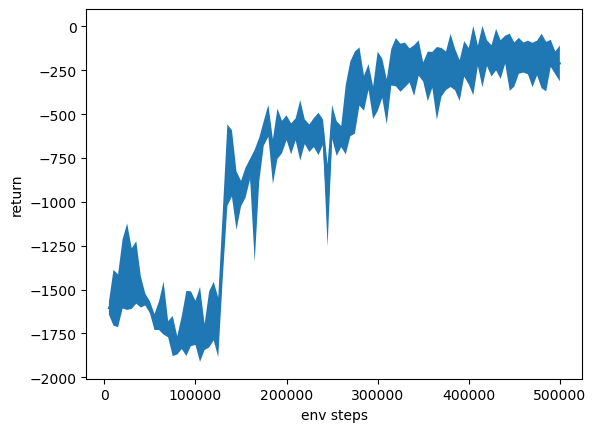

In [9]:
import matplotlib.pyplot as plt
print(learning_curve)
plt.plot(learning_curve["x"], learning_curve["y"])
plt.fill_between(np.array(learning_curve["x"]), np.array(learning_curve["y"])-np.array(learning_curve["z"]), np.array(learning_curve["y"])+np.array(learning_curve["z"]))
plt.xlabel("env steps")
plt.ylabel("return")
plt.show()

In [4]:
leaning_curve_ncde_48_rk4 = learning_curve

NameError: name 'learning_curve' is not defined

In [6]:
learning_curve_ncde_64= learning_curve


In [14]:
timess=torch.linspace(0, 65-1, 65)

In [10]:
learning_curve


{'x': [], 'y': []}

In [6]:
rnn = torch.nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [7]:
output.size()



torch.Size([5, 3, 20])

In [5]:
def projection (x, y):
    
    proj= y*torch.sum(x*y)/(torch.norm(y)**2)
    
    return proj


In [11]:
x = torch.tensor([1.0,1.0])
y = torch.tensor([1.0,-1.0])

In [12]:
proj = projection(x,y)


In [13]:
proj

tensor([0., -0.])